# Part 1, Re-track IBB Index

If you have read the paper, you may notice that the first part of application in the paper is to select a subset of stocks from IBB Index to re-track the Index.


OK, let's start.

In [1]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

Using TensorFlow backend.


** Load data **

- `index_col = 0`: since first column is date (useless for training), let's keep it as index
- `dropna(axis=1, how='any')`: drop any stock with any n/a (missing) data
- `astype('float32')`: datatype

Finally we only have **83** stocks to use.

In [2]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('data/IVW_clean/IVW_last_price.csv', \
                       index_col=0,skiprows=np.arange(1,1055),header=0).dropna(axis=1, how='any').astype('float32')
stock_lp.index = pd.to_datetime(stock_lp.index)
stock['calibrate']['lp'] = stock_lp.iloc[0:1007, :]
stock['validate']['lp'] = stock_lp.iloc[1007:, :]

stock_net = pd.read_csv('data/IVW_clean/IVW_net_change.csv', \
                        index_col=0,skiprows=np.arange(1,1055),header=0,\
                        usecols=np.append(stock_lp.columns.values,'date')).dropna(axis=1, how='any').astype('float32')
stock_net.index = pd.to_datetime(stock_net.index)
stock['calibrate']['net'] = stock_net.iloc[0:1007, :]
stock['validate']['net'] = stock_net.iloc[1007:, :]

stock_percentage = pd.read_csv('data/IVW_clean/IVW_percentage_change.csv', \
                               index_col=0,skiprows=np.arange(1,1055),header=0,\
                               usecols=np.append(stock_lp.columns.values,'date')).dropna(axis=1, how='any').astype('float32')
stock_percentage.index = pd.to_datetime(stock_percentage.index)
stock['calibrate']['percentage'] = stock_percentage.iloc[0:1007, :]
stock['validate']['percentage'] = stock_percentage.iloc[1007:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('data/IVW_clean/IVW.csv',index_col=0,skiprows=np.arange(1,1055),header=0).astype('float32')
ibb_full.index = pd.to_datetime(ibb_full.index)
ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:1007]
ibb['validate']['lp'] = ibb_lp[1007:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:1007]
ibb['validate']['net'] = ibb_net[1007:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:1007]
ibb['validate']['percentage'] = ibb_percentage[1007:]

- calibrate : 2014 to 2017, 1007 rows x 289 stocks
- validate: 2018 to 2019, 456 rows × 289 stocks

# Phase 1. Auto-encoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Page 7 of the paper: ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):
1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. How to perform 4-fold validation in Deep Learning?

In [3]:
encoding_dim = 64 # 5 neurons
num_stock = len(stock_lp.columns) # Use 289 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=20000, batch_size = 40)
autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/20000
1007/1007 [==============================] - 0s 147us/step - loss: 10.4894
Epoch 2/20000
1007/1007 [==============================] - 0s 53us/step - loss: 9.3199
Epoch 3/20000
1007/1007 [==============================] - 0s 74us/step - loss: 8.5126
Epoch 4/20000
1007/1007 [==============================] - 0s 63us/step - loss: 7.6447
Epoch 5/20000
1007/1007 [==============================] - 0s 77us/step - loss: 6.8175
Epoch 6/20000
1007/1007 [==============================] - 0s 65us/step - loss: 6.1885
Epoch 7/20000
1007/1007 [==============================] - 0s 53us/step - loss: 5.7726
Epoch 8/20000
1007/1007 [==============================] - 0s 52us/step - loss: 5.4943
Epoch 9/20000
1007/1007 [==============================] - 0s 54us/step - loss: 5.2916
Epoch 10/20000
1007/1007 [==============================] - 0s 76us/step - loss: 5.1313
Epoch 11/20000
1007/1007 [==============================] - 0s 84us/step - loss: 4.9967
Epoch 12/20000
1007/1007 [=============

1007/1007 [==============================] - 0s 89us/step - loss: 2.2532
Epoch 94/20000
1007/1007 [==============================] - 0s 67us/step - loss: 2.2424
Epoch 95/20000
1007/1007 [==============================] - 0s 52us/step - loss: 2.2318
Epoch 96/20000
1007/1007 [==============================] - 0s 43us/step - loss: 2.2214
Epoch 97/20000
1007/1007 [==============================] - 0s 47us/step - loss: 2.2111
Epoch 98/20000
1007/1007 [==============================] - 0s 47us/step - loss: 2.2010
Epoch 99/20000
1007/1007 [==============================] - 0s 48us/step - loss: 2.1911
Epoch 100/20000
1007/1007 [==============================] - 0s 47us/step - loss: 2.1813
Epoch 101/20000
1007/1007 [==============================] - 0s 43us/step - loss: 2.1717
Epoch 102/20000
1007/1007 [==============================] - 0s 43us/step - loss: 2.1622
Epoch 103/20000
1007/1007 [==============================] - 0s 49us/step - loss: 2.1529
Epoch 104/20000
1007/1007 [================

1007/1007 [==============================] - 0s 41us/step - loss: 1.5268
Epoch 278/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.5257
Epoch 279/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.5246
Epoch 280/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.5235
Epoch 281/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.5225
Epoch 282/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.5214
Epoch 283/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.5204
Epoch 284/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.5194
Epoch 285/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.5183
Epoch 286/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.5173
Epoch 287/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.5163
Epoch 288/20000
1007/1007 [==========

Epoch 369/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.4604
Epoch 370/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.4599
Epoch 371/20000
1007/1007 [==============================] - 0s 79us/step - loss: 1.4595
Epoch 372/20000
1007/1007 [==============================] - 0s 79us/step - loss: 1.4590
Epoch 373/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.4586
Epoch 374/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.4582
Epoch 375/20000
1007/1007 [==============================] - 0s 90us/step - loss: 1.4577
Epoch 376/20000
1007/1007 [==============================] - 0s 77us/step - loss: 1.4573
Epoch 377/20000
1007/1007 [==============================] - 0s 73us/step - loss: 1.4569
Epoch 378/20000
1007/1007 [==============================] - 0s 81us/step - loss: 1.4565
Epoch 379/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.4560
Epoch 380/20000
1007/

Epoch 461/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.4311
Epoch 462/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.4309
Epoch 463/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.4307
Epoch 464/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.4304
Epoch 465/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.4302
Epoch 466/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4300
Epoch 467/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.4298
Epoch 468/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4296
Epoch 469/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.4294
Epoch 470/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.4292
Epoch 471/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.4290
Epoch 472/20000
1007/

1007/1007 [==============================] - 0s 58us/step - loss: 1.4069
Epoch 644/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.4069
Epoch 645/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.4068
Epoch 646/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.4067
Epoch 647/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.4066
Epoch 648/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.4065
Epoch 649/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.4065
Epoch 650/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.4064
Epoch 651/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.4063
Epoch 652/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.4062
Epoch 653/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.4061
Epoch 654/20000
1007/1007 [==========

Epoch 827/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3950
Epoch 828/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3950
Epoch 829/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3949
Epoch 830/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.3949: 0s - loss: 1.398
Epoch 831/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3948
Epoch 832/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3947
Epoch 833/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.3947
Epoch 834/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.3946
Epoch 835/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3946
Epoch 836/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3945
Epoch 837/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3945
Epo

1007/1007 [==============================] - 0s 66us/step - loss: 1.3868
Epoch 1010/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.3868
Epoch 1011/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3868
Epoch 1012/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3867
Epoch 1013/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3867
Epoch 1014/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.3866
Epoch 1015/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3866
Epoch 1016/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3866
Epoch 1017/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3865
Epoch 1018/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3865
Epoch 1019/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3865
Epoch 1020/20000
1007/1007 

1007/1007 [==============================] - 0s 56us/step - loss: 1.3804
Epoch 1191/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3804
Epoch 1192/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3804
Epoch 1193/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3803
Epoch 1194/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.3803
Epoch 1195/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3803
Epoch 1196/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3802
Epoch 1197/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3802
Epoch 1198/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3802
Epoch 1199/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.3801
Epoch 1200/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.3801
Epoch 1201/20000
1007/1007 

Epoch 1281/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.3775
Epoch 1282/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3775
Epoch 1283/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.298 - 0s 71us/step - loss: 1.3775
Epoch 1284/20000
1007/1007 [==============================] - 0s 90us/step - loss: 1.3774
Epoch 1285/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.3774
Epoch 1286/20000
1007/1007 [==============================] - 0s 79us/step - loss: 1.3774
Epoch 1287/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.3774
Epoch 1288/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.3773
Epoch 1289/20000
1007/1007 [==============================] - 0s 107us/step - loss: 1.3773
Epoch 1290/20000
1007/1007 [==============================] - 0s 115us/step - loss: 1.3773
Epoch 1291/20000
1007/1007 [==============================] - 0s 102us/ste

Epoch 1462/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3724
Epoch 1463/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3724
Epoch 1464/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.3724
Epoch 1465/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3724
Epoch 1466/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3723
Epoch 1467/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3723
Epoch 1468/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3723
Epoch 1469/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3723
Epoch 1470/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3722
Epoch 1471/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3722
Epoch 1472/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3722
Epoch 1473

Epoch 1553/20000
1007/1007 [==============================] - 0s 71us/step - loss: 1.3701
Epoch 1554/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.3701
Epoch 1555/20000
1007/1007 [==============================] - 0s 73us/step - loss: 1.3701
Epoch 1556/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.3701
Epoch 1557/20000
1007/1007 [==============================] - 0s 87us/step - loss: 1.3700
Epoch 1558/20000
1007/1007 [==============================] - 0s 81us/step - loss: 1.3700
Epoch 1559/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.3700
Epoch 1560/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3700
Epoch 1561/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3699
Epoch 1562/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3699
Epoch 1563/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3699
Epoch 1564

1007/1007 [==============================] - 0s 48us/step - loss: 1.3679
Epoch 1645/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3679
Epoch 1646/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3679
Epoch 1647/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3678
Epoch 1648/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3678
Epoch 1649/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3678
Epoch 1650/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3678
Epoch 1651/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3677
Epoch 1652/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.3677: 0s - loss: 1.370
Epoch 1653/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3677
Epoch 1654/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3677
Epoch 165

1007/1007 [==============================] - 0s 46us/step - loss: 1.3638
Epoch 1826/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3638
Epoch 1827/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3637
Epoch 1828/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3637
Epoch 1829/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.3637
Epoch 1830/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.3637
Epoch 1831/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.3636
Epoch 1832/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3636
Epoch 1833/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3636
Epoch 1834/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3636
Epoch 1835/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.3636
Epoch 1836/20000
1007/1007 

1007/1007 [==============================] - 0s 50us/step - loss: 1.3599
Epoch 2007/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.3599
Epoch 2008/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3599
Epoch 2009/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3599
Epoch 2010/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3599
Epoch 2011/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3598
Epoch 2012/20000
1007/1007 [==============================] - 0s 77us/step - loss: 1.3598
Epoch 2013/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3598
Epoch 2014/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3598
Epoch 2015/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3597
Epoch 2016/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3597
Epoch 2017/20000
1007/1007 

1007/1007 [==============================] - 0s 80us/step - loss: 1.3580
Epoch 2098/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.3580
Epoch 2099/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3579
Epoch 2100/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3579
Epoch 2101/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3579
Epoch 2102/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.3579
Epoch 2103/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3579
Epoch 2104/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3578
Epoch 2105/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3578
Epoch 2106/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3578
Epoch 2107/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3578
Epoch 2108/20000
1007/1007 

1007/1007 [==============================] - 0s 49us/step - loss: 1.3542
Epoch 2280/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3542
Epoch 2281/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3541
Epoch 2282/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3541
Epoch 2283/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3541
Epoch 2284/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.157 - 0s 50us/step - loss: 1.3541
Epoch 2285/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3541
Epoch 2286/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3540
Epoch 2287/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3540
Epoch 2288/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3540
Epoch 2289/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3540
Epo

Epoch 2370/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3523
Epoch 2371/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3523
Epoch 2372/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.3522
Epoch 2373/20000
1007/1007 [==============================] - 0s 81us/step - loss: 1.3522
Epoch 2374/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3522
Epoch 2375/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3522
Epoch 2376/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3522
Epoch 2377/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3521
Epoch 2378/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3521
Epoch 2379/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.3521
Epoch 2380/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3521
Epoch 2381

1007/1007 [==============================] - 0s 56us/step - loss: 1.3504
Epoch 2462/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3504
Epoch 2463/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3504
Epoch 2464/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.3503
Epoch 2465/20000
1007/1007 [==============================] - 0s 81us/step - loss: 1.3503
Epoch 2466/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.3503
Epoch 2467/20000
1007/1007 [==============================] - 0s 76us/step - loss: 1.3503
Epoch 2468/20000
1007/1007 [==============================] - 0s 72us/step - loss: 1.3502
Epoch 2469/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.3502
Epoch 2470/20000
1007/1007 [==============================] - 0s 79us/step - loss: 1.3502
Epoch 2471/20000
1007/1007 [==============================] - 0s 76us/step - loss: 1.3502
Epoch 2472/20000
1007/1007 

1007/1007 [==============================] - 0s 43us/step - loss: 1.3466
Epoch 2643/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3465
Epoch 2644/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3465
Epoch 2645/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.3465
Epoch 2646/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3465
Epoch 2647/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3464
Epoch 2648/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3464
Epoch 2649/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.3464
Epoch 2650/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3464
Epoch 2651/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3464
Epoch 2652/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3463
Epoch 2653/20000
1007/1007 

1007/1007 [==============================] - 0s 61us/step - loss: 1.3447
Epoch 2734/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.3447
Epoch 2735/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3447
Epoch 2736/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3446
Epoch 2737/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3446
Epoch 2738/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3446
Epoch 2739/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3446
Epoch 2740/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3446
Epoch 2741/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3445
Epoch 2742/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3445
Epoch 2743/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.3445
Epoch 2744/20000
1007/1007 

1007/1007 [==============================] - 0s 58us/step - loss: 1.3410
Epoch 2915/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.3410
Epoch 2916/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.3410
Epoch 2917/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.3409
Epoch 2918/20000
1007/1007 [==============================] - 0s 72us/step - loss: 1.3409
Epoch 2919/20000
1007/1007 [==============================] - 0s 84us/step - loss: 1.3409
Epoch 2920/20000
1007/1007 [==============================] - 0s 80us/step - loss: 1.3409
Epoch 2921/20000
1007/1007 [==============================] - 0s 102us/step - loss: 1.3409
Epoch 2922/20000
1007/1007 [==============================] - 0s 94us/step - loss: 1.3408
Epoch 2923/20000
1007/1007 [==============================] - 0s 84us/step - loss: 1.3408
Epoch 2924/20000
1007/1007 [==============================] - 0s 82us/step - loss: 1.3408
Epoch 2925/20000
1007/1007

1007/1007 [==============================] - 0s 51us/step - loss: 1.3391
Epoch 3006/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3391
Epoch 3007/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3391
Epoch 3008/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3391
Epoch 3009/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3390
Epoch 3010/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3390
Epoch 3011/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.3390
Epoch 3012/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3390
Epoch 3013/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3390
Epoch 3014/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3389
Epoch 3015/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3389
Epoch 3016/20000
1007/1007 

1007/1007 [==============================] - 0s 80us/step - loss: 1.3353
Epoch 3187/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.3353
Epoch 3188/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.3353
Epoch 3189/20000
1007/1007 [==============================] - 0s 83us/step - loss: 1.3352
Epoch 3190/20000
1007/1007 [==============================] - 0s 94us/step - loss: 1.3352
Epoch 3191/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.3352
Epoch 3192/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.3352
Epoch 3193/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.3351
Epoch 3194/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3351
Epoch 3195/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.3351
Epoch 3196/20000
1007/1007 [==============================] - 0s 82us/step - loss: 1.3351
Epoch 3197/20000
1007/1007 

Epoch 3277/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3334
Epoch 3278/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3334
Epoch 3279/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3333
Epoch 3280/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3333
Epoch 3281/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.3333
Epoch 3282/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3333
Epoch 3283/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3333
Epoch 3284/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3332
Epoch 3285/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3332
Epoch 3286/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3332
Epoch 3287/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3332
Epoch 3288

Epoch 3368/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3315
Epoch 3369/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3315
Epoch 3370/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3314
Epoch 3371/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3314
Epoch 3372/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3314
Epoch 3373/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3314
Epoch 3374/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3314
Epoch 3375/20000
1007/1007 [==============================] - 0s 76us/step - loss: 1.3313
Epoch 3376/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3313
Epoch 3377/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3313
Epoch 3378/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3313
Epoch 3379

Epoch 3549/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3276
Epoch 3550/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3275
Epoch 3551/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3275
Epoch 3552/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.3275
Epoch 3553/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.3275
Epoch 3554/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3274
Epoch 3555/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3274
Epoch 3556/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3274
Epoch 3557/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3274
Epoch 3558/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3273
Epoch 3559/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3273
Epoch 3560

1007/1007 [==============================] - 0s 50us/step - loss: 1.3256
Epoch 3641/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.3255
Epoch 3642/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.3255
Epoch 3643/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3255
Epoch 3644/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3255
Epoch 3645/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3255
Epoch 3646/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3254
Epoch 3647/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3254
Epoch 3648/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3254
Epoch 3649/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3254
Epoch 3650/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.3253
Epoch 3651/20000
1007/1007 

Epoch 3821/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.3217
Epoch 3822/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3217
Epoch 3823/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3217
Epoch 3824/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3217
Epoch 3825/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.3217
Epoch 3826/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.3216
Epoch 3827/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.3216
Epoch 3828/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.3216
Epoch 3829/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3216
Epoch 3830/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3216
Epoch 3831/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.3215
Epoch 3832

1007/1007 [==============================] - 0s 38us/step - loss: 1.3178
Epoch 4003/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3178
Epoch 4004/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3178
Epoch 4005/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3178
Epoch 4006/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3177
Epoch 4007/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.3177
Epoch 4008/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3177
Epoch 4009/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3177
Epoch 4010/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3176
Epoch 4011/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3176
Epoch 4012/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3176
Epoch 4013/20000
1007/1007 

1007/1007 [==============================] - 0s 38us/step - loss: 1.3137
Epoch 4184/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3137
Epoch 4185/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3137
Epoch 4186/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3137
Epoch 4187/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3137
Epoch 4188/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3136
Epoch 4189/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3136
Epoch 4190/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3136
Epoch 4191/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3136
Epoch 4192/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3135
Epoch 4193/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3135
Epoch 4194/20000
1007/1007 

Epoch 4274/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.3117
Epoch 4275/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3117
Epoch 4276/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3117
Epoch 4277/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3116
Epoch 4278/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3116
Epoch 4279/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3116
Epoch 4280/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3116
Epoch 4281/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3115
Epoch 4282/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3115
Epoch 4283/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3115
Epoch 4284/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3115
Epoch 4285

1007/1007 [==============================] - 0s 38us/step - loss: 1.3097
Epoch 4366/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3096
Epoch 4367/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3096
Epoch 4368/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3096
Epoch 4369/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3096
Epoch 4370/20000
1007/1007 [==============================] - 0s 36us/step - loss: 1.3095
Epoch 4371/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.3095
Epoch 4372/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3095
Epoch 4373/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3095
Epoch 4374/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.3094
Epoch 4375/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3094
Epoch 4376/20000
1007/1007 

1007/1007 [==============================] - 0s 38us/step - loss: 1.3056
Epoch 4548/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3056
Epoch 4549/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3055
Epoch 4550/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.3055
Epoch 4551/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.3055
Epoch 4552/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.3055
Epoch 4553/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.3054
Epoch 4554/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3054
Epoch 4555/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3054
Epoch 4556/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3054
Epoch 4557/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3054
Epoch 4558/20000
1007/1007 

1007/1007 [==============================] - 0s 40us/step - loss: 1.3016
Epoch 4730/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3015
Epoch 4731/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3015
Epoch 4732/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3015
Epoch 4733/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3015
Epoch 4734/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3014
Epoch 4735/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.3014
Epoch 4736/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3014
Epoch 4737/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3014
Epoch 4738/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.3014
Epoch 4739/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.3013
Epoch 4740/20000
1007/1007 

Epoch 4820/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2995
Epoch 4821/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2995
Epoch 4822/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2995
Epoch 4823/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2994
Epoch 4824/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2994
Epoch 4825/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2994
Epoch 4826/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2994
Epoch 4827/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2993
Epoch 4828/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2993
Epoch 4829/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2993
Epoch 4830/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2993
Epoch 4831

1007/1007 [==============================] - 0s 40us/step - loss: 1.2955
Epoch 5002/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2954
Epoch 5003/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2954
Epoch 5004/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2954
Epoch 5005/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.2954
Epoch 5006/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.2954
Epoch 5007/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2953
Epoch 5008/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.2953
Epoch 5009/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.2953
Epoch 5010/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.2953
Epoch 5011/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2952
Epoch 5012/20000
1007/1007 

Epoch 5183/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2915
Epoch 5184/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2915
Epoch 5185/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2914
Epoch 5186/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2914
Epoch 5187/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.2914
Epoch 5188/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2914
Epoch 5189/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2914
Epoch 5190/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2913
Epoch 5191/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2913
Epoch 5192/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2913
Epoch 5193/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2913
Epoch 5194

1007/1007 [==============================] - 0s 40us/step - loss: 1.2877
Epoch 5364/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2876
Epoch 5365/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2876
Epoch 5366/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2876
Epoch 5367/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2876
Epoch 5368/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2876
Epoch 5369/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2875
Epoch 5370/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2875
Epoch 5371/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2875
Epoch 5372/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2875
Epoch 5373/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2875
Epoch 5374/20000
1007/1007 

Epoch 5454/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2858
Epoch 5455/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2858
Epoch 5456/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2858
Epoch 5457/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2857
Epoch 5458/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2857
Epoch 5459/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2857
Epoch 5460/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2857
Epoch 5461/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2857
Epoch 5462/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2856
Epoch 5463/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2856
Epoch 5464/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2856
Epoch 5465

1007/1007 [==============================] - 0s 43us/step - loss: 1.2839
Epoch 5546/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2839
Epoch 5547/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2839
Epoch 5548/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2839
Epoch 5549/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2839
Epoch 5550/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2838
Epoch 5551/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2838
Epoch 5552/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2838
Epoch 5553/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2838
Epoch 5554/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2838
Epoch 5555/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2837
Epoch 5556/20000
1007/1007 

Epoch 5727/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2803
Epoch 5728/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2803
Epoch 5729/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2803
Epoch 5730/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2803
Epoch 5731/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2802
Epoch 5732/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2802
Epoch 5733/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2802
Epoch 5734/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2802
Epoch 5735/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2802
Epoch 5736/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2801
Epoch 5737/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2801
Epoch 5738

1007/1007 [==============================] - 0s 54us/step - loss: 1.2786
Epoch 5819/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2785
Epoch 5820/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2785
Epoch 5821/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.2785
Epoch 5822/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.2785
Epoch 5823/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2785
Epoch 5824/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.2784
Epoch 5825/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2784
Epoch 5826/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.2784
Epoch 5827/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2784
Epoch 5828/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2784
Epoch 5829/20000
1007/1007 

1007/1007 [==============================] - 0s 39us/step - loss: 1.2751
Epoch 6001/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2751
Epoch 6002/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2750
Epoch 6003/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2750
Epoch 6004/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2750
Epoch 6005/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2750
Epoch 6006/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2750
Epoch 6007/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2750
Epoch 6008/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2749
Epoch 6009/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2749
Epoch 6010/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2749
Epoch 6011/20000
1007/1007 

1007/1007 [==============================] - 0s 39us/step - loss: 1.2717
Epoch 6183/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2716
Epoch 6184/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.102 - 0s 41us/step - loss: 1.2716
Epoch 6185/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2716
Epoch 6186/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2716
Epoch 6187/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2716
Epoch 6188/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2715
Epoch 6189/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2715
Epoch 6190/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2715
Epoch 6191/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2715
Epoch 6192/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2715
Epo

Epoch 6273/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2700
Epoch 6274/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2700
Epoch 6275/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2700
Epoch 6276/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2699
Epoch 6277/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2699
Epoch 6278/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.2699
Epoch 6279/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2699
Epoch 6280/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2699
Epoch 6281/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.2698
Epoch 6282/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2698
Epoch 6283/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.2698
Epoch 6284

1007/1007 [==============================] - 0s 37us/step - loss: 1.2667
Epoch 6456/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2667
Epoch 6457/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2667
Epoch 6458/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2667
Epoch 6459/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2667
Epoch 6460/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2666
Epoch 6461/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2666
Epoch 6462/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2666
Epoch 6463/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2666
Epoch 6464/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2666
Epoch 6465/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2665
Epoch 6466/20000
1007/1007 

Epoch 6637/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2635
Epoch 6638/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2635
Epoch 6639/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2634
Epoch 6640/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2634
Epoch 6641/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2634
Epoch 6642/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2634
Epoch 6643/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.2634
Epoch 6644/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2634
Epoch 6645/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2633
Epoch 6646/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2633
Epoch 6647/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2633
Epoch 6648

1007/1007 [==============================] - 0s 39us/step - loss: 1.2604
Epoch 6819/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2604
Epoch 6820/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2603
Epoch 6821/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2603
Epoch 6822/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2603
Epoch 6823/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2603
Epoch 6824/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2603
Epoch 6825/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2603
Epoch 6826/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2602
Epoch 6827/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2602
Epoch 6828/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2602
Epoch 6829/20000
1007/1007 

1007/1007 [==============================] - 0s 38us/step - loss: 1.2574
Epoch 7001/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2574
Epoch 7002/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2574
Epoch 7003/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2574
Epoch 7004/20000
1007/1007 [==============================] - 0s 36us/step - loss: 1.2573
Epoch 7005/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2573
Epoch 7006/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2573
Epoch 7007/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2573
Epoch 7008/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2573
Epoch 7009/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2573
Epoch 7010/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2572
Epoch 7011/20000
1007/1007 

1007/1007 [==============================] - 0s 38us/step - loss: 1.2545
Epoch 7183/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2545
Epoch 7184/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2545
Epoch 7185/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2545
Epoch 7186/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2545
Epoch 7187/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2544
Epoch 7188/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2544
Epoch 7189/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2544
Epoch 7190/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2544
Epoch 7191/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2544
Epoch 7192/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2544
Epoch 7193/20000
1007/1007 

1007/1007 [==============================] - 0s 38us/step - loss: 1.2518
Epoch 7365/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2517
Epoch 7366/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2517
Epoch 7367/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2517
Epoch 7368/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2517
Epoch 7369/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2517
Epoch 7370/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2517
Epoch 7371/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2516
Epoch 7372/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2516
Epoch 7373/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2516
Epoch 7374/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2516
Epoch 7375/20000
1007/1007 

1007/1007 [==============================] - 0s 38us/step - loss: 1.2491
Epoch 7546/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2491
Epoch 7547/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2491
Epoch 7548/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2491
Epoch 7549/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2491
Epoch 7550/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2491
Epoch 7551/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2490
Epoch 7552/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2490
Epoch 7553/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.2490
Epoch 7554/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2490
Epoch 7555/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2490
Epoch 7556/20000
1007/1007 

1007/1007 [==============================] - 0s 73us/step - loss: 1.2466
Epoch 7727/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.2466
Epoch 7728/20000
1007/1007 [==============================] - 0s 79us/step - loss: 1.2466
Epoch 7729/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.2465
Epoch 7730/20000
1007/1007 [==============================] - 0s 76us/step - loss: 1.2465
Epoch 7731/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.2465
Epoch 7732/20000
1007/1007 [==============================] - 0s 217us/step - loss: 1.2465
Epoch 7733/20000
1007/1007 [==============================] - 0s 76us/step - loss: 1.2465
Epoch 7734/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2465
Epoch 7735/20000
1007/1007 [==============================] - 0s 164us/step - loss: 1.2465
Epoch 7736/20000
1007/1007 [==============================] - 0s 108us/step - loss: 1.2465
Epoch 7737/20000
1007/10

1007/1007 [==============================] - 0s 77us/step - loss: 1.2453
Epoch 7818/20000
1007/1007 [==============================] - 0s 75us/step - loss: 1.2453
Epoch 7819/20000
1007/1007 [==============================] - 0s 90us/step - loss: 1.2453
Epoch 7820/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.2453
Epoch 7821/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.2453
Epoch 7822/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2453
Epoch 7823/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2453
Epoch 7824/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2452
Epoch 7825/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2452
Epoch 7826/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2452
Epoch 7827/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2452
Epoch 7828/20000
1007/1007 

1007/1007 [==============================] - 0s 54us/step - loss: 1.2429
Epoch 7999/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2429
Epoch 8000/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2429
Epoch 8001/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2429
Epoch 8002/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2429
Epoch 8003/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2429
Epoch 8004/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2428
Epoch 8005/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2428
Epoch 8006/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2428
Epoch 8007/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2428
Epoch 8008/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2428
Epoch 8009/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.2406
Epoch 8180/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2406
Epoch 8181/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2406
Epoch 8182/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2406
Epoch 8183/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2406
Epoch 8184/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.2406
Epoch 8185/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2405
Epoch 8186/20000
1007/1007 [==============================] - 0s 81us/step - loss: 1.2405
Epoch 8187/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2405
Epoch 8188/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.2405
Epoch 8189/20000
1007/1007 [==============================] - 0s 91us/step - loss: 1.2405
Epoch 8190/20000
1007/1007 

1007/1007 [==============================] - 0s 58us/step - loss: 1.2384
Epoch 8361/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2384
Epoch 8362/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2384
Epoch 8363/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2384
Epoch 8364/20000
1007/1007 [==============================] - 0s 73us/step - loss: 1.2384
Epoch 8365/20000
1007/1007 [==============================] - 0s 75us/step - loss: 1.2384
Epoch 8366/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2384
Epoch 8367/20000
1007/1007 [==============================] - 0s 128us/step - loss: 1.2383
Epoch 8368/20000
1007/1007 [==============================] - 0s 86us/step - loss: 1.2383
Epoch 8369/20000
1007/1007 [==============================] - 0s 80us/step - loss: 1.2383
Epoch 8370/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2383
Epoch 8371/20000
1007/1007

1007/1007 [==============================] - 0s 59us/step - loss: 1.2363
Epoch 8543/20000
1007/1007 [==============================] - 0s 197us/step - loss: 1.2363
Epoch 8544/20000
1007/1007 [==============================] - 0s 89us/step - loss: 1.2363
Epoch 8545/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2362
Epoch 8546/20000
1007/1007 [==============================] - 0s 95us/step - loss: 1.2362
Epoch 8547/20000
1007/1007 [==============================] - 0s 84us/step - loss: 1.2362
Epoch 8548/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.2362
Epoch 8549/20000
1007/1007 [==============================] - 0s 88us/step - loss: 1.2362
Epoch 8550/20000
1007/1007 [==============================] - 0s 86us/step - loss: 1.2362
Epoch 8551/20000
1007/1007 [==============================] - 0s 71us/step - loss: 1.2362
Epoch 8552/20000
1007/1007 [==============================] - 0s 86us/step - loss: 1.2362
Epoch 8553/20000
1007/1007

1007/1007 [==============================] - 0s 80us/step - loss: 1.2342
Epoch 8725/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2342
Epoch 8726/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2342
Epoch 8727/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2342
Epoch 8728/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2342
Epoch 8729/20000
1007/1007 [==============================] - 0s 71us/step - loss: 1.2341
Epoch 8730/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2341
Epoch 8731/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2341
Epoch 8732/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2341
Epoch 8733/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2341
Epoch 8734/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2341
Epoch 8735/20000
1007/1007 

1007/1007 [==============================] - 0s 100us/step - loss: 1.2322
Epoch 8907/20000
1007/1007 [==============================] - 0s 137us/step - loss: 1.2322
Epoch 8908/20000
1007/1007 [==============================] - 0s 113us/step - loss: 1.2322
Epoch 8909/20000
1007/1007 [==============================] - 0s 97us/step - loss: 1.2322
Epoch 8910/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.2322
Epoch 8911/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.2322
Epoch 8912/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2322
Epoch 8913/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2321
Epoch 8914/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2321
Epoch 8915/20000
1007/1007 [==============================] - 0s 77us/step - loss: 1.2321
Epoch 8916/20000
1007/1007 [==============================] - 0s 74us/step - loss: 1.2321
Epoch 8917/20000
1007/10

1007/1007 [==============================] - 0s 60us/step - loss: 1.2313
Epoch 8998/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2312
Epoch 8999/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2312
Epoch 9000/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2312
Epoch 9001/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2312
Epoch 9002/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2312
Epoch 9003/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2312
Epoch 9004/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2312
Epoch 9005/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2312
Epoch 9006/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2312
Epoch 9007/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2311
Epoch 9008/20000
1007/1007 

1007/1007 [==============================] - 0s 87us/step - loss: 1.2303
Epoch 9089/20000
1007/1007 [==============================] - 0s 108us/step - loss: 1.2303
Epoch 9090/20000
1007/1007 [==============================] - 0s 101us/step - loss: 1.2302
Epoch 9091/20000
1007/1007 [==============================] - 0s 87us/step - loss: 1.2302
Epoch 9092/20000
1007/1007 [==============================] - 0s 96us/step - loss: 1.2302
Epoch 9093/20000
1007/1007 [==============================] - 0s 115us/step - loss: 1.2302
Epoch 9094/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.2302
Epoch 9095/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2302
Epoch 9096/20000
1007/1007 [==============================] - 0s 81us/step - loss: 1.2302
Epoch 9097/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.2302
Epoch 9098/20000
1007/1007 [==============================] - 0s 80us/step - loss: 1.2302
Epoch 9099/20000
1007/10

1007/1007 [==============================] - 0s 90us/step - loss: 1.2284
Epoch 9269/20000
1007/1007 [==============================] - 0s 89us/step - loss: 1.2284
Epoch 9270/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2284
Epoch 9271/20000
1007/1007 [==============================] - 0s 72us/step - loss: 1.2284
Epoch 9272/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2283
Epoch 9273/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2283
Epoch 9274/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.2283
Epoch 9275/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2283
Epoch 9276/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2283
Epoch 9277/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2283
Epoch 9278/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2283
Epoch 9279/20000
1007/1007 

1007/1007 [==============================] - 0s 62us/step - loss: 1.2266
Epoch 9449/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2266
Epoch 9450/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2265
Epoch 9451/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.2265
Epoch 9452/20000
1007/1007 [==============================] - 0s 192us/step - loss: 1.2265
Epoch 9453/20000
1007/1007 [==============================] - 0s 71us/step - loss: 1.2265
Epoch 9454/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.2265
Epoch 9455/20000
1007/1007 [==============================] - 0s 120us/step - loss: 1.2265
Epoch 9456/20000
1007/1007 [==============================] - 0s 73us/step - loss: 1.2265
Epoch 9457/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2265
Epoch 9458/20000
1007/1007 [==============================] - 0s 97us/step - loss: 1.2265
Epoch 9459/20000
1007/100

1007/1007 [==============================] - 0s 55us/step - loss: 1.2248
Epoch 9631/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2248
Epoch 9632/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2248
Epoch 9633/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2247
Epoch 9634/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2247
Epoch 9635/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2247
Epoch 9636/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2247
Epoch 9637/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2247
Epoch 9638/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2247
Epoch 9639/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2247
Epoch 9640/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2247
Epoch 9641/20000
1007/1007 

Epoch 9812/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2230
Epoch 9813/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2230
Epoch 9814/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2230
Epoch 9815/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2230
Epoch 9816/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2230
Epoch 9817/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.2230
Epoch 9818/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2230
Epoch 9819/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2230
Epoch 9820/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2230
Epoch 9821/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2230
Epoch 9822/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2230
Epoch 9823

Epoch 9903/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2222
Epoch 9904/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2222
Epoch 9905/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2222
Epoch 9906/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2222
Epoch 9907/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.2222
Epoch 9908/20000
1007/1007 [==============================] - 0s 81us/step - loss: 1.2222
Epoch 9909/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2221
Epoch 9910/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2221
Epoch 9911/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2221
Epoch 9912/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2221
Epoch 9913/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2221
Epoch 9914

Epoch 9994/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.2214
Epoch 9995/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.2214
Epoch 9996/20000
1007/1007 [==============================] - 0s 183us/step - loss: 1.2213
Epoch 9997/20000
1007/1007 [==============================] - 0s 72us/step - loss: 1.2213
Epoch 9998/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.2213
Epoch 9999/20000
1007/1007 [==============================] - 0s 108us/step - loss: 1.2213
Epoch 10000/20000
1007/1007 [==============================] - 0s 73us/step - loss: 1.2213
Epoch 10001/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2213
Epoch 10002/20000
1007/1007 [==============================] - 0s 92us/step - loss: 1.2213
Epoch 10003/20000
1007/1007 [==============================] - 0s 89us/step - loss: 1.2213
Epoch 10004/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2213
Epo

Epoch 10173/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2198
Epoch 10174/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.2198
Epoch 10175/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2197
Epoch 10176/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.2197
Epoch 10177/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2197
Epoch 10178/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.2197
Epoch 10179/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.2197
Epoch 10180/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2197
Epoch 10181/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.161 - 0s 74us/step - loss: 1.2197
Epoch 10182/20000
1007/1007 [==============================] - 0s 99us/step - loss: 1.2197
Epoch 10183/20000
1007/1007 [==============================] - 0s 

1007/1007 [==============================] - 0s 59us/step - loss: 1.2182
Epoch 10353/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.2182
Epoch 10354/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2182
Epoch 10355/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2182
Epoch 10356/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.2182
Epoch 10357/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2182
Epoch 10358/20000
1007/1007 [==============================] - 0s 111us/step - loss: 1.2182
Epoch 10359/20000
1007/1007 [==============================] - 0s 85us/step - loss: 1.2181
Epoch 10360/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.2181
Epoch 10361/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.2181
Epoch 10362/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2181
Epoch 10363/2000

1007/1007 [==============================] - 0s 46us/step - loss: 1.2167
Epoch 10533/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2167
Epoch 10534/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2167
Epoch 10535/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2166
Epoch 10536/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.2166
Epoch 10537/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2166
Epoch 10538/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2166
Epoch 10539/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2166
Epoch 10540/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2166
Epoch 10541/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2166
Epoch 10542/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.2166
Epoch 10543/20000

1007/1007 [==============================] - 0s 40us/step - loss: 1.2152
Epoch 10713/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2152
Epoch 10714/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2152
Epoch 10715/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2152
Epoch 10716/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2152
Epoch 10717/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2152
Epoch 10718/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2152
Epoch 10719/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.2151
Epoch 10720/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2152
Epoch 10721/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2151
Epoch 10722/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2151
Epoch 10723/20000

Epoch 10892/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2138
Epoch 10893/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.2138
Epoch 10894/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2138
Epoch 10895/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2138
Epoch 10896/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2138
Epoch 10897/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2138
Epoch 10898/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2137
Epoch 10899/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2137
Epoch 10900/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.2137
Epoch 10901/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2137
Epoch 10902/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2137

1007/1007 [==============================] - 0s 51us/step - loss: 1.2124
Epoch 11072/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2124
Epoch 11073/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.054 - 0s 44us/step - loss: 1.2124
Epoch 11074/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2124
Epoch 11075/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2124
Epoch 11076/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2124
Epoch 11077/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2124
Epoch 11078/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2124
Epoch 11079/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.2124
Epoch 11080/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2124
Epoch 11081/20000
1007/1007 [==============================] - 0s 44us/step - loss: 

1007/1007 [==============================] - 0s 45us/step - loss: 1.2111
Epoch 11251/20000
1007/1007 [==============================] - 0s 101us/step - loss: 1.2111
Epoch 11252/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2111
Epoch 11253/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.2111
Epoch 11254/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.2111
Epoch 11255/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2111
Epoch 11256/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.2111
Epoch 11257/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2111
Epoch 11258/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2111
Epoch 11259/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2111
Epoch 11260/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2111
Epoch 11261/2000

1007/1007 [==============================] - 0s 81us/step - loss: 1.2099
Epoch 11430/20000
1007/1007 [==============================] - 0s 84us/step - loss: 1.2099
Epoch 11431/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2099
Epoch 11432/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2099
Epoch 11433/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2099
Epoch 11434/20000
1007/1007 [==============================] - 0s 79us/step - loss: 1.2099
Epoch 11435/20000
1007/1007 [==============================] - 0s 87us/step - loss: 1.2098
Epoch 11436/20000
1007/1007 [==============================] - 0s 76us/step - loss: 1.2098
Epoch 11437/20000
1007/1007 [==============================] - 0s 83us/step - loss: 1.2098
Epoch 11438/20000
1007/1007 [==============================] - 0s 79us/step - loss: 1.2098
Epoch 11439/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2098
Epoch 11440/20000

1007/1007 [==============================] - 0s 39us/step - loss: 1.2086
Epoch 11610/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2086
Epoch 11611/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.2086
Epoch 11612/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2086
Epoch 11613/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2086
Epoch 11614/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2086
Epoch 11615/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2086
Epoch 11616/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2086
Epoch 11617/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2086
Epoch 11618/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2086
Epoch 11619/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2086
Epoch 11620/20000

1007/1007 [==============================] - 0s 38us/step - loss: 1.2074
Epoch 11790/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2074
Epoch 11791/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2074
Epoch 11792/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2074
Epoch 11793/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2074
Epoch 11794/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2074
Epoch 11795/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2074
Epoch 11796/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.2074
Epoch 11797/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2074
Epoch 11798/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2074
Epoch 11799/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.2074
Epoch 11800/20000

1007/1007 [==============================] - 0s 64us/step - loss: 1.2062
Epoch 11970/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2062
Epoch 11971/20000
1007/1007 [==============================] - 0s 73us/step - loss: 1.2062
Epoch 11972/20000
1007/1007 [==============================] - 0s 82us/step - loss: 1.2062
Epoch 11973/20000
1007/1007 [==============================] - 0s 83us/step - loss: 1.2062
Epoch 11974/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.2062
Epoch 11975/20000
1007/1007 [==============================] - 0s 100us/step - loss: 1.2062
Epoch 11976/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2062
Epoch 11977/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.2062
Epoch 11978/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.2062
Epoch 11979/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2062
Epoch 11980/2000

1007/1007 [==============================] - 0s 60us/step - loss: 1.2051
Epoch 12149/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2051
Epoch 12150/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.2051
Epoch 12151/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2051
Epoch 12152/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2051
Epoch 12153/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2051
Epoch 12154/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.2051
Epoch 12155/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2051
Epoch 12156/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2051
Epoch 12157/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.2051
Epoch 12158/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.2051
Epoch 12159/20000

Epoch 12238/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.2046
Epoch 12239/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2045
Epoch 12240/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2046
Epoch 12241/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2045
Epoch 12242/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.129 - 0s 69us/step - loss: 1.2045
Epoch 12243/20000
1007/1007 [==============================] - 0s 205us/step - loss: 1.2045
Epoch 12244/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2045
Epoch 12245/20000
1007/1007 [==============================] - 0s 109us/step - loss: 1.2045
Epoch 12246/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.2045
Epoch 12247/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2045
Epoch 12248/20000
1007/1007 [==============================] - 0

1007/1007 [==============================] - 0s 70us/step - loss: 1.2035
Epoch 12418/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2035
Epoch 12419/20000
1007/1007 [==============================] - 0s 256us/step - loss: 1.2035
Epoch 12420/20000
1007/1007 [==============================] - 0s 111us/step - loss: 1.2035
Epoch 12421/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2035
Epoch 12422/20000
1007/1007 [==============================] - 0s 91us/step - loss: 1.2035
Epoch 12423/20000
1007/1007 [==============================] - 0s 132us/step - loss: 1.2034
Epoch 12424/20000
1007/1007 [==============================] - 0s 123us/step - loss: 1.2034
Epoch 12425/20000
1007/1007 [==============================] - 0s 107us/step - loss: 1.2034
Epoch 12426/20000
1007/1007 [==============================] - 0s 144us/step - loss: 1.2034
Epoch 12427/20000
1007/1007 [==============================] - 0s 90us/step - loss: 1.2034
Epoch 12428

1007/1007 [==============================] - 0s 40us/step - loss: 1.2024
Epoch 12597/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2024
Epoch 12598/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2024
Epoch 12599/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2024
Epoch 12600/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2024
Epoch 12601/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2024
Epoch 12602/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.2024
Epoch 12603/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.2024
Epoch 12604/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2024
Epoch 12605/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.2024
Epoch 12606/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.2024
Epoch 12607/20000

1007/1007 [==============================] - 0s 44us/step - loss: 1.2014
Epoch 12777/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.2014
Epoch 12778/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.2014
Epoch 12779/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.2014
Epoch 12780/20000
1007/1007 [==============================] - 0s 98us/step - loss: 1.2014
Epoch 12781/20000
1007/1007 [==============================] - 0s 144us/step - loss: 1.2014
Epoch 12782/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2014
Epoch 12783/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.2014
Epoch 12784/20000
1007/1007 [==============================] - 0s 71us/step - loss: 1.2014
Epoch 12785/20000
1007/1007 [==============================] - 0s 87us/step - loss: 1.2014
Epoch 12786/20000
1007/1007 [==============================] - 0s 181us/step - loss: 1.2014
Epoch 12787/200

1007/1007 [==============================] - 0s 56us/step - loss: 1.2005
Epoch 12955/20000
1007/1007 [==============================] - 0s 93us/step - loss: 1.2005
Epoch 12956/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.2005
Epoch 12957/20000
1007/1007 [==============================] - 0s 80us/step - loss: 1.2005
Epoch 12958/20000
1007/1007 [==============================] - 0s 91us/step - loss: 1.2005
Epoch 12959/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2005
Epoch 12960/20000
1007/1007 [==============================] - 0s 79us/step - loss: 1.2004
Epoch 12961/20000
1007/1007 [==============================] - 0s 84us/step - loss: 1.2004
Epoch 12962/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.2004
Epoch 12963/20000
1007/1007 [==============================] - 0s 86us/step - loss: 1.2004
Epoch 12964/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.2004
Epoch 12965/20000

1007/1007 [==============================] - 0s 60us/step - loss: 1.1995
Epoch 13135/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1995
Epoch 13136/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1995
Epoch 13137/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1995
Epoch 13138/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1995
Epoch 13139/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.1995
Epoch 13140/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.1995
Epoch 13141/20000
1007/1007 [==============================] - 0s 95us/step - loss: 1.1995
Epoch 13142/20000
1007/1007 [==============================] - 0s 111us/step - loss: 1.1995
Epoch 13143/20000
1007/1007 [==============================] - 0s 114us/step - loss: 1.1995
Epoch 13144/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1995
Epoch 13145/200

1007/1007 [==============================] - 0s 90us/step - loss: 1.1986
Epoch 13315/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.1986
Epoch 13316/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1986
Epoch 13317/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.1986
Epoch 13318/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.1986
Epoch 13319/20000
1007/1007 [==============================] - 0s 74us/step - loss: 1.1986
Epoch 13320/20000
1007/1007 [==============================] - 0s 91us/step - loss: 1.1985
Epoch 13321/20000
1007/1007 [==============================] - 0s 88us/step - loss: 1.1985
Epoch 13322/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.1985
Epoch 13323/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.1985
Epoch 13324/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.1985
Epoch 13325/20000

1007/1007 [==============================] - 0s 52us/step - loss: 1.1977
Epoch 13495/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1977
Epoch 13496/20000
1007/1007 [==============================] - 0s 72us/step - loss: 1.1976
Epoch 13497/20000
1007/1007 [==============================] - 0s 87us/step - loss: 1.1977
Epoch 13498/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.1976
Epoch 13499/20000
1007/1007 [==============================] - 0s 77us/step - loss: 1.1976
Epoch 13500/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.1976
Epoch 13501/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.1976
Epoch 13502/20000
1007/1007 [==============================] - 0s 87us/step - loss: 1.1976
Epoch 13503/20000
1007/1007 [==============================] - 0s 86us/step - loss: 1.1976
Epoch 13504/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.1976
Epoch 13505/20000

Epoch 13674/20000
1007/1007 [==============================] - 0s 72us/step - loss: 1.1968
Epoch 13675/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.1968
Epoch 13676/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.1968
Epoch 13677/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1968
Epoch 13678/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.1968
Epoch 13679/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.1968
Epoch 13680/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1968
Epoch 13681/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1967
Epoch 13682/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1967
Epoch 13683/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1967
Epoch 13684/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1967

1007/1007 [==============================] - 0s 43us/step - loss: 1.1963
Epoch 13765/20000
1007/1007 [==============================] - 0s 72us/step - loss: 1.1963
Epoch 13766/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1963
Epoch 13767/20000
1007/1007 [==============================] - 0s 74us/step - loss: 1.1963
Epoch 13768/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.1963
Epoch 13769/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.1963
Epoch 13770/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1963
Epoch 13771/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.1963
Epoch 13772/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1963
Epoch 13773/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1963
Epoch 13774/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1963
Epoch 13775/20000

1007/1007 [==============================] - 0s 45us/step - loss: 1.1955
Epoch 13943/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1955
Epoch 13944/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1955
Epoch 13945/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1955
Epoch 13946/20000
1007/1007 [==============================] - 0s 75us/step - loss: 1.1955
Epoch 13947/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1955
Epoch 13948/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1955
Epoch 13949/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.1955
Epoch 13950/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1955
Epoch 13951/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1955
Epoch 13952/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1955
Epoch 13953/20000

Epoch 14032/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1951
Epoch 14033/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1951
Epoch 14034/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1951
Epoch 14035/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1951
Epoch 14036/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1951
Epoch 14037/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1951
Epoch 14038/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1951
Epoch 14039/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1950
Epoch 14040/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1950
Epoch 14041/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.1950
Epoch 14042/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1950

1007/1007 [==============================] - 0s 55us/step - loss: 1.1947
Epoch 14123/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.1947
Epoch 14124/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1947
Epoch 14125/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.1947
Epoch 14126/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1946
Epoch 14127/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1946
Epoch 14128/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.1946
Epoch 14129/20000
1007/1007 [==============================] - 0s 100us/step - loss: 1.1946
Epoch 14130/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1946
Epoch 14131/20000
1007/1007 [==============================] - 0s 77us/step - loss: 1.1946
Epoch 14132/20000
1007/1007 [==============================] - 0s 74us/step - loss: 1.1946
Epoch 14133/2000

1007/1007 [==============================] - 0s 79us/step - loss: 1.1943
Epoch 14213/20000
1007/1007 [==============================] - 0s 89us/step - loss: 1.1943
Epoch 14214/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.1943
Epoch 14215/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1942
Epoch 14216/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1942
Epoch 14217/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.1942
Epoch 14218/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.1942
Epoch 14219/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.1942
Epoch 14220/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1942
Epoch 14221/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1942
Epoch 14222/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.1942
Epoch 14223/20000

1007/1007 [==============================] - 0s 45us/step - loss: 1.1935
Epoch 14392/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1935
Epoch 14393/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1934
Epoch 14394/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1934
Epoch 14395/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1934
Epoch 14396/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1934
Epoch 14397/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.1934
Epoch 14398/20000
1007/1007 [==============================] - 0s 87us/step - loss: 1.1934
Epoch 14399/20000
1007/1007 [==============================] - 0s 81us/step - loss: 1.1934
Epoch 14400/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1934
Epoch 14401/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.1934
Epoch 14402/20000

1007/1007 [==============================] - 0s 61us/step - loss: 1.1927
Epoch 14571/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1927
Epoch 14572/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1927
Epoch 14573/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.1927
Epoch 14574/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1927
Epoch 14575/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1927
Epoch 14576/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1927
Epoch 14577/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1927
Epoch 14578/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1927
Epoch 14579/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.1926
Epoch 14580/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.1926
Epoch 14581/20000

1007/1007 [==============================] - ETA: 0s - loss: 1.169 - 0s 60us/step - loss: 1.1923
Epoch 14661/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.1923
Epoch 14662/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1923
Epoch 14663/20000
1007/1007 [==============================] - 0s 132us/step - loss: 1.1923
Epoch 14664/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.1923
Epoch 14665/20000
1007/1007 [==============================] - 0s 75us/step - loss: 1.1923
Epoch 14666/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1923
Epoch 14667/20000
1007/1007 [==============================] - 0s 80us/step - loss: 1.1923
Epoch 14668/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1923
Epoch 14669/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1922
Epoch 14670/20000
1007/1007 [==============================] - 0s 54us/step - loss:

1007/1007 [==============================] - 0s 41us/step - loss: 1.1915
Epoch 14839/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1915
Epoch 14840/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1915
Epoch 14841/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.1915
Epoch 14842/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1915
Epoch 14843/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1915
Epoch 14844/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1915
Epoch 14845/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1915
Epoch 14846/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1915
Epoch 14847/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1915
Epoch 14848/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1915
Epoch 14849/20000

1007/1007 [==============================] - 0s 52us/step - loss: 1.1908
Epoch 15018/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1907
Epoch 15019/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1907
Epoch 15020/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1907
Epoch 15021/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1907
Epoch 15022/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.1907
Epoch 15023/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.1907
Epoch 15024/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1907
Epoch 15025/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1907
Epoch 15026/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1907
Epoch 15027/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1907
Epoch 15028/20000

1007/1007 [==============================] - 0s 83us/step - loss: 1.1900
Epoch 15197/20000
1007/1007 [==============================] - 0s 74us/step - loss: 1.1900
Epoch 15198/20000
1007/1007 [==============================] - 0s 90us/step - loss: 1.1900
Epoch 15199/20000
1007/1007 [==============================] - 0s 92us/step - loss: 1.1900
Epoch 15200/20000
1007/1007 [==============================] - 0s 87us/step - loss: 1.1900
Epoch 15201/20000
1007/1007 [==============================] - 0s 86us/step - loss: 1.1900
Epoch 15202/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.1900
Epoch 15203/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.1900
Epoch 15204/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.1900
Epoch 15205/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1900
Epoch 15206/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1900
Epoch 15207/20000

1007/1007 [==============================] - 0s 89us/step - loss: 1.1896
Epoch 15287/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1896
Epoch 15288/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1896
Epoch 15289/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.1896
Epoch 15290/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1896
Epoch 15291/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1896
Epoch 15292/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1896
Epoch 15293/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.1896
Epoch 15294/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1896
Epoch 15295/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1896
Epoch 15296/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.1896
Epoch 15297/20000

1007/1007 [==============================] - 0s 62us/step - loss: 1.1889
Epoch 15466/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.1889
Epoch 15467/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.1889
Epoch 15468/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.1889
Epoch 15469/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1889
Epoch 15470/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.1889
Epoch 15471/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.1889
Epoch 15472/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1889
Epoch 15473/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1889
Epoch 15474/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.1889
Epoch 15475/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.1889
Epoch 15476/20000

Epoch 15644/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1882
Epoch 15645/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.1882
Epoch 15646/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.1882
Epoch 15647/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.1882
Epoch 15648/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1882
Epoch 15649/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1882
Epoch 15650/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.1882
Epoch 15651/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.1881
Epoch 15652/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.1881
Epoch 15653/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1881
Epoch 15654/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1881

1007/1007 [==============================] - 0s 46us/step - loss: 1.1875
Epoch 15824/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1875
Epoch 15825/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1875
Epoch 15826/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1875
Epoch 15827/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1875
Epoch 15828/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1875
Epoch 15829/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1874
Epoch 15830/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.1874
Epoch 15831/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1874
Epoch 15832/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1874
Epoch 15833/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1874
Epoch 15834/20000

Epoch 16002/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.1868
Epoch 16003/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.1868
Epoch 16004/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1868
Epoch 16005/20000
1007/1007 [==============================] - 0s 72us/step - loss: 1.1868
Epoch 16006/20000
1007/1007 [==============================] - 0s 91us/step - loss: 1.1868
Epoch 16007/20000
1007/1007 [==============================] - 0s 228us/step - loss: 1.1868
Epoch 16008/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.1868
Epoch 16009/20000
1007/1007 [==============================] - 0s 92us/step - loss: 1.1867
Epoch 16010/20000
1007/1007 [==============================] - 0s 90us/step - loss: 1.1867
Epoch 16011/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.1867
Epoch 16012/20000
1007/1007 [==============================] - 0s 112us/step - loss: 1.18

1007/1007 [==============================] - 0s 78us/step - loss: 1.1861
Epoch 16182/20000
1007/1007 [==============================] - 0s 101us/step - loss: 1.1861
Epoch 16183/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.1861
Epoch 16184/20000
1007/1007 [==============================] - 0s 87us/step - loss: 1.1861
Epoch 16185/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.1861
Epoch 16186/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.1861
Epoch 16187/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1861
Epoch 16188/20000
1007/1007 [==============================] - 0s 80us/step - loss: 1.1861
Epoch 16189/20000
1007/1007 [==============================] - 0s 81us/step - loss: 1.1860: 0s - loss: 1.077
Epoch 16190/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1861
Epoch 16191/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.186

1007/1007 [==============================] - 0s 62us/step - loss: 1.1857
Epoch 16272/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.1857
Epoch 16273/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1857
Epoch 16274/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1857
Epoch 16275/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1857
Epoch 16276/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.1857
Epoch 16277/20000
1007/1007 [==============================] - 0s 101us/step - loss: 1.1857
Epoch 16278/20000
1007/1007 [==============================] - 0s 76us/step - loss: 1.1857
Epoch 16279/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.1857
Epoch 16280/20000
1007/1007 [==============================] - 0s 72us/step - loss: 1.1857
Epoch 16281/20000
1007/1007 [==============================] - 0s 86us/step - loss: 1.1857
Epoch 16282/2000

1007/1007 [==============================] - 0s 51us/step - loss: 1.1851
Epoch 16450/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1850
Epoch 16451/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1850
Epoch 16452/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1850
Epoch 16453/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1850
Epoch 16454/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.1850
Epoch 16455/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1850
Epoch 16456/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1850
Epoch 16457/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.1850
Epoch 16458/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1850
Epoch 16459/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1850
Epoch 16460/20000

1007/1007 [==============================] - 0s 64us/step - loss: 1.1847
Epoch 16540/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.1847
Epoch 16541/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1847
Epoch 16542/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1847
Epoch 16543/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1847
Epoch 16544/20000
1007/1007 [==============================] - 0s 75us/step - loss: 1.1847
Epoch 16545/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.1847
Epoch 16546/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.1847
Epoch 16547/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1847
Epoch 16548/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1847
Epoch 16549/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.1847
Epoch 16550/20000

Epoch 16629/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1844
Epoch 16630/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1844
Epoch 16631/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1844
Epoch 16632/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1844
Epoch 16633/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1843
Epoch 16634/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1844
Epoch 16635/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1843
Epoch 16636/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1843
Epoch 16637/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1843
Epoch 16638/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1843
Epoch 16639/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1843

Epoch 16719/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.1840
Epoch 16720/20000
1007/1007 [==============================] - 0s 83us/step - loss: 1.1840
Epoch 16721/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.1840
Epoch 16722/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1840
Epoch 16723/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1840
Epoch 16724/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1840
Epoch 16725/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1840
Epoch 16726/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1840
Epoch 16727/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1840
Epoch 16728/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1840
Epoch 16729/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1840

Epoch 16809/20000
1007/1007 [==============================] - 0s 100us/step - loss: 1.1837
Epoch 16810/20000
1007/1007 [==============================] - 0s 102us/step - loss: 1.1837
Epoch 16811/20000
1007/1007 [==============================] - 0s 82us/step - loss: 1.1837
Epoch 16812/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.1837
Epoch 16813/20000
1007/1007 [==============================] - 0s 85us/step - loss: 1.1837
Epoch 16814/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1837
Epoch 16815/20000
1007/1007 [==============================] - 0s 87us/step - loss: 1.1837
Epoch 16816/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.1837
Epoch 16817/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.1837
Epoch 16818/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1837
Epoch 16819/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.18

1007/1007 [==============================] - 0s 57us/step - loss: 1.1830
Epoch 16988/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1830
Epoch 16989/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1830
Epoch 16990/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1830
Epoch 16991/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.1830
Epoch 16992/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.1830
Epoch 16993/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1830
Epoch 16994/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1830
Epoch 16995/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.1830
Epoch 16996/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.1830
Epoch 16997/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1830
Epoch 16998/20000

1007/1007 [==============================] - 0s 69us/step - loss: 1.1824
Epoch 17168/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.1824
Epoch 17169/20000
1007/1007 [==============================] - 0s 82us/step - loss: 1.1824
Epoch 17170/20000
1007/1007 [==============================] - 0s 71us/step - loss: 1.1824
Epoch 17171/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1824
Epoch 17172/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.1823
Epoch 17173/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.1823
Epoch 17174/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.1823
Epoch 17175/20000
1007/1007 [==============================] - 0s 76us/step - loss: 1.1823
Epoch 17176/20000
1007/1007 [==============================] - 0s 71us/step - loss: 1.1823
Epoch 17177/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1823
Epoch 17178/20000

1007/1007 [==============================] - 0s 51us/step - loss: 1.1817
Epoch 17347/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1817
Epoch 17348/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1817
Epoch 17349/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.1817
Epoch 17350/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1817
Epoch 17351/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.1817
Epoch 17352/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.1817
Epoch 17353/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.1817
Epoch 17354/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.1817
Epoch 17355/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1817
Epoch 17356/20000
1007/1007 [==============================] - 0s 74us/step - loss: 1.1817
Epoch 17357/20000

Epoch 17436/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.1814
Epoch 17437/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1814
Epoch 17438/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1814
Epoch 17439/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1814
Epoch 17440/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1814
Epoch 17441/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1814
Epoch 17442/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.1814
Epoch 17443/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.1814
Epoch 17444/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.1814
Epoch 17445/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1814
Epoch 17446/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1814

1007/1007 [==============================] - 0s 50us/step - loss: 1.1811
Epoch 17527/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1811
Epoch 17528/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1811
Epoch 17529/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1811
Epoch 17530/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.1811
Epoch 17531/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1811
Epoch 17532/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1811
Epoch 17533/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1811
Epoch 17534/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1811
Epoch 17535/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1811
Epoch 17536/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1811
Epoch 17537/20000

1007/1007 [==============================] - 0s 58us/step - loss: 1.1805
Epoch 17707/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1805
Epoch 17708/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1805
Epoch 17709/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1805
Epoch 17710/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1805
Epoch 17711/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1805
Epoch 17712/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1805
Epoch 17713/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1805
Epoch 17714/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1805
Epoch 17715/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1804
Epoch 17716/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1804
Epoch 17717/20000

1007/1007 [==============================] - 0s 52us/step - loss: 1.1799
Epoch 17886/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1799
Epoch 17887/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1799
Epoch 17888/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1799
Epoch 17889/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1799
Epoch 17890/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1799
Epoch 17891/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1799
Epoch 17892/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1799
Epoch 17893/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1799
Epoch 17894/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1798
Epoch 17895/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1798
Epoch 17896/20000

Epoch 18065/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1793
Epoch 18066/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1793
Epoch 18067/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1793
Epoch 18068/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1793
Epoch 18069/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1793
Epoch 18070/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1793
Epoch 18071/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1793
Epoch 18072/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1793
Epoch 18073/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1793
Epoch 18074/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1793
Epoch 18075/20000
1007/1007 [==============================] - 0s 79us/step - loss: 1.1792

1007/1007 [==============================] - 0s 61us/step - loss: 1.1787
Epoch 18245/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.1787
Epoch 18246/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1787
Epoch 18247/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1787
Epoch 18248/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1787
Epoch 18249/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1787
Epoch 18250/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1787
Epoch 18251/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1787
Epoch 18252/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1787
Epoch 18253/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1787
Epoch 18254/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1787
Epoch 18255/20000

Epoch 18334/20000
1007/1007 [==============================] - 0s 93us/step - loss: 1.1784
Epoch 18335/20000
1007/1007 [==============================] - 0s 94us/step - loss: 1.1784
Epoch 18336/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1784
Epoch 18337/20000
1007/1007 [==============================] - 0s 99us/step - loss: 1.1784
Epoch 18338/20000
1007/1007 [==============================] - 0s 80us/step - loss: 1.1784
Epoch 18339/20000
1007/1007 [==============================] - 0s 72us/step - loss: 1.1784
Epoch 18340/20000
1007/1007 [==============================] - 0s 90us/step - loss: 1.1784
Epoch 18341/20000
1007/1007 [==============================] - 0s 108us/step - loss: 1.1784
Epoch 18342/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.1784
Epoch 18343/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.1784
Epoch 18344/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.178

1007/1007 [==============================] - 0s 52us/step - loss: 1.1781
Epoch 18425/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1781
Epoch 18426/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1781
Epoch 18427/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1781
Epoch 18428/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1781
Epoch 18429/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1781
Epoch 18430/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1781
Epoch 18431/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1781
Epoch 18432/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1781
Epoch 18433/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1781
Epoch 18434/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1781
Epoch 18435/20000

1007/1007 [==============================] - 0s 51us/step - loss: 1.1778
Epoch 18515/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1778
Epoch 18516/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1778
Epoch 18517/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1778
Epoch 18518/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1778
Epoch 18519/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1778
Epoch 18520/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.1778
Epoch 18521/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1778
Epoch 18522/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1778
Epoch 18523/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1778
Epoch 18524/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.1778
Epoch 18525/20000

1007/1007 [==============================] - 0s 101us/step - loss: 1.1773
Epoch 18695/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1773
Epoch 18696/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1773
Epoch 18697/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1773
Epoch 18698/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.1773
Epoch 18699/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1772
Epoch 18700/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1772
Epoch 18701/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1772
Epoch 18702/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1772
Epoch 18703/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1772
Epoch 18704/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1772
Epoch 18705/2000

Epoch 18874/20000
1007/1007 [==============================] - 0s 86us/step - loss: 1.1767
Epoch 18875/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.1767
Epoch 18876/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1767
Epoch 18877/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1767
Epoch 18878/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1767
Epoch 18879/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1767
Epoch 18880/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1767
Epoch 18881/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1767
Epoch 18882/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1767
Epoch 18883/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1767
Epoch 18884/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1767

1007/1007 [==============================] - 0s 51us/step - loss: 1.1764
Epoch 18965/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.1764
Epoch 18966/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.1764
Epoch 18967/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1764
Epoch 18968/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1764
Epoch 18969/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1764
Epoch 18970/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1764
Epoch 18971/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1764
Epoch 18972/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1764
Epoch 18973/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1764
Epoch 18974/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1764
Epoch 18975/20000

1007/1007 [==============================] - 0s 56us/step - loss: 1.1759
Epoch 19145/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1759
Epoch 19146/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1759
Epoch 19147/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1759
Epoch 19148/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1759
Epoch 19149/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1759
Epoch 19150/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1759
Epoch 19151/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1759
Epoch 19152/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1759
Epoch 19153/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1759
Epoch 19154/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1759
Epoch 19155/20000

1007/1007 [==============================] - 0s 59us/step - loss: 1.1754
Epoch 19325/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.1754
Epoch 19326/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1754
Epoch 19327/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1754
Epoch 19328/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1754
Epoch 19329/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.1754
Epoch 19330/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1754
Epoch 19331/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1754
Epoch 19332/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.1754
Epoch 19333/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1754
Epoch 19334/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.1754
Epoch 19335/20000

Epoch 19414/20000
1007/1007 [==============================] - 0s 73us/step - loss: 1.1751
Epoch 19415/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.1751
Epoch 19416/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1751
Epoch 19417/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1751
Epoch 19418/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1751
Epoch 19419/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.1751
Epoch 19420/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.1751
Epoch 19421/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1751
Epoch 19422/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1751
Epoch 19423/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.1751
Epoch 19424/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.1751

Epoch 19504/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1749
Epoch 19505/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1749
Epoch 19506/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1749
Epoch 19507/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1749
Epoch 19508/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1749
Epoch 19509/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1749
Epoch 19510/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.1749
Epoch 19511/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1748
Epoch 19512/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.1748
Epoch 19513/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1748
Epoch 19514/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1748

1007/1007 [==============================] - 0s 42us/step - loss: 1.1746
Epoch 19595/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1746
Epoch 19596/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1746
Epoch 19597/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1746
Epoch 19598/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1746
Epoch 19599/20000
1007/1007 [==============================] - 0s 41us/step - loss: 1.1746
Epoch 19600/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.1746
Epoch 19601/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.1746
Epoch 19602/20000
1007/1007 [==============================] - 0s 108us/step - loss: 1.1746
Epoch 19603/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.1746
Epoch 19604/20000
1007/1007 [==============================] - 0s 61us/step - loss: 1.1746
Epoch 19605/2000

1007/1007 [==============================] - 0s 38us/step - loss: 1.1741
Epoch 19775/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1741
Epoch 19776/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.1741
Epoch 19777/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1741
Epoch 19778/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1741
Epoch 19779/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1741
Epoch 19780/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1741
Epoch 19781/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1741
Epoch 19782/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1741
Epoch 19783/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1741
Epoch 19784/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1741
Epoch 19785/20000

1007/1007 [==============================] - 0s 40us/step - loss: 1.1736
Epoch 19955/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1736
Epoch 19956/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1736
Epoch 19957/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.1736
Epoch 19958/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.1736
Epoch 19959/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1736
Epoch 19960/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1736
Epoch 19961/20000
1007/1007 [==============================] - 0s 40us/step - loss: 1.1736
Epoch 19962/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1736
Epoch 19963/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1736
Epoch 19964/20000
1007/1007 [==============================] - 0s 39us/step - loss: 1.1736
Epoch 19965/20000

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [5]:
communal_information = []

for i in range(0,num_stock):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print('{:<9s}{:<10s}{:<10s}'.format("stock #", "2-norm", "stock name"))
ranking = np.array(communal_information).argsort()
for stock_index in ranking:

    print('{:<9d}{:<10.2f}{:<10s}'.format(stock_index, np.round(communal_information[stock_index],2), stock['calibrate']['net'].iloc[:,stock_index].name)) # print stock name from lowest different to highest

stock #  2-norm    stock name
239      3.12      AMCR      
228      4.38      DRE       
275      5.20      WU        
256      5.32      HST       
264      5.66      ROL       
229      6.07      UDR       
124      6.27      FAST      
56       6.87      BSX       
10       7.05      PFE       
9        7.26      CSCO      
125      7.43      PGR       
241      7.44      LNT       
85       7.60      AMD       
157      7.61      XEL       
227      7.61      AIV       
34       7.76      USB       
30       7.78      KO        
204      7.87      CDNS      
207      7.88      CMS       
190      8.06      CPRT      
32       8.23      CMCSA     
138      8.90      HCP       
214      8.94      MRO       
252      9.02      MAS       
230      9.09      RSG       
194      9.25      AJG       
52       9.28      FISV      
111      9.51      SCHW      
38       10.02     TJX       
16       10.20     INTC      
139      10.43     CHD       
18       10.53     ABT       
192      1

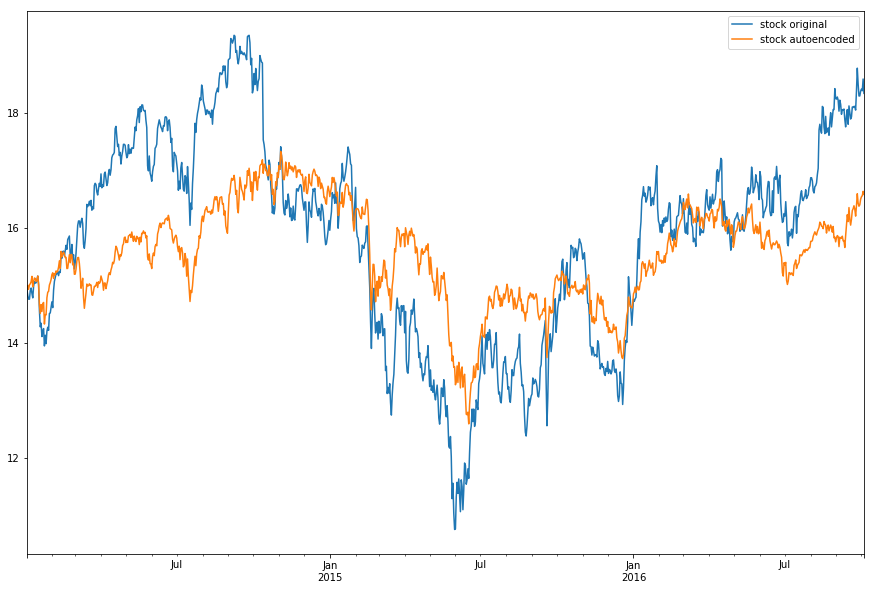

In [6]:
which_stock = 256

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].values, index=pd.date_range(start='2014/1/2', periods=1007, freq='d')).plot(figsize=(15,10),label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='2014/1/2', periods = 1007,freq='d')).plot(label='stock autoencoded', legend=True)

Let's have a look on how well this auto-encoder works on a certain stock.

# Phase 2: Calibrating

In [12]:
np.concatenate((ranking[0:10], ranking[-25:])) 

array([239, 228, 275, 256, 264, 229, 124,  56,  10,   9,  28, 116,  25,
        88, 148,  53, 166,  13,  80, 245, 259, 186,  61, 158,  95, 282,
       238,  43, 237, 253, 224, 164, 247, 159, 179])

In [39]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [70, 160, 250]:  
    # some numerical values
    encoding_dim = 64
    s = 20 + non_communal
    stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,)) # [bs, #stocks]
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img) # [bs, #neurons]
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # [bs, 1]
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler() # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=5000, batch_size = 40)    # fit the model
    deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - ibb['calibrate']['lp']))


Epoch 1/5000
1007/1007 [==============================] - 0s 113us/step - loss: 1.3877
Epoch 2/5000
1007/1007 [==============================] - 0s 49us/step - loss: 1.0285
Epoch 3/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.9347
Epoch 4/5000
1007/1007 [==============================] - 0s 61us/step - loss: 0.8826
Epoch 5/5000
1007/1007 [==============================] - 0s 55us/step - loss: 0.8473
Epoch 6/5000
1007/1007 [==============================] - 0s 75us/step - loss: 0.8206
Epoch 7/5000
1007/1007 [==============================] - 0s 146us/step - loss: 0.7992
Epoch 8/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.7811
Epoch 9/5000
1007/1007 [==============================] - 0s 33us/step - loss: 0.7653
Epoch 10/5000
1007/1007 [==============================] - 0s 32us/step - loss: 0.7513
Epoch 11/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.7384
Epoch 12/5000
1007/1007 [=========================

1007/1007 [==============================] - 0s 47us/step - loss: 0.3028
Epoch 96/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.2999
Epoch 97/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.2970
Epoch 98/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.2942
Epoch 99/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.2914
Epoch 100/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.2887
Epoch 101/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.2859
Epoch 102/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.2832
Epoch 103/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.2805
Epoch 104/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.2779
Epoch 105/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.2753
Epoch 106/5000
1007/1007 [=========================

1007/1007 [==============================] - 0s 40us/step - loss: 0.1322
Epoch 189/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.1311
Epoch 190/5000
1007/1007 [==============================] - 0s 64us/step - loss: 0.1300
Epoch 191/5000
1007/1007 [==============================] - 0s 59us/step - loss: 0.1290
Epoch 192/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.1280
Epoch 193/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1269
Epoch 194/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1259
Epoch 195/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.1249
Epoch 196/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1239
Epoch 197/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1229
Epoch 198/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.1220
Epoch 199/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 49us/step - loss: 0.0692
Epoch 282/5000
1007/1007 [==============================] - 0s 65us/step - loss: 0.0688
Epoch 283/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0684
Epoch 284/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0680
Epoch 285/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0676
Epoch 286/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0673
Epoch 287/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0669
Epoch 288/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0665
Epoch 289/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0662
Epoch 290/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0658
Epoch 291/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0655
Epoch 292/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 50us/step - loss: 0.0465
Epoch 374/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0464
Epoch 375/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0462
Epoch 376/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0461
Epoch 377/5000
1007/1007 [==============================] - 0s 107us/step - loss: 0.0460
Epoch 378/5000
1007/1007 [==============================] - 0s 83us/step - loss: 0.0458
Epoch 379/5000
1007/1007 [==============================] - 0s 78us/step - loss: 0.0457
Epoch 380/5000
1007/1007 [==============================] - 0s 62us/step - loss: 0.0455
Epoch 381/5000
1007/1007 [==============================] - 0s 83us/step - loss: 0.0454
Epoch 382/5000
1007/1007 [==============================] - 0s 66us/step - loss: 0.0453
Epoch 383/5000
1007/1007 [==============================] - 0s 63us/step - loss: 0.0452
Epoch 384/5000
1007/1007 [====================

1007/1007 [==============================] - 0s 37us/step - loss: 0.0380
Epoch 467/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0380
Epoch 468/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0379
Epoch 469/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0379
Epoch 470/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0378
Epoch 471/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0378
Epoch 472/5000
1007/1007 [==============================] - 0s 66us/step - loss: 0.0377
Epoch 473/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0377
Epoch 474/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0376
Epoch 475/5000
1007/1007 [==============================] - 0s 69us/step - loss: 0.0376
Epoch 476/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0375
Epoch 477/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 47us/step - loss: 0.0348
Epoch 560/5000
1007/1007 [==============================] - 0s 61us/step - loss: 0.0348
Epoch 561/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0347
Epoch 562/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0347
Epoch 563/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0347
Epoch 564/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0347
Epoch 565/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0347
Epoch 566/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0346
Epoch 567/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0346
Epoch 568/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0346
Epoch 569/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0346
Epoch 570/5000
1007/1007 [=====================

Epoch 652/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0334
Epoch 653/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0334
Epoch 654/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0334
Epoch 655/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0334
Epoch 656/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0334
Epoch 657/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0334
Epoch 658/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0333
Epoch 659/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0333
Epoch 660/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0333
Epoch 661/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0333
Epoch 662/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0333
Epoch 663/5000
1007/1007 [======

1007/1007 [==============================] - 0s 70us/step - loss: 0.0328
Epoch 746/5000
1007/1007 [==============================] - 0s 98us/step - loss: 0.0328
Epoch 747/5000
1007/1007 [==============================] - 0s 116us/step - loss: 0.0328
Epoch 748/5000
1007/1007 [==============================] - 0s 68us/step - loss: 0.0328
Epoch 749/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0327
Epoch 750/5000
1007/1007 [==============================] - 0s 144us/step - loss: 0.0327
Epoch 751/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0327
Epoch 752/5000
1007/1007 [==============================] - 0s 278us/step - loss: 0.0327
Epoch 753/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0327
Epoch 754/5000
1007/1007 [==============================] - 0s 71us/step - loss: 0.0327
Epoch 755/5000
1007/1007 [==============================] - 0s 108us/step - loss: 0.0327
Epoch 756/5000
1007/1007 [=================

1007/1007 [==============================] - 0s 68us/step - loss: 0.0324
Epoch 839/5000
1007/1007 [==============================] - 0s 71us/step - loss: 0.0324
Epoch 840/5000
1007/1007 [==============================] - 0s 81us/step - loss: 0.0324
Epoch 841/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0324
Epoch 842/5000
1007/1007 [==============================] - 0s 65us/step - loss: 0.0324
Epoch 843/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.032 - 0s 71us/step - loss: 0.0324
Epoch 844/5000
1007/1007 [==============================] - 0s 81us/step - loss: 0.0324
Epoch 845/5000
1007/1007 [==============================] - 0s 84us/step - loss: 0.0324
Epoch 846/5000
1007/1007 [==============================] - 0s 65us/step - loss: 0.0324
Epoch 847/5000
1007/1007 [==============================] - 0s 76us/step - loss: 0.0324
Epoch 848/5000
1007/1007 [==============================] - 0s 61us/step - loss: 0.0324
Epoch 849/5000
1007/100

Epoch 931/5000
1007/1007 [==============================] - 0s 56us/step - loss: 0.0322
Epoch 932/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0322
Epoch 933/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0322
Epoch 934/5000
1007/1007 [==============================] - 0s 129us/step - loss: 0.0322
Epoch 935/5000
1007/1007 [==============================] - 0s 56us/step - loss: 0.0322
Epoch 936/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0322
Epoch 937/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0322
Epoch 938/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0322
Epoch 939/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0322
Epoch 940/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0322
Epoch 941/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0322
Epoch 942/5000
1007/1007 [=====

1007/1007 [==============================] - 0s 37us/step - loss: 0.0321
Epoch 1024/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0321
Epoch 1025/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0321
Epoch 1026/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0321
Epoch 1027/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0321
Epoch 1028/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0321
Epoch 1029/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0321
Epoch 1030/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0321
Epoch 1031/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0321
Epoch 1032/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0321
Epoch 1033/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0321
Epoch 1034/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 36us/step - loss: 0.0320
Epoch 1116/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0320
Epoch 1117/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0320
Epoch 1118/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0320
Epoch 1119/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0320
Epoch 1120/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0320
Epoch 1121/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0320
Epoch 1122/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0320
Epoch 1123/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0320
Epoch 1124/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0320
Epoch 1125/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0320
Epoch 1126/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 37us/step - loss: 0.0319
Epoch 1208/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0319
Epoch 1209/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0319
Epoch 1210/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0319
Epoch 1211/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0319
Epoch 1212/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0319
Epoch 1213/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0319
Epoch 1214/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0319
Epoch 1215/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0319
Epoch 1216/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0319
Epoch 1217/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0319
Epoch 1218/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 39us/step - loss: 0.0318
Epoch 1300/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0318
Epoch 1301/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0318
Epoch 1302/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0318
Epoch 1303/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0318
Epoch 1304/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0318
Epoch 1305/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0318
Epoch 1306/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0318
Epoch 1307/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0318
Epoch 1308/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0318
Epoch 1309/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0318
Epoch 1310/5000
1007/1007 [==========

Epoch 1391/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0318
Epoch 1392/5000
1007/1007 [==============================] - 0s 74us/step - loss: 0.0318
Epoch 1393/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0318
Epoch 1394/5000
1007/1007 [==============================] - 0s 68us/step - loss: 0.0318
Epoch 1395/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0317
Epoch 1396/5000
1007/1007 [==============================] - 0s 100us/step - loss: 0.0318
Epoch 1397/5000
1007/1007 [==============================] - 0s 67us/step - loss: 0.0317
Epoch 1398/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0318
Epoch 1399/5000
1007/1007 [==============================] - 0s 83us/step - loss: 0.0317
Epoch 1400/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0317
Epoch 1401/5000
1007/1007 [==============================] - 0s 68us/step - loss: 0.0317
Epoch 1402/5000
1007

1007/1007 [==============================] - 0s 40us/step - loss: 0.0317
Epoch 1484/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0317
Epoch 1485/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0317
Epoch 1486/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0317
Epoch 1487/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0317
Epoch 1488/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0317
Epoch 1489/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0317
Epoch 1490/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0317
Epoch 1491/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0317
Epoch 1492/5000
1007/1007 [==============================] - 0s 55us/step - loss: 0.0317
Epoch 1493/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0317
Epoch 1494/5000
1007/1007 [==========

Epoch 1575/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0317
Epoch 1576/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0317
Epoch 1577/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0317
Epoch 1578/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0317
Epoch 1579/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0317
Epoch 1580/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0317
Epoch 1581/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0317
Epoch 1582/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0317
Epoch 1583/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0317
Epoch 1584/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0317
Epoch 1585/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0317
Epoch 1586/5000
1007/

1007/1007 [==============================] - 0s 43us/step - loss: 0.0316
Epoch 1668/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0316
Epoch 1669/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0316
Epoch 1670/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0316
Epoch 1671/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0316
Epoch 1672/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0316
Epoch 1673/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0316
Epoch 1674/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0316
Epoch 1675/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0316
Epoch 1676/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0316
Epoch 1677/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0316
Epoch 1678/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 44us/step - loss: 0.0316
Epoch 1760/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0316
Epoch 1761/5000
1007/1007 [==============================] - 0s 55us/step - loss: 0.0316
Epoch 1762/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0316
Epoch 1763/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0316
Epoch 1764/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0316
Epoch 1765/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0316
Epoch 1766/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0316
Epoch 1767/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0316
Epoch 1768/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0316
Epoch 1769/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0316
Epoch 1770/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 43us/step - loss: 0.0315
Epoch 1852/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0315
Epoch 1853/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0315
Epoch 1854/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 1855/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0315
Epoch 1856/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 1857/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0315
Epoch 1858/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 1859/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0315
Epoch 1860/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 1861/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0315
Epoch 1862/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 42us/step - loss: 0.0315
Epoch 1944/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 1945/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0315
Epoch 1946/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 1947/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0315
Epoch 1948/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 1949/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0315
Epoch 1950/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 1951/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0315
Epoch 1952/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0315
Epoch 1953/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0315
Epoch 1954/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 50us/step - loss: 0.0315
Epoch 2036/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0315
Epoch 2037/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0315
Epoch 2038/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0315
Epoch 2039/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0315
Epoch 2040/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0315
Epoch 2041/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 2042/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0315
Epoch 2043/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0315
Epoch 2044/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 2045/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 2046/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 78us/step - loss: 0.0315
Epoch 2128/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.030 - 0s 48us/step - loss: 0.0315
Epoch 2129/5000
1007/1007 [==============================] - 0s 73us/step - loss: 0.0315
Epoch 2130/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0315
Epoch 2131/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0315
Epoch 2132/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0315
Epoch 2133/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0315
Epoch 2134/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0314
Epoch 2135/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0314
Epoch 2136/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0315
Epoch 2137/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0315
Epoch 2138/50

Epoch 2219/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0314
Epoch 2220/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0314
Epoch 2221/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0314
Epoch 2222/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0314
Epoch 2223/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0314
Epoch 2224/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0314
Epoch 2225/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0314
Epoch 2226/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0314
Epoch 2227/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0314
Epoch 2228/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0314
Epoch 2229/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0314
Epoch 2230/5000
1007/

1007/1007 [==============================] - 0s 42us/step - loss: 0.0314
Epoch 2312/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0314
Epoch 2313/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0314
Epoch 2314/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0314
Epoch 2315/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0314
Epoch 2316/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0314
Epoch 2317/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0314
Epoch 2318/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0314
Epoch 2319/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0314
Epoch 2320/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0314
Epoch 2321/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0314
Epoch 2322/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 42us/step - loss: 0.0314
Epoch 2403/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0314
Epoch 2404/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0314
Epoch 2405/5000
1007/1007 [==============================] - 0s 32us/step - loss: 0.0314
Epoch 2406/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0314
Epoch 2407/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0314
Epoch 2408/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0314
Epoch 2409/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0314
Epoch 2410/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0314
Epoch 2411/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0314
Epoch 2412/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0314
Epoch 2413/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 48us/step - loss: 0.0314
Epoch 2495/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0314
Epoch 2496/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0314
Epoch 2497/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0314
Epoch 2498/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0314
Epoch 2499/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0314
Epoch 2500/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0314
Epoch 2501/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0314
Epoch 2502/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0314
Epoch 2503/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0314
Epoch 2504/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0314
Epoch 2505/5000
1007/1007 [==========

Epoch 2586/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0313
Epoch 2587/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0313
Epoch 2588/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0313
Epoch 2589/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0313
Epoch 2590/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.030 - 0s 39us/step - loss: 0.0313
Epoch 2591/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0313
Epoch 2592/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0313
Epoch 2593/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0313
Epoch 2594/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0313
Epoch 2595/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0313
Epoch 2596/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.03

1007/1007 [==============================] - 0s 37us/step - loss: 0.0313
Epoch 2678/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0313
Epoch 2679/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0313
Epoch 2680/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0313
Epoch 2681/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0313
Epoch 2682/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0313
Epoch 2683/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0313
Epoch 2684/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0313
Epoch 2685/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0313
Epoch 2686/5000
1007/1007 [==============================] - 0s 55us/step - loss: 0.0313
Epoch 2687/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0313
Epoch 2688/5000
1007/1007 [==========

1007/1007 [==============================] - ETA: 0s - loss: 0.030 - 0s 46us/step - loss: 0.0313
Epoch 2770/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0313
Epoch 2771/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0313
Epoch 2772/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0313
Epoch 2773/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0313
Epoch 2774/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0313
Epoch 2775/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0313
Epoch 2776/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0313
Epoch 2777/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0313
Epoch 2778/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0313
Epoch 2779/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0313
Epoch 2780/50

1007/1007 [==============================] - 0s 46us/step - loss: 0.0313
Epoch 2861/5000
1007/1007 [==============================] - 0s 72us/step - loss: 0.0313
Epoch 2862/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0313
Epoch 2863/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0313
Epoch 2864/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0313
Epoch 2865/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0313
Epoch 2866/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0313
Epoch 2867/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0313
Epoch 2868/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0313
Epoch 2869/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0313
Epoch 2870/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0313
Epoch 2871/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 42us/step - loss: 0.0312
Epoch 2953/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0312
Epoch 2954/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0312
Epoch 2955/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0312
Epoch 2956/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0312
Epoch 2957/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0312
Epoch 2958/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0312
Epoch 2959/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0312
Epoch 2960/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0312
Epoch 2961/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0312
Epoch 2962/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0312
Epoch 2963/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 39us/step - loss: 0.0312
Epoch 3045/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0312
Epoch 3046/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0312
Epoch 3047/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0312
Epoch 3048/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0312
Epoch 3049/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0312
Epoch 3050/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0312
Epoch 3051/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0312
Epoch 3052/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0312
Epoch 3053/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0312
Epoch 3054/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0312
Epoch 3055/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 46us/step - loss: 0.0312
Epoch 3137/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0312
Epoch 3138/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0312
Epoch 3139/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0312
Epoch 3140/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0312
Epoch 3141/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0312
Epoch 3142/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0312
Epoch 3143/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0312
Epoch 3144/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0312
Epoch 3145/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0312
Epoch 3146/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0312
Epoch 3147/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 40us/step - loss: 0.0312
Epoch 3229/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0312
Epoch 3230/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0312
Epoch 3231/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0312
Epoch 3232/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0312
Epoch 3233/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0312
Epoch 3234/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0312
Epoch 3235/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0312
Epoch 3236/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0312
Epoch 3237/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0312
Epoch 3238/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0312
Epoch 3239/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 57us/step - loss: 0.0312
Epoch 3321/5000
1007/1007 [==============================] - 0s 220us/step - loss: 0.0312
Epoch 3322/5000
1007/1007 [==============================] - 0s 62us/step - loss: 0.0312
Epoch 3323/5000
1007/1007 [==============================] - 0s 56us/step - loss: 0.0312
Epoch 3324/5000
1007/1007 [==============================] - 0s 81us/step - loss: 0.0312
Epoch 3325/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0312
Epoch 3326/5000
1007/1007 [==============================] - 0s 88us/step - loss: 0.0312
Epoch 3327/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0312
Epoch 3328/5000
1007/1007 [==============================] - 0s 67us/step - loss: 0.0312
Epoch 3329/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0312
Epoch 3330/5000
1007/1007 [==============================] - 0s 85us/step - loss: 0.0312
Epoch 3331/5000
1007/1007 [=========

Epoch 3412/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0311
Epoch 3413/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 3414/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 3415/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0311
Epoch 3416/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 3417/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 3418/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 3419/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3420/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0311
Epoch 3421/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3422/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0311
Epoch 3423/5000
1007/

1007/1007 [==============================] - 0s 35us/step - loss: 0.0311
Epoch 3505/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0311
Epoch 3506/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 3507/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 3508/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0311
Epoch 3509/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0311
Epoch 3510/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3511/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 3512/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3513/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0311
Epoch 3514/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0311
Epoch 3515/5000
1007/1007 [==========

Epoch 3596/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0311
Epoch 3597/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0311
Epoch 3598/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0311
Epoch 3599/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0311
Epoch 3600/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0311
Epoch 3601/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0311
Epoch 3602/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3603/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 3604/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3605/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 3606/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3607/5000
1007/

1007/1007 [==============================] - 0s 36us/step - loss: 0.0311
Epoch 3689/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0311
Epoch 3690/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0311
Epoch 3691/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 3692/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0311
Epoch 3693/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0311
Epoch 3694/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3695/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0311
Epoch 3696/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0311
Epoch 3697/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.030 - 0s 35us/step - loss: 0.0311
Epoch 3698/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0311
Epoch 3699/50

Epoch 3780/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0311
Epoch 3781/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0311
Epoch 3782/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0311
Epoch 3783/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0311
Epoch 3784/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0311
Epoch 3785/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0311
Epoch 3786/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0311
Epoch 3787/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0311
Epoch 3788/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0311
Epoch 3789/5000
1007/1007 [==============================] - 0s 243us/step - loss: 0.0311
Epoch 3790/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0311
Epoch 3791/5000
1007

/usr/local/opt/pyenv/versions/3.6.0/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/usr/local/opt/pyenv/versions/3.6.0/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1007/1007 [==============================] - 0s 77us/step - loss: 0.0311
Epoch 3793/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0311
Epoch 3794/5000
1007/1007 [==============================] - 0s 67us/step - loss: 0.0311
Epoch 3795/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0311
Epoch 3796/5000
1007/1007 [==============================] - 0s 67us/step - loss: 0.0311
Epoch 3797/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0311
Epoch 3798/5000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0311
Epoch 3799/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0311
Epoch 3800/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0311
Epoch 3801/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0311
Epoch 3802/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0311
Epoch 3803/5000
1007/1007 [==========

Epoch 3884/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0311
Epoch 3885/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0311
Epoch 3886/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0311
Epoch 3887/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0311
Epoch 3888/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0311
Epoch 3889/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0311
Epoch 3890/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0311
Epoch 3891/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 3892/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3893/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 3894/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3895/5000
1007/

1007/1007 [==============================] - 0s 35us/step - loss: 0.0311
Epoch 3977/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0311
Epoch 3978/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 3979/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 3980/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0311
Epoch 3981/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0311
Epoch 3982/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0311
Epoch 3983/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0311
Epoch 3984/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 3985/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0311
Epoch 3986/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 3987/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 41us/step - loss: 0.0311
Epoch 4069/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 4070/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0311
Epoch 4071/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0311
Epoch 4072/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 4073/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 4074/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0311
Epoch 4075/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0311
Epoch 4076/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0311
Epoch 4077/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0311
Epoch 4078/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 4079/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 49us/step - loss: 0.0311
Epoch 4161/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0311
Epoch 4162/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 4163/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0311
Epoch 4164/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 4165/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0311
Epoch 4166/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0311
Epoch 4167/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0311
Epoch 4168/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 4169/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0311
Epoch 4170/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0311
Epoch 4171/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 39us/step - loss: 0.0311
Epoch 4253/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0311
Epoch 4254/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0311
Epoch 4255/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0311
Epoch 4256/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0310
Epoch 4257/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0311
Epoch 4258/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0311
Epoch 4259/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0311
Epoch 4260/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0311
Epoch 4261/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0310
Epoch 4262/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.031 - 0s 55us/step - loss: 0.0311
Epoch 4263/50

1007/1007 [==============================] - 0s 44us/step - loss: 0.0310
Epoch 4344/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0310
Epoch 4345/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4346/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0310
Epoch 4347/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0310
Epoch 4348/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0310
Epoch 4349/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4350/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0310
Epoch 4351/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4352/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0310
Epoch 4353/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0310
Epoch 4354/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4436/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0310
Epoch 4437/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0310
Epoch 4438/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0310
Epoch 4439/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4440/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0310
Epoch 4441/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0310
Epoch 4442/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4443/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0310
Epoch 4444/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0310
Epoch 4445/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0310
Epoch 4446/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 50us/step - loss: 0.0310
Epoch 4528/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0310
Epoch 4529/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0310
Epoch 4530/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0310
Epoch 4531/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0310
Epoch 4532/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0310
Epoch 4533/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0310
Epoch 4534/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0310
Epoch 4535/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0310
Epoch 4536/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0310
Epoch 4537/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0310
Epoch 4538/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 45us/step - loss: 0.0310
Epoch 4620/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4621/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4622/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4623/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0310
Epoch 4624/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0310
Epoch 4625/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0310
Epoch 4626/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0310
Epoch 4627/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0310
Epoch 4628/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4629/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4630/5000
1007/1007 [==========

Epoch 4711/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4712/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0310
Epoch 4713/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4714/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4715/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0310
Epoch 4716/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0310
Epoch 4717/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4718/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0310
Epoch 4719/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0310
Epoch 4720/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0310
Epoch 4721/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0310
Epoch 4722/5000
1007/

1007/1007 [==============================] - 0s 48us/step - loss: 0.0310
Epoch 4804/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4805/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0310
Epoch 4806/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0310
Epoch 4807/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0310
Epoch 4808/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4809/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4810/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0310
Epoch 4811/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4812/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0310
Epoch 4813/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4814/5000
1007/1007 [==========

Epoch 4895/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0310
Epoch 4896/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4897/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4898/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4899/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4900/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4901/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4902/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4903/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4904/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0310
Epoch 4905/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4906/5000
1007/

1007/1007 [==============================] - 0s 86us/step - loss: 0.0310
Epoch 4988/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0310
Epoch 4989/5000
1007/1007 [==============================] - 0s 73us/step - loss: 0.0310
Epoch 4990/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4991/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0310
Epoch 4992/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4993/5000
1007/1007 [==============================] - 0s 54us/step - loss: 0.0310
Epoch 4994/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0310
Epoch 4995/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0310
Epoch 4996/5000
1007/1007 [==============================] - 0s 54us/step - loss: 0.0310
Epoch 4997/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0310
Epoch 4998/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 48us/step - loss: 0.4175
Epoch 81/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.4133
Epoch 82/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.4091
Epoch 83/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.4050
Epoch 84/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.4009
Epoch 85/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.3969
Epoch 86/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.3929
Epoch 87/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.3889
Epoch 88/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.3850
Epoch 89/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.3811
Epoch 90/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.3773
Epoch 91/5000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 72us/step - loss: 0.1672
Epoch 174/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.1656
Epoch 175/5000
1007/1007 [==============================] - 0s 60us/step - loss: 0.1641
Epoch 176/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.1625
Epoch 177/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.1610
Epoch 178/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.1595
Epoch 179/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.1580
Epoch 180/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.1565
Epoch 181/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.1551
Epoch 182/5000
1007/1007 [==============================] - 0s 63us/step - loss: 0.1536
Epoch 183/5000
1007/1007 [==============================] - 0s 54us/step - loss: 0.1522
Epoch 184/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 43us/step - loss: 0.0737
Epoch 267/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0731
Epoch 268/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0726
Epoch 269/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0720
Epoch 270/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0714
Epoch 271/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0709
Epoch 272/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0703
Epoch 273/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0698
Epoch 274/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0692
Epoch 275/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0687
Epoch 276/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0681
Epoch 277/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 38us/step - loss: 0.0390
Epoch 360/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0388
Epoch 361/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0386
Epoch 362/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0384
Epoch 363/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0381
Epoch 364/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0379
Epoch 365/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0377
Epoch 366/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0375
Epoch 367/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0373
Epoch 368/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0371
Epoch 369/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0369
Epoch 370/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 47us/step - loss: 0.0261
Epoch 453/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0260
Epoch 454/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0259
Epoch 455/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0258
Epoch 456/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0257
Epoch 457/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0257
Epoch 458/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0256
Epoch 459/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0255
Epoch 460/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0254
Epoch 461/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0254
Epoch 462/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0253
Epoch 463/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 46us/step - loss: 0.0212
Epoch 546/5000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0211
Epoch 547/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0211
Epoch 548/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0211
Epoch 549/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0210
Epoch 550/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0210
Epoch 551/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0210
Epoch 552/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0210
Epoch 553/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0209
Epoch 554/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0209
Epoch 555/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0209
Epoch 556/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 40us/step - loss: 0.0193
Epoch 639/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0192
Epoch 640/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0192
Epoch 641/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0192
Epoch 642/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0192
Epoch 643/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0192
Epoch 644/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0192
Epoch 645/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0192
Epoch 646/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0192
Epoch 647/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0191
Epoch 648/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0191
Epoch 649/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 39us/step - loss: 0.0184
Epoch 732/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0184
Epoch 733/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0184
Epoch 734/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0184
Epoch 735/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0184
Epoch 736/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0184
Epoch 737/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0184
Epoch 738/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0184
Epoch 739/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0184
Epoch 740/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0184
Epoch 741/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0184
Epoch 742/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 45us/step - loss: 0.0180
Epoch 825/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0180
Epoch 826/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0180
Epoch 827/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0180
Epoch 828/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0180
Epoch 829/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0180
Epoch 830/5000
1007/1007 [==============================] - 0s 58us/step - loss: 0.0180
Epoch 831/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0180
Epoch 832/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0180
Epoch 833/5000
1007/1007 [==============================] - 0s 62us/step - loss: 0.0180
Epoch 834/5000
1007/1007 [==============================] - 0s 62us/step - loss: 0.0180
Epoch 835/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 41us/step - loss: 0.0178
Epoch 918/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0178
Epoch 919/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0178
Epoch 920/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0178
Epoch 921/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0178
Epoch 922/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0178
Epoch 923/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0178
Epoch 924/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0178
Epoch 925/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0178
Epoch 926/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0178
Epoch 927/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0178
Epoch 928/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 48us/step - loss: 0.0177
Epoch 1011/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0177
Epoch 1012/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0177
Epoch 1013/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0177
Epoch 1014/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0177
Epoch 1015/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0176
Epoch 1016/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0176
Epoch 1017/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0176
Epoch 1018/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0176
Epoch 1019/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0176
Epoch 1020/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0176
Epoch 1021/5000
1007/1007 [==========

/usr/local/opt/pyenv/versions/3.6.0/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1007/1007 [==============================] - 0s 95us/step - loss: 0.0176
Epoch 1072/5000
1007/1007 [==============================] - 0s 81us/step - loss: 0.0176
Epoch 1073/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0176
Epoch 1074/5000
1007/1007 [==============================] - 0s 85us/step - loss: 0.0176
Epoch 1075/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0176
Epoch 1076/5000
1007/1007 [==============================] - 0s 70us/step - loss: 0.0176
Epoch 1077/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0176
Epoch 1078/5000
1007/1007 [==============================] - 0s 95us/step - loss: 0.0176
Epoch 1079/5000
1007/1007 [==============================] - 0s 64us/step - loss: 0.0176
Epoch 1080/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0176
Epoch 1081/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0176
Epoch 1082/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 46us/step - loss: 0.0175
Epoch 1164/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0175
Epoch 1165/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0175
Epoch 1166/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0175
Epoch 1167/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0175
Epoch 1168/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0175
Epoch 1169/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0175
Epoch 1170/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0175
Epoch 1171/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0175
Epoch 1172/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0175
Epoch 1173/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0175
Epoch 1174/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 50us/step - loss: 0.0175
Epoch 1256/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0175
Epoch 1257/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0175
Epoch 1258/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0175
Epoch 1259/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0175
Epoch 1260/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0175
Epoch 1261/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0175
Epoch 1262/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0175
Epoch 1263/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0175
Epoch 1264/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0175
Epoch 1265/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0175
Epoch 1266/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 47us/step - loss: 0.0174
Epoch 1348/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0174
Epoch 1349/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0174
Epoch 1350/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0174
Epoch 1351/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0174
Epoch 1352/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0174
Epoch 1353/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0174
Epoch 1354/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0174
Epoch 1355/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0174
Epoch 1356/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0174
Epoch 1357/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0174
Epoch 1358/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 39us/step - loss: 0.0174
Epoch 1440/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0174
Epoch 1441/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0174
Epoch 1442/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0174
Epoch 1443/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0174
Epoch 1444/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0174
Epoch 1445/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0174
Epoch 1446/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0174
Epoch 1447/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0174
Epoch 1448/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0174
Epoch 1449/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0174
Epoch 1450/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 44us/step - loss: 0.0173
Epoch 1531/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0173
Epoch 1532/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0173
Epoch 1533/5000
1007/1007 [==============================] - 0s 54us/step - loss: 0.0173
Epoch 1534/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0173
Epoch 1535/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0173
Epoch 1536/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0173
Epoch 1537/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0173
Epoch 1538/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0173
Epoch 1539/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0173
Epoch 1540/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0173
Epoch 1541/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 48us/step - loss: 0.0173
Epoch 1623/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0173
Epoch 1624/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0173
Epoch 1625/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0173
Epoch 1626/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0173
Epoch 1627/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0173
Epoch 1628/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0173
Epoch 1629/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0173
Epoch 1630/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0173
Epoch 1631/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0173
Epoch 1632/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0173
Epoch 1633/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 43us/step - loss: 0.0173
Epoch 1715/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0173
Epoch 1716/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0173
Epoch 1717/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0173
Epoch 1718/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0173
Epoch 1719/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0173
Epoch 1720/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0173
Epoch 1721/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0173
Epoch 1722/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0173
Epoch 1723/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0173
Epoch 1724/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0173
Epoch 1725/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 39us/step - loss: 0.0173
Epoch 1807/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0173
Epoch 1808/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0173
Epoch 1809/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0173
Epoch 1810/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0173
Epoch 1811/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0173
Epoch 1812/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0173
Epoch 1813/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0173
Epoch 1814/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0173
Epoch 1815/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0173
Epoch 1816/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0173
Epoch 1817/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 1899/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0172
Epoch 1900/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 1901/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0172
Epoch 1902/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 1903/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 1904/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0172
Epoch 1905/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0172
Epoch 1906/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0172
Epoch 1907/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 1908/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 1909/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 75us/step - loss: 0.0172
Epoch 1991/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0172
Epoch 1992/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0172
Epoch 1993/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0172
Epoch 1994/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0172
Epoch 1995/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0172
Epoch 1996/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0172
Epoch 1997/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0172
Epoch 1998/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0172
Epoch 1999/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0172
Epoch 2000/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0172
Epoch 2001/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 2083/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 2084/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 2085/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 2086/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0172
Epoch 2087/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 2088/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 2089/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0172
Epoch 2090/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0172
Epoch 2091/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0172
Epoch 2092/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 2093/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 2175/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 2176/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0172
Epoch 2177/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0172
Epoch 2178/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0172
Epoch 2179/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0172
Epoch 2180/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0172
Epoch 2181/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 2182/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0172
Epoch 2183/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0172
Epoch 2184/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0172
Epoch 2185/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 43us/step - loss: 0.0172
Epoch 2267/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0172
Epoch 2268/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0172
Epoch 2269/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 2270/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0172
Epoch 2271/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 2272/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 2273/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 2274/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0172
Epoch 2275/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 2276/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0172
Epoch 2277/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 2359/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 2360/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0172
Epoch 2361/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0172
Epoch 2362/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0172
Epoch 2363/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0172
Epoch 2364/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 2365/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0172
Epoch 2366/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 2367/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0172
Epoch 2368/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0172
Epoch 2369/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 49us/step - loss: 0.0172
Epoch 2451/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0172
Epoch 2452/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0172
Epoch 2453/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0171
Epoch 2454/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 2455/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0172
Epoch 2456/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0171
Epoch 2457/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0172
Epoch 2458/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 2459/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 2460/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 2461/5000
1007/1007 [==========

Epoch 2542/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0171
Epoch 2543/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0171
Epoch 2544/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 2545/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0171
Epoch 2546/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0171
Epoch 2547/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 2548/5000
1007/1007 [==============================] - 0s 62us/step - loss: 0.0171
Epoch 2549/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 2550/5000
1007/1007 [==============================] - 0s 64us/step - loss: 0.0171
Epoch 2551/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0171
Epoch 2552/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0171
Epoch 2553/5000
1007/

1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 2635/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 2636/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0171
Epoch 2637/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0171
Epoch 2638/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 2639/5000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0171
Epoch 2640/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 2641/5000
1007/1007 [==============================] - 0s 54us/step - loss: 0.0171
Epoch 2642/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0171
Epoch 2643/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0171
Epoch 2644/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 2645/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 2727/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0171
Epoch 2728/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0171
Epoch 2729/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 2730/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 2731/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0171
Epoch 2732/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0171
Epoch 2733/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 2734/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0171
Epoch 2735/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0171
Epoch 2736/5000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0171
Epoch 2737/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 2819/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0171
Epoch 2820/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 2821/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 2822/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 2823/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 2824/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0171
Epoch 2825/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 2826/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 2827/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 2828/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 2829/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 2911/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 2912/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 2913/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 2914/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 2915/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0171
Epoch 2916/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 2917/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 2918/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 2919/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0171
Epoch 2920/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 2921/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 41us/step - loss: 0.0171
Epoch 3003/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 3004/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 3005/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 3006/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0171
Epoch 3007/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0171
Epoch 3008/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 3009/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3010/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3011/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3012/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 3013/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 74us/step - loss: 0.0171
Epoch 3095/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0171
Epoch 3096/5000
1007/1007 [==============================] - 0s 87us/step - loss: 0.0171
Epoch 3097/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0171
Epoch 3098/5000
1007/1007 [==============================] - 0s 84us/step - loss: 0.0171
Epoch 3099/5000
1007/1007 [==============================] - 0s 85us/step - loss: 0.0171
Epoch 3100/5000
1007/1007 [==============================] - 0s 58us/step - loss: 0.0171
Epoch 3101/5000
1007/1007 [==============================] - 0s 85us/step - loss: 0.0171
Epoch 3102/5000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0171
Epoch 3103/5000
1007/1007 [==============================] - 0s 91us/step - loss: 0.0171
Epoch 3104/5000
1007/1007 [==============================] - 0s 75us/step - loss: 0.0171
Epoch 3105/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 48us/step - loss: 0.0171
Epoch 3187/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 3188/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0171
Epoch 3189/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0171
Epoch 3190/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 3191/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 3192/5000
1007/1007 [==============================] - 0s 63us/step - loss: 0.0171
Epoch 3193/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0171
Epoch 3194/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0171
Epoch 3195/5000
1007/1007 [==============================] - 0s 72us/step - loss: 0.0171
Epoch 3196/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0171
Epoch 3197/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 57us/step - loss: 0.0171
Epoch 3279/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0171
Epoch 3280/5000
1007/1007 [==============================] - 0s 72us/step - loss: 0.0171
Epoch 3281/5000
1007/1007 [==============================] - 0s 59us/step - loss: 0.0171
Epoch 3282/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0171
Epoch 3283/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0171
Epoch 3284/5000
1007/1007 [==============================] - 0s 60us/step - loss: 0.0171
Epoch 3285/5000
1007/1007 [==============================] - 0s 63us/step - loss: 0.0171
Epoch 3286/5000
1007/1007 [==============================] - 0s 83us/step - loss: 0.0171
Epoch 3287/5000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0171
Epoch 3288/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0171
Epoch 3289/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 3371/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 3372/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3373/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 3374/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 3375/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3376/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0171
Epoch 3377/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 3378/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 3379/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3380/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 3381/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 40us/step - loss: 0.0171
Epoch 3463/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 3464/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 3465/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3466/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 3467/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0171
Epoch 3468/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0171
Epoch 3469/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 3470/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0171
Epoch 3471/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0171
Epoch 3472/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0171
Epoch 3473/5000
1007/1007 [==========

Epoch 3554/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0171
Epoch 3555/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0171
Epoch 3556/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0171
Epoch 3557/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 3558/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0171
Epoch 3559/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3560/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3561/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 3562/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 3563/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0171
Epoch 3564/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 3565/5000
1007/

1007/1007 [==============================] - 0s 41us/step - loss: 0.0171
Epoch 3647/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0171
Epoch 3648/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 3649/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0171
Epoch 3650/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3651/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3652/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3653/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0171
Epoch 3654/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0171
Epoch 3655/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0171
Epoch 3656/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0171
Epoch 3657/5000
1007/1007 [==========

Epoch 3738/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0170
Epoch 3739/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0170
Epoch 3740/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 3741/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0170
Epoch 3742/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0170
Epoch 3743/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0170
Epoch 3744/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0170
Epoch 3745/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 3746/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 3747/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 3748/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0170
Epoch 3749/5000
1007/

1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 3830/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0170
Epoch 3831/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0170
Epoch 3832/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 3833/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 3834/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0170
Epoch 3835/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0170
Epoch 3836/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 3837/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0170
Epoch 3838/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0170
Epoch 3839/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0170
Epoch 3840/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 141us/step - loss: 0.0170
Epoch 3922/5000
1007/1007 [==============================] - 0s 74us/step - loss: 0.0170
Epoch 3923/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0170
Epoch 3924/5000
1007/1007 [==============================] - 0s 90us/step - loss: 0.0170
Epoch 3925/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0170
Epoch 3926/5000
1007/1007 [==============================] - 0s 80us/step - loss: 0.0170
Epoch 3927/5000
1007/1007 [==============================] - 0s 73us/step - loss: 0.0170
Epoch 3928/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0170
Epoch 3929/5000
1007/1007 [==============================] - 0s 65us/step - loss: 0.0170
Epoch 3930/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0170
Epoch 3931/5000
1007/1007 [==============================] - 0s 78us/step - loss: 0.0170
Epoch 3932/5000
1007/1007 [=========

1007/1007 [==============================] - 0s 38us/step - loss: 0.0170
Epoch 4014/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0170
Epoch 4015/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0170
Epoch 4016/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4017/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0170
Epoch 4018/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0170
Epoch 4019/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0170
Epoch 4020/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0170
Epoch 4021/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4022/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4023/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0170
Epoch 4024/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 88us/step - loss: 0.0170
Epoch 4106/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0170
Epoch 4107/5000
1007/1007 [==============================] - 0s 147us/step - loss: 0.0170
Epoch 4108/5000
1007/1007 [==============================] - 0s 97us/step - loss: 0.0170
Epoch 4109/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4110/5000
1007/1007 [==============================] - 0s 98us/step - loss: 0.0170
Epoch 4111/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0170
Epoch 4112/5000
1007/1007 [==============================] - 0s 90us/step - loss: 0.0170
Epoch 4113/5000
1007/1007 [==============================] - 0s 76us/step - loss: 0.0170
Epoch 4114/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0170
Epoch 4115/5000
1007/1007 [==============================] - 0s 87us/step - loss: 0.0170
Epoch 4116/5000
1007/1007 [=========

1007/1007 [==============================] - 0s 41us/step - loss: 0.0170
Epoch 4198/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0170
Epoch 4199/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0170
Epoch 4200/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0170
Epoch 4201/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4202/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0170
Epoch 4203/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4204/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0170
Epoch 4205/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4206/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0170
Epoch 4207/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0170
Epoch 4208/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4290/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0170
Epoch 4291/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0170
Epoch 4292/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0170
Epoch 4293/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4294/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0170
Epoch 4295/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4296/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0170
Epoch 4297/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0170
Epoch 4298/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0170
Epoch 4299/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4300/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4382/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0170
Epoch 4383/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4384/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4385/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0170
Epoch 4386/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0170
Epoch 4387/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4388/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4389/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0170
Epoch 4390/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0170
Epoch 4391/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0170
Epoch 4392/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 50us/step - loss: 0.0170
Epoch 4474/5000
1007/1007 [==============================] - 0s 59us/step - loss: 0.0170
Epoch 4475/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4476/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4477/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0170
Epoch 4478/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0170
Epoch 4479/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4480/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0170
Epoch 4481/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4482/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4483/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0170
Epoch 4484/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4566/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0170
Epoch 4567/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4568/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0170
Epoch 4569/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4570/5000
1007/1007 [==============================] - 0s 74us/step - loss: 0.0170
Epoch 4571/5000
1007/1007 [==============================] - 0s 59us/step - loss: 0.0170
Epoch 4572/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0170
Epoch 4573/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0170
Epoch 4574/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0170
Epoch 4575/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4576/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 39us/step - loss: 0.0170
Epoch 4658/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0170
Epoch 4659/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4660/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0170
Epoch 4661/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0170
Epoch 4662/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4663/5000
1007/1007 [==============================] - 0s 55us/step - loss: 0.0170
Epoch 4664/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4665/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4666/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4667/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0170
Epoch 4668/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 51us/step - loss: 0.0170
Epoch 4750/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0170
Epoch 4751/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0170
Epoch 4752/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0170
Epoch 4753/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0170
Epoch 4754/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0170
Epoch 4755/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4756/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0170
Epoch 4757/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0170
Epoch 4758/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4759/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4760/5000
1007/1007 [==========

Epoch 4841/5000
1007/1007 [==============================] - 0s 62us/step - loss: 0.0170
Epoch 4842/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0170
Epoch 4843/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0170
Epoch 4844/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0170
Epoch 4845/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0170
Epoch 4846/5000
1007/1007 [==============================] - 0s 54us/step - loss: 0.0170
Epoch 4847/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0170
Epoch 4848/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0170
Epoch 4849/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0170
Epoch 4850/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0170
Epoch 4851/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0170
Epoch 4852/5000
1007/

1007/1007 [==============================] - 0s 62us/step - loss: 0.0170
Epoch 4934/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0170
Epoch 4935/5000
1007/1007 [==============================] - 0s 82us/step - loss: 0.0170
Epoch 4936/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0170
Epoch 4937/5000
1007/1007 [==============================] - 0s 64us/step - loss: 0.0170
Epoch 4938/5000
1007/1007 [==============================] - 0s 56us/step - loss: 0.0170
Epoch 4939/5000
1007/1007 [==============================] - 0s 91us/step - loss: 0.0170
Epoch 4940/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0170
Epoch 4941/5000
1007/1007 [==============================] - 0s 71us/step - loss: 0.0170
Epoch 4942/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0170
Epoch 4943/5000
1007/1007 [==============================] - 0s 77us/step - loss: 0.0170
Epoch 4944/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 55us/step - loss: 0.8089
Epoch 26/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.7999
Epoch 27/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.7911
Epoch 28/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.7824
Epoch 29/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.7739
Epoch 30/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.7655
Epoch 31/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.7572
Epoch 32/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.7490
Epoch 33/5000
1007/1007 [==============================] - 0s 62us/step - loss: 0.7410
Epoch 34/5000
1007/1007 [==============================] - 0s 67us/step - loss: 0.7331
Epoch 35/5000
1007/1007 [==============================] - 0s 60us/step - loss: 0.7253
Epoch 36/5000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 50us/step - loss: 0.3059
Epoch 120/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.3029
Epoch 121/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.2998
Epoch 122/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.2968
Epoch 123/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.2939
Epoch 124/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.2909
Epoch 125/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.2880
Epoch 126/5000
1007/1007 [==============================] - 0s 67us/step - loss: 0.2852
Epoch 127/5000
1007/1007 [==============================] - 0s 64us/step - loss: 0.2823
Epoch 128/5000
1007/1007 [==============================] - 0s 63us/step - loss: 0.2795
Epoch 129/5000
1007/1007 [==============================] - 0s 67us/step - loss: 0.2767
Epoch 130/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 52us/step - loss: 0.1237
Epoch 213/5000
1007/1007 [==============================] - 0s 61us/step - loss: 0.1225
Epoch 214/5000
1007/1007 [==============================] - 0s 56us/step - loss: 0.1214
Epoch 215/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.1203
Epoch 216/5000
1007/1007 [==============================] - 0s 59us/step - loss: 0.1192
Epoch 217/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.1181
Epoch 218/5000
1007/1007 [==============================] - 0s 63us/step - loss: 0.1170
Epoch 219/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.1159
Epoch 220/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.1148
Epoch 221/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.1138
Epoch 222/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.1127
Epoch 223/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 49us/step - loss: 0.0551
Epoch 306/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0547
Epoch 307/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0543
Epoch 308/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0538
Epoch 309/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0534
Epoch 310/5000
1007/1007 [==============================] - 0s 61us/step - loss: 0.0530
Epoch 311/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0526
Epoch 312/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0522
Epoch 313/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0518
Epoch 314/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0514
Epoch 315/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0510
Epoch 316/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 51us/step - loss: 0.0293
Epoch 399/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0291
Epoch 400/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0289
Epoch 401/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0288
Epoch 402/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0286
Epoch 403/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0285
Epoch 404/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0283
Epoch 405/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0282
Epoch 406/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0280
Epoch 407/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0279
Epoch 408/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0277
Epoch 409/5000
1007/1007 [=====================

Epoch 491/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0195
Epoch 492/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0194
Epoch 493/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0194
Epoch 494/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0193
Epoch 495/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0193
Epoch 496/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0192
Epoch 497/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0191
Epoch 498/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0191
Epoch 499/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0190
Epoch 500/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0190
Epoch 501/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0189
Epoch 502/5000
1007/1007 [======

1007/1007 [==============================] - ETA: 0s - loss: 0.016 - 0s 53us/step - loss: 0.0158
Epoch 585/5000
1007/1007 [==============================] - 0s 56us/step - loss: 0.0157
Epoch 586/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0157
Epoch 587/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0157
Epoch 588/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0157
Epoch 589/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0156
Epoch 590/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0156
Epoch 591/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0156
Epoch 592/5000
1007/1007 [==============================] - 0s 68us/step - loss: 0.0156
Epoch 593/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0156
Epoch 594/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0155
Epoch 595/5000
1007/100

1007/1007 [==============================] - 0s 53us/step - loss: 0.0143
Epoch 677/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0143
Epoch 678/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0143
Epoch 679/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0143
Epoch 680/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0143
Epoch 681/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0143
Epoch 682/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0142
Epoch 683/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0142
Epoch 684/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0142
Epoch 685/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0142
Epoch 686/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0142
Epoch 687/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 51us/step - loss: 0.0137
Epoch 770/5000
1007/1007 [==============================] - 0s 60us/step - loss: 0.0137
Epoch 771/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0136
Epoch 772/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0136
Epoch 773/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0136
Epoch 774/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0136
Epoch 775/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0136
Epoch 776/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0136
Epoch 777/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0136
Epoch 778/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0136
Epoch 779/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0136
Epoch 780/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 49us/step - loss: 0.0133
Epoch 863/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0133
Epoch 864/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0133
Epoch 865/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0133
Epoch 866/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0133
Epoch 867/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0133
Epoch 868/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0133
Epoch 869/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0133
Epoch 870/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0133
Epoch 871/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0133
Epoch 872/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0133
Epoch 873/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 79us/step - loss: 0.0131
Epoch 956/5000
1007/1007 [==============================] - 0s 70us/step - loss: 0.0131
Epoch 957/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0131
Epoch 958/5000
1007/1007 [==============================] - 0s 84us/step - loss: 0.0131
Epoch 959/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0131
Epoch 960/5000
1007/1007 [==============================] - 0s 93us/step - loss: 0.0131
Epoch 961/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0131
Epoch 962/5000
1007/1007 [==============================] - 0s 72us/step - loss: 0.0131
Epoch 963/5000
1007/1007 [==============================] - 0s 66us/step - loss: 0.0131
Epoch 964/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0131
Epoch 965/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0131
Epoch 966/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 49us/step - loss: 0.0131
Epoch 1048/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0130
Epoch 1049/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0130
Epoch 1050/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0130
Epoch 1051/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0130
Epoch 1052/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0130
Epoch 1053/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0130
Epoch 1054/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0130
Epoch 1055/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0130
Epoch 1056/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0130
Epoch 1057/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0130
Epoch 1058/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 48us/step - loss: 0.0130
Epoch 1140/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0130
Epoch 1141/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0130
Epoch 1142/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0130
Epoch 1143/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0130
Epoch 1144/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.013 - 0s 48us/step - loss: 0.0130
Epoch 1145/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0130
Epoch 1146/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0130
Epoch 1147/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0130
Epoch 1148/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0130
Epoch 1149/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0130
Epoch 1150/50

Epoch 1231/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0129
Epoch 1232/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 1233/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0129
Epoch 1234/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0129
Epoch 1235/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0129
Epoch 1236/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0129
Epoch 1237/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0129
Epoch 1238/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0129
Epoch 1239/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0129
Epoch 1240/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0129
Epoch 1241/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0129
Epoch 1242/5000
1007/

1007/1007 [==============================] - 0s 49us/step - loss: 0.0129
Epoch 1324/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 1325/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0129
Epoch 1326/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 1327/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0129
Epoch 1328/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0129
Epoch 1329/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0129
Epoch 1330/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0129
Epoch 1331/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0129
Epoch 1332/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 1333/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0129
Epoch 1334/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 49us/step - loss: 0.0129
Epoch 1416/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0129
Epoch 1417/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0129
Epoch 1418/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 1419/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 1420/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 1421/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0129
Epoch 1422/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0129
Epoch 1423/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0129
Epoch 1424/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0129
Epoch 1425/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0129
Epoch 1426/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 1508/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0129
Epoch 1509/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0129
Epoch 1510/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 1511/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0129
Epoch 1512/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0129
Epoch 1513/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0129
Epoch 1514/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 1515/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0129
Epoch 1516/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0129
Epoch 1517/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0129
Epoch 1518/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 121us/step - loss: 0.0128
Epoch 1600/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0128
Epoch 1601/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0128
Epoch 1602/5000
1007/1007 [==============================] - 0s 61us/step - loss: 0.0128
Epoch 1603/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0128
Epoch 1604/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0128
Epoch 1605/5000
1007/1007 [==============================] - 0s 86us/step - loss: 0.0128
Epoch 1606/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0128
Epoch 1607/5000
1007/1007 [==============================] - 0s 63us/step - loss: 0.0128
Epoch 1608/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0128
Epoch 1609/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0128
Epoch 1610/5000
1007/1007 [=========

1007/1007 [==============================] - 0s 50us/step - loss: 0.0128
Epoch 1691/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0128
Epoch 1692/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0128
Epoch 1693/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0128
Epoch 1694/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0128
Epoch 1695/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0128
Epoch 1696/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0128
Epoch 1697/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0128
Epoch 1698/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0128
Epoch 1699/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0128
Epoch 1700/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0128
Epoch 1701/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 55us/step - loss: 0.0128
Epoch 1783/5000
1007/1007 [==============================] - 0s 65us/step - loss: 0.0128
Epoch 1784/5000
1007/1007 [==============================] - 0s 159us/step - loss: 0.0128
Epoch 1785/5000
1007/1007 [==============================] - 0s 73us/step - loss: 0.0128
Epoch 1786/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0128
Epoch 1787/5000
1007/1007 [==============================] - 0s 95us/step - loss: 0.0128
Epoch 1788/5000
1007/1007 [==============================] - 0s 65us/step - loss: 0.0128
Epoch 1789/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0128
Epoch 1790/5000
1007/1007 [==============================] - 0s 85us/step - loss: 0.0128
Epoch 1791/5000
1007/1007 [==============================] - 0s 66us/step - loss: 0.0128
Epoch 1792/5000
1007/1007 [==============================] - 0s 77us/step - loss: 0.0128
Epoch 1793/5000
1007/1007 [=========

Epoch 1874/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0128
Epoch 1875/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0128
Epoch 1876/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0128
Epoch 1877/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0128
Epoch 1878/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0128
Epoch 1879/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0128
Epoch 1880/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0128
Epoch 1881/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0128
Epoch 1882/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0128
Epoch 1883/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0128
Epoch 1884/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0128
Epoch 1885/5000
1007/

1007/1007 [==============================] - 0s 52us/step - loss: 0.0128
Epoch 1967/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0128
Epoch 1968/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0128
Epoch 1969/5000
1007/1007 [==============================] - 0s 58us/step - loss: 0.0128
Epoch 1970/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0128
Epoch 1971/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0128
Epoch 1972/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0128
Epoch 1973/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0128
Epoch 1974/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0128
Epoch 1975/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0128
Epoch 1976/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0128
Epoch 1977/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 47us/step - loss: 0.0128
Epoch 2058/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0128
Epoch 2059/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0128
Epoch 2060/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0128
Epoch 2061/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0128
Epoch 2062/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0128
Epoch 2063/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0128
Epoch 2064/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0128
Epoch 2065/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0128
Epoch 2066/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0128
Epoch 2067/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0128
Epoch 2068/5000
1007/1007 [==========

Epoch 2149/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0128
Epoch 2150/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0128
Epoch 2151/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0128
Epoch 2152/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0128
Epoch 2153/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0128
Epoch 2154/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0128
Epoch 2155/5000
1007/1007 [==============================] - 0s 33us/step - loss: 0.0128
Epoch 2156/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0128
Epoch 2157/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0128
Epoch 2158/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0128
Epoch 2159/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0128
Epoch 2160/5000
1007/

1007/1007 [==============================] - 0s 50us/step - loss: 0.0127
Epoch 2242/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0127
Epoch 2243/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 2244/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 2245/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 2246/5000
1007/1007 [==============================] - 0s 62us/step - loss: 0.0127
Epoch 2247/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0127
Epoch 2248/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0127
Epoch 2249/5000
1007/1007 [==============================] - 0s 62us/step - loss: 0.0127
Epoch 2250/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0127
Epoch 2251/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0127
Epoch 2252/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 2334/5000
1007/1007 [==============================] - 0s 54us/step - loss: 0.0127
Epoch 2335/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0127
Epoch 2336/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 2337/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 2338/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 2339/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0127
Epoch 2340/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0127
Epoch 2341/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 2342/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2343/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 2344/5000
1007/1007 [==========

Epoch 2425/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0127
Epoch 2426/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0127
Epoch 2427/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0127
Epoch 2428/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0127
Epoch 2429/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0127
Epoch 2430/5000
1007/1007 [==============================] - 0s 61us/step - loss: 0.0127
Epoch 2431/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2432/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0127
Epoch 2433/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0127
Epoch 2434/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0127
Epoch 2435/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0127
Epoch 2436/5000
1007/

1007/1007 [==============================] - 0s 54us/step - loss: 0.0127
Epoch 2517/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0127
Epoch 2518/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0127
Epoch 2519/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 2520/5000
1007/1007 [==============================] - 0s 56us/step - loss: 0.0127
Epoch 2521/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2522/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0127
Epoch 2523/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0127
Epoch 2524/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0127
Epoch 2525/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0127
Epoch 2526/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 2527/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 90us/step - loss: 0.0127
Epoch 2609/5000
1007/1007 [==============================] - 0s 64us/step - loss: 0.0127
Epoch 2610/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0127
Epoch 2611/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0127
Epoch 2612/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2613/5000
1007/1007 [==============================] - 0s 147us/step - loss: 0.0127
Epoch 2614/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0127
Epoch 2615/5000
1007/1007 [==============================] - 0s 87us/step - loss: 0.0127
Epoch 2616/5000
1007/1007 [==============================] - 0s 110us/step - loss: 0.0127
Epoch 2617/5000
1007/1007 [==============================] - 0s 58us/step - loss: 0.0127
Epoch 2618/5000
1007/1007 [==============================] - 0s 76us/step - loss: 0.0127
Epoch 2619/5000
1007/1007 [========

1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2700/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0127
Epoch 2701/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 2702/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0127
Epoch 2703/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2704/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0127
Epoch 2705/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 2706/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 2707/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0127
Epoch 2708/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 2709/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 2710/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 2792/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2793/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 2794/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0127
Epoch 2795/5000
1007/1007 [==============================] - 0s 62us/step - loss: 0.0127
Epoch 2796/5000
1007/1007 [==============================] - 0s 63us/step - loss: 0.0127
Epoch 2797/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2798/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 2799/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0127
Epoch 2800/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0127
Epoch 2801/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2802/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 51us/step - loss: 0.0127
Epoch 2884/5000
1007/1007 [==============================] - 0s 55us/step - loss: 0.0127
Epoch 2885/5000
1007/1007 [==============================] - 0s 64us/step - loss: 0.0127
Epoch 2886/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0127
Epoch 2887/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 2888/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0127
Epoch 2889/5000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0127
Epoch 2890/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0127
Epoch 2891/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2892/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0127
Epoch 2893/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2894/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 38us/step - loss: 0.0127
Epoch 2975/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0127
Epoch 2976/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0127
Epoch 2977/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0127
Epoch 2978/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0127
Epoch 2979/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0127
Epoch 2980/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0127
Epoch 2981/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0127
Epoch 2982/5000
1007/1007 [==============================] - 0s 64us/step - loss: 0.0127
Epoch 2983/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0127
Epoch 2984/5000
1007/1007 [==============================] - 0s 67us/step - loss: 0.0127
Epoch 2985/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 37us/step - loss: 0.0127
Epoch 3067/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0127
Epoch 3068/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3069/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0127
Epoch 3070/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0127
Epoch 3071/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0127
Epoch 3072/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 3073/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0127
Epoch 3074/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0127
Epoch 3075/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3076/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3077/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3159/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3160/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3161/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3162/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3163/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3164/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0127
Epoch 3165/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0127
Epoch 3166/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0127
Epoch 3167/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0127
Epoch 3168/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0127
Epoch 3169/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 37us/step - loss: 0.0127
Epoch 3251/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0127
Epoch 3252/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0127
Epoch 3253/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0127
Epoch 3254/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0127
Epoch 3255/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0127
Epoch 3256/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0127
Epoch 3257/5000
1007/1007 [==============================] - 0s 56us/step - loss: 0.0127
Epoch 3258/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0127
Epoch 3259/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0127
Epoch 3260/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0127
Epoch 3261/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3343/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3344/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3345/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3346/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3347/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3348/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3349/5000
1007/1007 [==============================] - 0s 33us/step - loss: 0.0127
Epoch 3350/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3351/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3352/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3353/5000
1007/1007 [==========

Epoch 3434/5000
1007/1007 [==============================] - 0s 73us/step - loss: 0.0127
Epoch 3435/5000
1007/1007 [==============================] - 0s 69us/step - loss: 0.0127
Epoch 3436/5000
1007/1007 [==============================] - 0s 69us/step - loss: 0.0127
Epoch 3437/5000
1007/1007 [==============================] - 0s 61us/step - loss: 0.0127
Epoch 3438/5000
1007/1007 [==============================] - 0s 72us/step - loss: 0.0127
Epoch 3439/5000
1007/1007 [==============================] - 0s 80us/step - loss: 0.0127
Epoch 3440/5000
1007/1007 [==============================] - 0s 121us/step - loss: 0.0127
Epoch 3441/5000
1007/1007 [==============================] - 0s 88us/step - loss: 0.0127: 0s - loss: 0.012
Epoch 3442/5000
1007/1007 [==============================] - 0s 71us/step - loss: 0.0127
Epoch 3443/5000
1007/1007 [==============================] - 0s 99us/step - loss: 0.0127
Epoch 3444/5000
1007/1007 [==============================] - 0s 95us/step - loss: 0.0127
Ep

1007/1007 [==============================] - 0s 69us/step - loss: 0.0127
Epoch 3526/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0127
Epoch 3527/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0127
Epoch 3528/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0127
Epoch 3529/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3530/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0127
Epoch 3531/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0127
Epoch 3532/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0127
Epoch 3533/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0127
Epoch 3534/5000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0127
Epoch 3535/5000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0127
Epoch 3536/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 3617/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 3618/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3619/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 3620/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0127
Epoch 3621/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 3622/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3623/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 3624/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3625/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 3626/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0127
Epoch 3627/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 3709/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0126
Epoch 3710/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3711/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.013 - 0s 48us/step - loss: 0.0126
Epoch 3712/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 3713/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0126
Epoch 3714/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0126
Epoch 3715/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 3716/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 3717/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3718/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 3719/50

Epoch 3800/5000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0126
Epoch 3801/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3802/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 3803/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3804/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 3805/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0126
Epoch 3806/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3807/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 3808/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0126
Epoch 3809/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 3810/5000
1007/1007 [==============================] - 0s 55us/step - loss: 0.0126
Epoch 3811/5000
1007/

1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 3893/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0126
Epoch 3894/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0126
Epoch 3895/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 3896/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3897/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3898/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0126
Epoch 3899/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0126
Epoch 3900/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 3901/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 3902/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 3903/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 3984/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 3985/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 3986/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 3987/5000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0126
Epoch 3988/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0126
Epoch 3989/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0126
Epoch 3990/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0126
Epoch 3991/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 3992/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0126
Epoch 3993/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 3994/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 4076/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0126
Epoch 4077/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 4078/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 4079/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4080/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4081/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 4082/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0126
Epoch 4083/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0126
Epoch 4084/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 4085/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0126
Epoch 4086/5000
1007/1007 [==========

Epoch 4167/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 4168/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 4169/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 4170/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 4171/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4172/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0126
Epoch 4173/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0126
Epoch 4174/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0126
Epoch 4175/5000
1007/1007 [==============================] - 0s 78us/step - loss: 0.0126
Epoch 4176/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4177/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0126
Epoch 4178/5000
1007/

1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 4260/5000
1007/1007 [==============================] - 0s 90us/step - loss: 0.0126
Epoch 4261/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 4262/5000
1007/1007 [==============================] - 0s 81us/step - loss: 0.0126
Epoch 4263/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 4264/5000
1007/1007 [==============================] - 0s 88us/step - loss: 0.0126
Epoch 4265/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0126
Epoch 4266/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0126
Epoch 4267/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0126
Epoch 4268/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 4269/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 4270/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 51us/step - loss: 0.0126
Epoch 4352/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0126
Epoch 4353/5000
1007/1007 [==============================] - 0s 61us/step - loss: 0.0126
Epoch 4354/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 4355/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0126
Epoch 4356/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0126
Epoch 4357/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0126
Epoch 4358/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0126
Epoch 4359/5000
1007/1007 [==============================] - 0s 86us/step - loss: 0.0126
Epoch 4360/5000
1007/1007 [==============================] - 0s 65us/step - loss: 0.0126
Epoch 4361/5000
1007/1007 [==============================] - 0s 67us/step - loss: 0.0126
Epoch 4362/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 4444/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0126
Epoch 4445/5000
1007/1007 [==============================] - 0s 63us/step - loss: 0.0126
Epoch 4446/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0126
Epoch 4447/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 4448/5000
1007/1007 [==============================] - 0s 76us/step - loss: 0.0126
Epoch 4449/5000
1007/1007 [==============================] - 0s 78us/step - loss: 0.0126
Epoch 4450/5000
1007/1007 [==============================] - 0s 54us/step - loss: 0.0126
Epoch 4451/5000
1007/1007 [==============================] - 0s 78us/step - loss: 0.0126
Epoch 4452/5000
1007/1007 [==============================] - 0s 70us/step - loss: 0.0126
Epoch 4453/5000
1007/1007 [==============================] - 0s 187us/step - loss: 0.0126
Epoch 4454/5000
1007/1007 [=========

Epoch 4535/5000
1007/1007 [==============================] - 0s 55us/step - loss: 0.0126
Epoch 4536/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0126
Epoch 4537/5000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0126
Epoch 4538/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0126
Epoch 4539/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 4540/5000
1007/1007 [==============================] - 0s 58us/step - loss: 0.0126
Epoch 4541/5000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0126
Epoch 4542/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0126
Epoch 4543/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0126
Epoch 4544/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0126
Epoch 4545/5000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0126
Epoch 4546/5000
1007/

1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 4627/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0126
Epoch 4628/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 4629/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 4630/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0126
Epoch 4631/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 4632/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 4633/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4634/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4635/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4636/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 4637/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4718/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 4719/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4720/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 4721/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0126
Epoch 4722/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0126
Epoch 4723/5000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0126
Epoch 4724/5000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0126
Epoch 4725/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 4726/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 4727/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0126
Epoch 4728/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 41us/step - loss: 0.0126
Epoch 4810/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 4811/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4812/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 4813/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 4814/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4815/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0126
Epoch 4816/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4817/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0126
Epoch 4818/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 4819/5000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0126
Epoch 4820/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 51us/step - loss: 0.0126
Epoch 4902/5000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0126
Epoch 4903/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 4904/5000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0126
Epoch 4905/5000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0126
Epoch 4906/5000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0126
Epoch 4907/5000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0126
Epoch 4908/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.013 - 0s 42us/step - loss: 0.0126
Epoch 4909/5000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0126
Epoch 4910/5000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0126
Epoch 4911/5000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0126
Epoch 4912/50

Epoch 4993/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0126
Epoch 4994/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0126
Epoch 4995/5000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0126
Epoch 4996/5000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0126
Epoch 4997/5000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0126
Epoch 4998/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0126
Epoch 4999/5000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0126
Epoch 5000/5000
1007/1007 [==============================] - 0s 33us/step - loss: 0.0126


Now we would like to see how similar these 3 portfolios perform as the original IBB Index does on training dates.

S90 2-norm difference:  160.32518
S180 2-norm difference:  34.332535
S270 2-norm difference:  30.304117


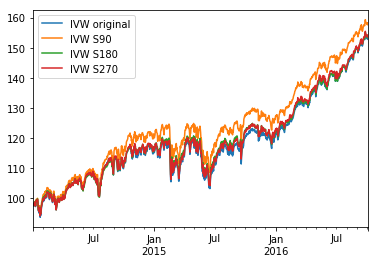

In [40]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='2014/1/2', periods = 1007,freq='d')).plot(label='IVW original', legend=True)

for s in [90, 180, 270]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='2014/1/2', periods = 1007,freq='d')).plot(label='IVW S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    

# Phase 3: Validating

In [41]:
for lam in [0.01, 0.05, 0.1]:
    ibb_predict = defaultdict(defaultdict)
    total_2_norm_diff = defaultdict(defaultdict)
    dl_scaler = defaultdict(StandardScaler)
    
    for non_communal in [70, 160, 250]:  
        # some numerical values
        encoding_dim = 64
        s = 20 + non_communal
        stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index
        
        
        # connect all layers
        input_img = Input(shape=(s,))
        encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(lam))(input_img)
        decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(lam))(encoded)
        
        
        # construct and compile deep learning routine
        deep_learner = Model(input_img, decoded)
        deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
        
        x = stock['calibrate']['percentage'].iloc[:, stock_index]
        y = ibb['calibrate']['percentage']
        
        dl_scaler[s] = StandardScaler() # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
        dl_scaler[s].fit(x)
        x = dl_scaler[s].transform(x)  
        
        deep_learner.fit(x, y, shuffle=False, epochs=1000, batch_size = 40)    # fit the model
        deep_learner.save('model/retrack_s' + str(s) + 'lambda_' + str(lam) + '.h5') # for validation phase use

Epoch 1/1000
1007/1007 [==============================] - 0s 99us/step - loss: 1.3352
Epoch 2/1000
1007/1007 [==============================] - 0s 60us/step - loss: 1.0135
Epoch 3/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.9177
Epoch 4/1000
1007/1007 [==============================] - 0s 58us/step - loss: 0.8660
Epoch 5/1000
1007/1007 [==============================] - 0s 64us/step - loss: 0.8322
Epoch 6/1000
1007/1007 [==============================] - 0s 66us/step - loss: 0.8074
Epoch 7/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.7877
Epoch 8/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.7712
Epoch 9/1000
1007/1007 [==============================] - 0s 54us/step - loss: 0.7568
Epoch 10/1000
1007/1007 [==============================] - 0s 60us/step - loss: 0.7440
Epoch 11/1000
1007/1007 [==============================] - 0s 96us/step - loss: 0.7322
Epoch 12/1000
1007/1007 [===========================

1007/1007 [==============================] - 0s 58us/step - loss: 0.3038
Epoch 96/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.3009
Epoch 97/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.2980
Epoch 98/1000
1007/1007 [==============================] - 0s 35us/step - loss: 0.2952
Epoch 99/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.2924
Epoch 100/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.2896
Epoch 101/1000
1007/1007 [==============================] - 0s 61us/step - loss: 0.2868
Epoch 102/1000
1007/1007 [==============================] - 0s 55us/step - loss: 0.2841
Epoch 103/1000
1007/1007 [==============================] - 0s 33us/step - loss: 0.2814
Epoch 104/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.2788
Epoch 105/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.2762
Epoch 106/1000
1007/1007 [=========================

1007/1007 [==============================] - 0s 43us/step - loss: 0.1333
Epoch 188/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.1322
Epoch 189/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.1312
Epoch 190/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1301
Epoch 191/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.1291
Epoch 192/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.1280
Epoch 193/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.1270
Epoch 194/1000
1007/1007 [==============================] - 0s 35us/step - loss: 0.1260
Epoch 195/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.1250
Epoch 196/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.1240
Epoch 197/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.1230
Epoch 198/1000
1007/1007 [=====================

Epoch 280/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0696
Epoch 281/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0692
Epoch 282/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0688
Epoch 283/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0684
Epoch 284/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0680
Epoch 285/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0677
Epoch 286/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0673
Epoch 287/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0669
Epoch 288/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0666
Epoch 289/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0662
Epoch 290/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0658
Epoch 291/1000
1007/1007 [======

1007/1007 [==============================] - 0s 41us/step - loss: 0.0466
Epoch 374/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0464
Epoch 375/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0463
Epoch 376/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0462
Epoch 377/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0460
Epoch 378/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0459
Epoch 379/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0458
Epoch 380/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0456
Epoch 381/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0455
Epoch 382/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0454
Epoch 383/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0452
Epoch 384/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 41us/step - loss: 0.0383
Epoch 467/1000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0382
Epoch 468/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0382
Epoch 469/1000
1007/1007 [==============================] - 0s 68us/step - loss: 0.0381
Epoch 470/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0381
Epoch 471/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0380
Epoch 472/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0380
Epoch 473/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0379
Epoch 474/1000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0379
Epoch 475/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0378
Epoch 476/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0378
Epoch 477/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 42us/step - loss: 0.0351
Epoch 560/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0351
Epoch 561/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0351
Epoch 562/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0351
Epoch 563/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0350
Epoch 564/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0350
Epoch 565/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0350
Epoch 566/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0350
Epoch 567/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0350
Epoch 568/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0349
Epoch 569/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0349
Epoch 570/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 44us/step - loss: 0.0337
Epoch 653/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0337
Epoch 654/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0337
Epoch 655/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0337
Epoch 656/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0337
Epoch 657/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0337
Epoch 658/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0337
Epoch 659/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0337
Epoch 660/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0337
Epoch 661/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0337
Epoch 662/1000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0336
Epoch 663/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 42us/step - loss: 0.0330
Epoch 746/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0330
Epoch 747/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0330
Epoch 748/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0330
Epoch 749/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0330
Epoch 750/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0330
Epoch 751/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0330
Epoch 752/1000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0330
Epoch 753/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0330
Epoch 754/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0330
Epoch 755/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0330
Epoch 756/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 41us/step - loss: 0.0327
Epoch 838/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0327
Epoch 839/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0327
Epoch 840/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0326
Epoch 841/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0326
Epoch 842/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0326
Epoch 843/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0326
Epoch 844/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0326
Epoch 845/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0326
Epoch 846/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0326
Epoch 847/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0326
Epoch 848/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 43us/step - loss: 0.0324
Epoch 931/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0324
Epoch 932/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0324
Epoch 933/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0324
Epoch 934/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0324
Epoch 935/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0324
Epoch 936/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0324
Epoch 937/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0324
Epoch 938/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0324
Epoch 939/1000
1007/1007 [==============================] - 0s 123us/step - loss: 0.0324
Epoch 940/1000
1007/1007 [==============================] - 0s 66us/step - loss: 0.0324
Epoch 941/1000
1007/1007 [====================

1007/1007 [==============================] - 0s 43us/step - loss: 0.7614
Epoch 24/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.7528
Epoch 25/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.7444
Epoch 26/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.7361
Epoch 27/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.7280
Epoch 28/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.7200
Epoch 29/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.7122
Epoch 30/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.7044
Epoch 31/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.6968
Epoch 32/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.6893
Epoch 33/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.6820
Epoch 34/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 44us/step - loss: 0.2892
Epoch 118/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.2863
Epoch 119/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.2835
Epoch 120/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.2807
Epoch 121/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.2779
Epoch 122/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.2752
Epoch 123/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.2725
Epoch 124/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.2698
Epoch 125/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.2672
Epoch 126/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.2645
Epoch 127/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.2619
Epoch 128/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 41us/step - loss: 0.1203
Epoch 210/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.1192
Epoch 211/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.1182
Epoch 212/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1171
Epoch 213/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.1161
Epoch 214/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.1150
Epoch 215/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.1140
Epoch 216/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.1130
Epoch 217/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.1120
Epoch 218/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.1110
Epoch 219/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.1100
Epoch 220/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 44us/step - loss: 0.0562
Epoch 303/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0558
Epoch 304/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0554
Epoch 305/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0550
Epoch 306/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0546
Epoch 307/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0543
Epoch 308/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0539
Epoch 309/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0535
Epoch 310/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0531
Epoch 311/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0528
Epoch 312/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0524
Epoch 313/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 82us/step - loss: 0.0324
Epoch 396/1000
1007/1007 [==============================] - 0s 60us/step - loss: 0.0322
Epoch 397/1000
1007/1007 [==============================] - 0s 67us/step - loss: 0.0321
Epoch 398/1000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0319
Epoch 399/1000
1007/1007 [==============================] - 0s 117us/step - loss: 0.0318
Epoch 400/1000
1007/1007 [==============================] - 0s 99us/step - loss: 0.0316
Epoch 401/1000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0315
Epoch 402/1000
1007/1007 [==============================] - 0s 85us/step - loss: 0.0313
Epoch 403/1000
1007/1007 [==============================] - 0s 72us/step - loss: 0.0312
Epoch 404/1000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0311
Epoch 405/1000
1007/1007 [==============================] - 0s 73us/step - loss: 0.0309
Epoch 406/1000
1007/1007 [====================

1007/1007 [==============================] - 0s 44us/step - loss: 0.0235
Epoch 489/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0234
Epoch 490/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0234
Epoch 491/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0233
Epoch 492/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0233
Epoch 493/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0232
Epoch 494/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0232
Epoch 495/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0231
Epoch 496/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0231
Epoch 497/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0230
Epoch 498/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0230
Epoch 499/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 46us/step - loss: 0.0201
Epoch 582/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0201
Epoch 583/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0201
Epoch 584/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0200
Epoch 585/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0200
Epoch 586/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0200
Epoch 587/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0200
Epoch 588/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0200
Epoch 589/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0199
Epoch 590/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0199
Epoch 591/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0199
Epoch 592/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 53us/step - loss: 0.0188
Epoch 675/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0188
Epoch 676/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0187
Epoch 677/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0187
Epoch 678/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0187
Epoch 679/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0187
Epoch 680/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0187
Epoch 681/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0187
Epoch 682/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0187
Epoch 683/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0187
Epoch 684/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0187
Epoch 685/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 44us/step - loss: 0.0182
Epoch 768/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0182
Epoch 769/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0181
Epoch 770/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0181
Epoch 771/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0181
Epoch 772/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0181
Epoch 773/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0181
Epoch 774/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0181
Epoch 775/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0181
Epoch 776/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0181
Epoch 777/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0181
Epoch 778/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 45us/step - loss: 0.0178
Epoch 861/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0178
Epoch 862/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0178
Epoch 863/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0178
Epoch 864/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0178
Epoch 865/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0178
Epoch 866/1000
1007/1007 [==============================] - 0s 228us/step - loss: 0.0178
Epoch 867/1000
1007/1007 [==============================] - 0s 88us/step - loss: 0.0178
Epoch 868/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0178
Epoch 869/1000
1007/1007 [==============================] - 0s 72us/step - loss: 0.0178
Epoch 870/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0178
Epoch 871/1000
1007/1007 [====================

1007/1007 [==============================] - 0s 42us/step - loss: 0.0177
Epoch 954/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0177
Epoch 955/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0177
Epoch 956/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0177
Epoch 957/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0177
Epoch 958/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0177
Epoch 959/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0176
Epoch 960/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0176
Epoch 961/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0176
Epoch 962/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0176
Epoch 963/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0176
Epoch 964/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 47us/step - loss: 0.6513
Epoch 47/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.6445
Epoch 48/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.6378
Epoch 49/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.6312
Epoch 50/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.6247
Epoch 51/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.6182
Epoch 52/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.6118
Epoch 53/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.6054
Epoch 54/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.5992
Epoch 55/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.5930
Epoch 56/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.5869
Epoch 57/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 44us/step - loss: 0.2526
Epoch 140/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.2501
Epoch 141/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.2476
Epoch 142/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.2451
Epoch 143/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.2427
Epoch 144/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.2403
Epoch 145/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.2380
Epoch 146/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.2356
Epoch 147/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.2333
Epoch 148/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.2310
Epoch 149/1000
1007/1007 [==============================] - 0s 66us/step - loss: 0.2287
Epoch 150/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 46us/step - loss: 0.1035
Epoch 233/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.1025
Epoch 234/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1016
Epoch 235/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.1007
Epoch 236/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0998
Epoch 237/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0988
Epoch 238/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0980
Epoch 239/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0971
Epoch 240/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0962
Epoch 241/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0953
Epoch 242/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0945
Epoch 243/1000
1007/1007 [=====================

Epoch 325/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0474
Epoch 326/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0471
Epoch 327/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0467
Epoch 328/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0464
Epoch 329/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0460
Epoch 330/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0457
Epoch 331/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0453
Epoch 332/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0450
Epoch 333/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0447
Epoch 334/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0444
Epoch 335/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0440
Epoch 336/1000
1007/1007 [======

1007/1007 [==============================] - 0s 40us/step - loss: 0.0264
Epoch 419/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0262
Epoch 420/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0261
Epoch 421/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0260
Epoch 422/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0258
Epoch 423/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0257
Epoch 424/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0256
Epoch 425/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0255
Epoch 426/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0253
Epoch 427/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0252
Epoch 428/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0251
Epoch 429/1000
1007/1007 [=====================

Epoch 511/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0184
Epoch 512/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0184
Epoch 513/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0183
Epoch 514/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0183
Epoch 515/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0182
Epoch 516/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0182
Epoch 517/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0181
Epoch 518/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0181
Epoch 519/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0181
Epoch 520/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0180
Epoch 521/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0180
Epoch 522/1000
1007/1007 [======

1007/1007 [==============================] - 0s 37us/step - loss: 0.0154
Epoch 605/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0154
Epoch 606/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0153
Epoch 607/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0153
Epoch 608/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0153
Epoch 609/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0153
Epoch 610/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0153
Epoch 611/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0152
Epoch 612/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0152
Epoch 613/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0152
Epoch 614/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0152
Epoch 615/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 47us/step - loss: 0.0141
Epoch 698/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0141
Epoch 699/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0141
Epoch 700/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0141
Epoch 701/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0141
Epoch 702/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0141
Epoch 703/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0141
Epoch 704/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0141
Epoch 705/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0141
Epoch 706/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0141
Epoch 707/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0141
Epoch 708/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 45us/step - loss: 0.0136
Epoch 791/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0136
Epoch 792/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0136
Epoch 793/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0136
Epoch 794/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0136
Epoch 795/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0136
Epoch 796/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0136
Epoch 797/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0136
Epoch 798/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0136
Epoch 799/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0136
Epoch 800/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0136
Epoch 801/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 43us/step - loss: 0.0133
Epoch 884/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0133
Epoch 885/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0133
Epoch 886/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0133
Epoch 887/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0133
Epoch 888/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0133
Epoch 889/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0133
Epoch 890/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0133
Epoch 891/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0133
Epoch 892/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0133
Epoch 893/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0133
Epoch 894/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 75us/step - loss: 0.0132
Epoch 977/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0132
Epoch 978/1000
1007/1007 [==============================] - 0s 64us/step - loss: 0.0132
Epoch 979/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0132
Epoch 980/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0132
Epoch 981/1000
1007/1007 [==============================] - 0s 80us/step - loss: 0.0132
Epoch 982/1000
1007/1007 [==============================] - 0s 59us/step - loss: 0.0132
Epoch 983/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0132
Epoch 984/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0132
Epoch 985/1000
1007/1007 [==============================] - 0s 54us/step - loss: 0.0132
Epoch 986/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0132
Epoch 987/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 47us/step - loss: 0.1646
Epoch 71/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.1597
Epoch 72/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.1550
Epoch 73/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.1506
Epoch 74/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.1464
Epoch 75/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.1424
Epoch 76/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.1386
Epoch 77/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.1350
Epoch 78/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.1316
Epoch 79/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.1284
Epoch 80/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.1253
Epoch 81/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 35us/step - loss: 0.0686
Epoch 164/1000
1007/1007 [==============================] - 0s 33us/step - loss: 0.0685
Epoch 165/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0685
Epoch 166/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0685
Epoch 167/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0684
Epoch 168/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0684
Epoch 169/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0683
Epoch 170/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0683
Epoch 171/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0683
Epoch 172/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0682
Epoch 173/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0682
Epoch 174/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 53us/step - loss: 0.0675
Epoch 257/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0675
Epoch 258/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0675
Epoch 259/1000
1007/1007 [==============================] - 0s 35us/step - loss: 0.0675
Epoch 260/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0675
Epoch 261/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0675
Epoch 262/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0675
Epoch 263/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0675
Epoch 264/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0675
Epoch 265/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0675
Epoch 266/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0675
Epoch 267/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 41us/step - loss: 0.0674
Epoch 350/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0674
Epoch 351/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0674
Epoch 352/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0674
Epoch 353/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0674
Epoch 354/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0674
Epoch 355/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0674
Epoch 356/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0674
Epoch 357/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0674
Epoch 358/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0674
Epoch 359/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0674
Epoch 360/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 45us/step - loss: 0.0673
Epoch 443/1000
1007/1007 [==============================] - 0s 79us/step - loss: 0.0673
Epoch 444/1000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0673
Epoch 445/1000
1007/1007 [==============================] - 0s 71us/step - loss: 0.0673
Epoch 446/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0673
Epoch 447/1000
1007/1007 [==============================] - 0s 113us/step - loss: 0.0673
Epoch 448/1000
1007/1007 [==============================] - 0s 56us/step - loss: 0.0673
Epoch 449/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0673
Epoch 450/1000
1007/1007 [==============================] - 0s 82us/step - loss: 0.0673
Epoch 451/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0673
Epoch 452/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0673
Epoch 453/1000
1007/1007 [====================

1007/1007 [==============================] - 0s 40us/step - loss: 0.0673
Epoch 536/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0673
Epoch 537/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0673
Epoch 538/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0673
Epoch 539/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0673
Epoch 540/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0673
Epoch 541/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0673
Epoch 542/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0673
Epoch 543/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0673
Epoch 544/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0673
Epoch 545/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0673
Epoch 546/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 41us/step - loss: 0.0672
Epoch 629/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0672
Epoch 630/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0672
Epoch 631/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0672
Epoch 632/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0672
Epoch 633/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0672
Epoch 634/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0672
Epoch 635/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0672
Epoch 636/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0672
Epoch 637/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0672
Epoch 638/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0672
Epoch 639/1000
1007/1007 [=====================

Epoch 721/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0672
Epoch 722/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0672
Epoch 723/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0672
Epoch 724/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0672
Epoch 725/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0672
Epoch 726/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0672
Epoch 727/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0672
Epoch 728/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0672
Epoch 729/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0672
Epoch 730/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0672
Epoch 731/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0671
Epoch 732/1000
1007/1007 [======

1007/1007 [==============================] - 0s 38us/step - loss: 0.0671
Epoch 815/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0671
Epoch 816/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0671
Epoch 817/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0671
Epoch 818/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0671
Epoch 819/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0671
Epoch 820/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0671
Epoch 821/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0671
Epoch 822/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0671
Epoch 823/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0671
Epoch 824/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0671
Epoch 825/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 36us/step - loss: 0.0670
Epoch 908/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0670
Epoch 909/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0670
Epoch 910/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0670
Epoch 911/1000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0670
Epoch 912/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0670
Epoch 913/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0670
Epoch 914/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0670
Epoch 915/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0670
Epoch 916/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0670
Epoch 917/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0670
Epoch 918/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 37us/step - loss: 0.0670
Epoch 1/1000
1007/1007 [==============================] - 0s 93us/step - loss: 5.3852
Epoch 2/1000
1007/1007 [==============================] - 0s 45us/step - loss: 4.6702
Epoch 3/1000
1007/1007 [==============================] - 0s 43us/step - loss: 4.3315
Epoch 4/1000
1007/1007 [==============================] - 0s 43us/step - loss: 4.0622
Epoch 5/1000
1007/1007 [==============================] - 0s 39us/step - loss: 3.8283
Epoch 6/1000
1007/1007 [==============================] - 0s 45us/step - loss: 3.6169
Epoch 7/1000
1007/1007 [==============================] - 0s 44us/step - loss: 3.4223
Epoch 8/1000
1007/1007 [==============================] - 0s 48us/step - loss: 3.2413
Epoch 9/1000
1007/1007 [==============================] - 0s 44us/step - loss: 3.0720
Epoch 10/1000
1007/1007 [==============================] - 0s 44us/step - loss: 2.9130
Epoch 11/1000
1007/1007 [==============================] - 0s 40us

1007/1007 [==============================] - 0s 45us/step - loss: 0.0800
Epoch 95/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0782
Epoch 96/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0765
Epoch 97/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0749
Epoch 98/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0733
Epoch 99/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0719
Epoch 100/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0705
Epoch 101/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0692
Epoch 102/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0679
Epoch 103/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0667
Epoch 104/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0656
Epoch 105/1000
1007/1007 [==========================

1007/1007 [==============================] - 0s 39us/step - loss: 0.0447
Epoch 188/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0447
Epoch 189/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0446
Epoch 190/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0446
Epoch 191/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0446
Epoch 192/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0446
Epoch 193/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0446
Epoch 194/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0446
Epoch 195/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0446
Epoch 196/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0446
Epoch 197/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0445
Epoch 198/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 39us/step - loss: 0.0443
Epoch 281/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0443
Epoch 282/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0443
Epoch 283/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0443
Epoch 284/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0443
Epoch 285/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0443
Epoch 286/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0443
Epoch 287/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0443
Epoch 288/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0443
Epoch 289/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0443
Epoch 290/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0443
Epoch 291/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 44us/step - loss: 0.0442
Epoch 374/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0442
Epoch 375/1000
1007/1007 [==============================] - 0s 59us/step - loss: 0.0442
Epoch 376/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0442
Epoch 377/1000
1007/1007 [==============================] - 0s 64us/step - loss: 0.0442
Epoch 378/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0442
Epoch 379/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0442
Epoch 380/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0442
Epoch 381/1000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0442
Epoch 382/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0442
Epoch 383/1000
1007/1007 [==============================] - 0s 214us/step - loss: 0.0442
Epoch 384/1000
1007/1007 [====================

1007/1007 [==============================] - 0s 42us/step - loss: 0.0442
Epoch 467/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0442
Epoch 468/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0442
Epoch 469/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0442
Epoch 470/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0442
Epoch 471/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0442
Epoch 472/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0442
Epoch 473/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0442
Epoch 474/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0442
Epoch 475/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0442
Epoch 476/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0442
Epoch 477/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 43us/step - loss: 0.0442
Epoch 560/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0442
Epoch 561/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0442
Epoch 562/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0442
Epoch 563/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0442
Epoch 564/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0442
Epoch 565/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0442
Epoch 566/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0442
Epoch 567/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0442
Epoch 568/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0442
Epoch 569/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0442
Epoch 570/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 47us/step - loss: 0.0441
Epoch 653/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0441
Epoch 654/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0441
Epoch 655/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0441
Epoch 656/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0441
Epoch 657/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0441
Epoch 658/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0441
Epoch 659/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0441
Epoch 660/1000
1007/1007 [==============================] - 0s 61us/step - loss: 0.0441
Epoch 661/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0441
Epoch 662/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0441
Epoch 663/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 40us/step - loss: 0.0441
Epoch 746/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0441
Epoch 747/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0441
Epoch 748/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0441
Epoch 749/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0441
Epoch 750/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0441
Epoch 751/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0441
Epoch 752/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0441
Epoch 753/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0441
Epoch 754/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0441
Epoch 755/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0441
Epoch 756/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 78us/step - loss: 0.0441
Epoch 839/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0441
Epoch 840/1000
1007/1007 [==============================] - 0s 92us/step - loss: 0.0441
Epoch 841/1000
1007/1007 [==============================] - 0s 79us/step - loss: 0.0441
Epoch 842/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0441
Epoch 843/1000
1007/1007 [==============================] - 0s 74us/step - loss: 0.0441
Epoch 844/1000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0441
Epoch 845/1000
1007/1007 [==============================] - 0s 72us/step - loss: 0.0441
Epoch 846/1000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0441
Epoch 847/1000
1007/1007 [==============================] - 0s 76us/step - loss: 0.0441
Epoch 848/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0441
Epoch 849/1000
1007/1007 [=====================

Epoch 931/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0440
Epoch 932/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0440
Epoch 933/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0440
Epoch 934/1000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0440
Epoch 935/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0440
Epoch 936/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0440
Epoch 937/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0440
Epoch 938/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0440
Epoch 939/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0440
Epoch 940/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0440
Epoch 941/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0440
Epoch 942/1000
1007/1007 [======

1007/1007 [==============================] - 0s 49us/step - loss: 1.5400
Epoch 25/1000
1007/1007 [==============================] - 0s 65us/step - loss: 1.4635
Epoch 26/1000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3910
Epoch 27/1000
1007/1007 [==============================] - 0s 71us/step - loss: 1.3221
Epoch 28/1000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2567
Epoch 29/1000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1947
Epoch 30/1000
1007/1007 [==============================] - 0s 41us/step - loss: 1.1359
Epoch 31/1000
1007/1007 [==============================] - 0s 47us/step - loss: 1.0800
Epoch 32/1000
1007/1007 [==============================] - 0s 68us/step - loss: 1.0270
Epoch 33/1000
1007/1007 [==============================] - 0s 53us/step - loss: 0.9767
Epoch 34/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.9289
Epoch 35/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 42us/step - loss: 0.0496
Epoch 118/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0490
Epoch 119/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0484
Epoch 120/1000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0479
Epoch 121/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0473
Epoch 122/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0468
Epoch 123/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0464
Epoch 124/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0459
Epoch 125/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0455
Epoch 126/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0451
Epoch 127/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0447
Epoch 128/1000
1007/1007 [=====================

Epoch 210/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0374
Epoch 211/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0374
Epoch 212/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0374
Epoch 213/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0374
Epoch 214/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0374
Epoch 215/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0374
Epoch 216/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0374
Epoch 217/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0374
Epoch 218/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0374
Epoch 219/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0374
Epoch 220/1000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0374
Epoch 221/1000
1007/1007 [======

Epoch 303/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0372
Epoch 304/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0372
Epoch 305/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0372
Epoch 306/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0372
Epoch 307/1000
1007/1007 [==============================] - 0s 55us/step - loss: 0.0372
Epoch 308/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0372
Epoch 309/1000
1007/1007 [==============================] - ETA: 0s - loss: 0.039 - 0s 47us/step - loss: 0.0372
Epoch 310/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0372
Epoch 311/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0372
Epoch 312/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0372
Epoch 313/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0372
Epoch 31

1007/1007 [==============================] - 0s 45us/step - loss: 0.0372
Epoch 396/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0372
Epoch 397/1000
1007/1007 [==============================] - 0s 54us/step - loss: 0.0372
Epoch 398/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0372
Epoch 399/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0372
Epoch 400/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0372
Epoch 401/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0372
Epoch 402/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0371
Epoch 403/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0371
Epoch 404/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0371
Epoch 405/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0371
Epoch 406/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 47us/step - loss: 0.0371
Epoch 489/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0371
Epoch 490/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0371
Epoch 491/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0371
Epoch 492/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0371
Epoch 493/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0371
Epoch 494/1000
1007/1007 [==============================] - 0s 60us/step - loss: 0.0371
Epoch 495/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0371
Epoch 496/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0371
Epoch 497/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0371
Epoch 498/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0371
Epoch 499/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 42us/step - loss: 0.0370
Epoch 582/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0370
Epoch 583/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0370
Epoch 584/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0370
Epoch 585/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0370
Epoch 586/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0370
Epoch 587/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0370
Epoch 588/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0370
Epoch 589/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0370
Epoch 590/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0370
Epoch 591/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0370
Epoch 592/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 60us/step - loss: 0.0370
Epoch 675/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0370
Epoch 676/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0370
Epoch 677/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0370
Epoch 678/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0370
Epoch 679/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0370
Epoch 680/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0370
Epoch 681/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0370
Epoch 682/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0370
Epoch 683/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0370
Epoch 684/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0370
Epoch 685/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 48us/step - loss: 0.0369
Epoch 768/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0369
Epoch 769/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0369
Epoch 770/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0369
Epoch 771/1000
1007/1007 [==============================] - 0s 56us/step - loss: 0.0369
Epoch 772/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0369
Epoch 773/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0369
Epoch 774/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0369
Epoch 775/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0369
Epoch 776/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0369
Epoch 777/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0369
Epoch 778/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 66us/step - loss: 0.0368
Epoch 861/1000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0368
Epoch 862/1000
1007/1007 [==============================] - 0s 93us/step - loss: 0.0368
Epoch 863/1000
1007/1007 [==============================] - 0s 85us/step - loss: 0.0368
Epoch 864/1000
1007/1007 [==============================] - 0s 59us/step - loss: 0.0368
Epoch 865/1000
1007/1007 [==============================] - 0s 74us/step - loss: 0.0368
Epoch 866/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0368
Epoch 867/1000
1007/1007 [==============================] - 0s 74us/step - loss: 0.0368
Epoch 868/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0368
Epoch 869/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0368
Epoch 870/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0368
Epoch 871/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 46us/step - loss: 0.0368
Epoch 954/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0368
Epoch 955/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0368
Epoch 956/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0368
Epoch 957/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0367
Epoch 958/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0368
Epoch 959/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0367
Epoch 960/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0367
Epoch 961/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0367
Epoch 962/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0367
Epoch 963/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0367
Epoch 964/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 40us/step - loss: 0.1657
Epoch 47/1000
1007/1007 [==============================] - 0s 35us/step - loss: 0.1592
Epoch 48/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.1534
Epoch 49/1000
1007/1007 [==============================] - 0s 35us/step - loss: 0.1481
Epoch 50/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.1434
Epoch 51/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.1391
Epoch 52/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1353
Epoch 53/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.1318
Epoch 54/1000
1007/1007 [==============================] - 0s 51us/step - loss: 0.1287
Epoch 55/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1259
Epoch 56/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1233
Epoch 57/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 40us/step - loss: 0.1001
Epoch 140/1000
1007/1007 [==============================] - 0s 34us/step - loss: 0.1001
Epoch 141/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.1001
Epoch 142/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1001
Epoch 143/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.1001
Epoch 144/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.1001
Epoch 145/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.1001
Epoch 146/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.1001
Epoch 147/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.1000
Epoch 148/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.1001
Epoch 149/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1000
Epoch 150/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 34us/step - loss: 0.1000
Epoch 233/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.1000
Epoch 234/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.1000
Epoch 235/1000
1007/1007 [==============================] - 0s 35us/step - loss: 0.1000
Epoch 236/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.1000
Epoch 237/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.1000
Epoch 238/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.1000
Epoch 239/1000
1007/1007 [==============================] - 0s 35us/step - loss: 0.1000
Epoch 240/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.1000
Epoch 241/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.1000
Epoch 242/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.1000
Epoch 243/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 42us/step - loss: 0.0999
Epoch 326/1000
1007/1007 [==============================] - 0s 86us/step - loss: 0.0999
Epoch 327/1000
1007/1007 [==============================] - 0s 78us/step - loss: 0.0999
Epoch 328/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0999
Epoch 329/1000
1007/1007 [==============================] - 0s 78us/step - loss: 0.0999
Epoch 330/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0999
Epoch 331/1000
1007/1007 [==============================] - 0s 77us/step - loss: 0.0999
Epoch 332/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0999
Epoch 333/1000
1007/1007 [==============================] - 0s 67us/step - loss: 0.0999
Epoch 334/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0999
Epoch 335/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0999
Epoch 336/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 87us/step - loss: 0.0999
Epoch 419/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0999
Epoch 420/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0999
Epoch 421/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0999
Epoch 422/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0999
Epoch 423/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0999
Epoch 424/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0999
Epoch 425/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0999
Epoch 426/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0999
Epoch 427/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0999
Epoch 428/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0999
Epoch 429/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 35us/step - loss: 0.0998
Epoch 512/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0998
Epoch 513/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0998
Epoch 514/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0998
Epoch 515/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0998
Epoch 516/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0998
Epoch 517/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0998
Epoch 518/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0998
Epoch 519/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0998
Epoch 520/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0998
Epoch 521/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0998
Epoch 522/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 40us/step - loss: 0.0997
Epoch 605/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0997
Epoch 606/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0997
Epoch 607/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0997
Epoch 608/1000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0997
Epoch 609/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0997
Epoch 610/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0997
Epoch 611/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0997
Epoch 612/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0997
Epoch 613/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0997
Epoch 614/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0997
Epoch 615/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 38us/step - loss: 0.0995
Epoch 698/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0995
Epoch 699/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0995
Epoch 700/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0995
Epoch 701/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0995
Epoch 702/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0995
Epoch 703/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0995
Epoch 704/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0995
Epoch 705/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0995
Epoch 706/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0995
Epoch 707/1000
1007/1007 [==============================] - 0s 65us/step - loss: 0.0995
Epoch 708/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 40us/step - loss: 0.0992
Epoch 791/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0992
Epoch 792/1000
1007/1007 [==============================] - 0s 59us/step - loss: 0.0992
Epoch 793/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0992
Epoch 794/1000
1007/1007 [==============================] - 0s 68us/step - loss: 0.0992
Epoch 795/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0992
Epoch 796/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0992
Epoch 797/1000
1007/1007 [==============================] - 0s 61us/step - loss: 0.0992
Epoch 798/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0992
Epoch 799/1000
1007/1007 [==============================] - 0s 116us/step - loss: 0.0992
Epoch 800/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0992
Epoch 801/1000
1007/1007 [====================

1007/1007 [==============================] - 0s 36us/step - loss: 0.0988
Epoch 884/1000
1007/1007 [==============================] - 0s 36us/step - loss: 0.0988
Epoch 885/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0988
Epoch 886/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0988
Epoch 887/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0988
Epoch 888/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0988
Epoch 889/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0988
Epoch 890/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0988
Epoch 891/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0988
Epoch 892/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0988
Epoch 893/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0988
Epoch 894/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 35us/step - loss: 0.0983
Epoch 977/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0983
Epoch 978/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0983
Epoch 979/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0983
Epoch 980/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0983
Epoch 981/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0983
Epoch 982/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0983
Epoch 983/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0983
Epoch 984/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0983
Epoch 985/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0983
Epoch 986/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0983
Epoch 987/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 46us/step - loss: 0.0762
Epoch 71/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0756
Epoch 72/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0750
Epoch 73/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0744
Epoch 74/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0739
Epoch 75/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0735
Epoch 76/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0731
Epoch 77/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0728
Epoch 78/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0724
Epoch 79/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0721
Epoch 80/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0719
Epoch 81/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 43us/step - loss: 0.0693
Epoch 164/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0693
Epoch 165/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0693
Epoch 166/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0693
Epoch 167/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0693
Epoch 168/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0693
Epoch 169/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0693
Epoch 170/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0693
Epoch 171/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0693
Epoch 172/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0693
Epoch 173/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0693
Epoch 174/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 84us/step - loss: 0.0693
Epoch 257/1000
1007/1007 [==============================] - 0s 111us/step - loss: 0.0693
Epoch 258/1000
1007/1007 [==============================] - 0s 69us/step - loss: 0.0693
Epoch 259/1000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0693
Epoch 260/1000
1007/1007 [==============================] - 0s 69us/step - loss: 0.0693
Epoch 261/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0693
Epoch 262/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0693
Epoch 263/1000
1007/1007 [==============================] - 0s 87us/step - loss: 0.0693
Epoch 264/1000
1007/1007 [==============================] - 0s 82us/step - loss: 0.0693
Epoch 265/1000
1007/1007 [==============================] - 0s 55us/step - loss: 0.0693
Epoch 266/1000
1007/1007 [==============================] - 0s 71us/step - loss: 0.0693
Epoch 267/1000
1007/1007 [====================

1007/1007 [==============================] - 0s 51us/step - loss: 0.0693
Epoch 350/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0693
Epoch 351/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0693
Epoch 352/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0693
Epoch 353/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0693
Epoch 354/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0693
Epoch 355/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0693
Epoch 356/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0693
Epoch 357/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0693
Epoch 358/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0693
Epoch 359/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0693
Epoch 360/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 46us/step - loss: 0.0692
Epoch 443/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0692
Epoch 444/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0692
Epoch 445/1000
1007/1007 [==============================] - 0s 38us/step - loss: 0.0692
Epoch 446/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0692
Epoch 447/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0692
Epoch 448/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0692
Epoch 449/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0692
Epoch 450/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0692
Epoch 451/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0692
Epoch 452/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0692
Epoch 453/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 37us/step - loss: 0.0692
Epoch 536/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0692
Epoch 537/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0692
Epoch 538/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0692
Epoch 539/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0692
Epoch 540/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0692
Epoch 541/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0692
Epoch 542/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0692
Epoch 543/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0692
Epoch 544/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0692
Epoch 545/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0692
Epoch 546/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 53us/step - loss: 0.0691
Epoch 629/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0691
Epoch 630/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0691
Epoch 631/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0691
Epoch 632/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0691
Epoch 633/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0691
Epoch 634/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0691
Epoch 635/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0691
Epoch 636/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0691
Epoch 637/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0691
Epoch 638/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0691
Epoch 639/1000
1007/1007 [=====================

Epoch 721/1000
1007/1007 [==============================] - 0s 89us/step - loss: 0.0690
Epoch 722/1000
1007/1007 [==============================] - 0s 61us/step - loss: 0.0690
Epoch 723/1000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0690
Epoch 724/1000
1007/1007 [==============================] - 0s 77us/step - loss: 0.0690
Epoch 725/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0690
Epoch 726/1000
1007/1007 [==============================] - 0s 76us/step - loss: 0.0690
Epoch 727/1000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0690
Epoch 728/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0690
Epoch 729/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0690
Epoch 730/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0690
Epoch 731/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0690
Epoch 732/1000
1007/1007 [======

1007/1007 [==============================] - 0s 44us/step - loss: 0.0689
Epoch 815/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0689
Epoch 816/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0689
Epoch 817/1000
1007/1007 [==============================] - 0s 37us/step - loss: 0.0689
Epoch 818/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0689
Epoch 819/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0689
Epoch 820/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0689
Epoch 821/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0689
Epoch 822/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0689
Epoch 823/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0689
Epoch 824/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0689
Epoch 825/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 46us/step - loss: 0.0688
Epoch 908/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0688
Epoch 909/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0688
Epoch 910/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0688
Epoch 911/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0688
Epoch 912/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0687
Epoch 913/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0687
Epoch 914/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0687
Epoch 915/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0687
Epoch 916/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0687
Epoch 917/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0687
Epoch 918/1000
1007/1007 [=====================

Epoch 1000/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0686
Epoch 1/1000
1007/1007 [==============================] - 0s 101us/step - loss: 10.5263
Epoch 2/1000
1007/1007 [==============================] - 0s 46us/step - loss: 9.0877
Epoch 3/1000
1007/1007 [==============================] - 0s 45us/step - loss: 8.0923
Epoch 4/1000
1007/1007 [==============================] - 0s 56us/step - loss: 7.2490
Epoch 5/1000
1007/1007 [==============================] - 0s 49us/step - loss: 6.5101
Epoch 6/1000
1007/1007 [==============================] - 0s 46us/step - loss: 5.8546
Epoch 7/1000
1007/1007 [==============================] - 0s 50us/step - loss: 5.2699
Epoch 8/1000
1007/1007 [==============================] - 0s 47us/step - loss: 4.7466
Epoch 9/1000
1007/1007 [==============================] - 0s 62us/step - loss: 4.2773
Epoch 10/1000
1007/1007 [==============================] - 0s 51us/step - loss: 3.8560
Epoch 11/1000
1007/1007 [=======================

1007/1007 [==============================] - 0s 50us/step - loss: 0.0603
Epoch 95/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0602
Epoch 96/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0602
Epoch 97/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0601
Epoch 98/1000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0601
Epoch 99/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0600
Epoch 100/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0600
Epoch 101/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0599
Epoch 102/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0599
Epoch 103/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0599
Epoch 104/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0598
Epoch 105/1000
1007/1007 [==========================

1007/1007 [==============================] - 0s 47us/step - loss: 0.0595
Epoch 187/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0595
Epoch 188/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0595
Epoch 189/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0595
Epoch 190/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0595
Epoch 191/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0595
Epoch 192/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0595
Epoch 193/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0595
Epoch 194/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0595
Epoch 195/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0595
Epoch 196/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0595
Epoch 197/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 46us/step - loss: 0.0595
Epoch 280/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0595
Epoch 281/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0595
Epoch 282/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0595
Epoch 283/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0595
Epoch 284/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0595
Epoch 285/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0595
Epoch 286/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0594
Epoch 287/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0594
Epoch 288/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0594
Epoch 289/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0594
Epoch 290/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 83us/step - loss: 0.0594
Epoch 373/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0594
Epoch 374/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0594
Epoch 375/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0594
Epoch 376/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0594
Epoch 377/1000
1007/1007 [==============================] - ETA: 0s - loss: 0.059 - 0s 54us/step - loss: 0.0594
Epoch 378/1000
1007/1007 [==============================] - 0s 78us/step - loss: 0.0594
Epoch 379/1000
1007/1007 [==============================] - 0s 74us/step - loss: 0.0594
Epoch 380/1000
1007/1007 [==============================] - 0s 54us/step - loss: 0.0594
Epoch 381/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0594
Epoch 382/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0594
Epoch 383/1000
1007/100

Epoch 465/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0594
Epoch 466/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0594
Epoch 467/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0594
Epoch 468/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0594
Epoch 469/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0594
Epoch 470/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0594
Epoch 471/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0594
Epoch 472/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0594
Epoch 473/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0594
Epoch 474/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0594
Epoch 475/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0594
Epoch 476/1000
1007/1007 [======

1007/1007 [==============================] - 0s 71us/step - loss: 0.0594
Epoch 559/1000
1007/1007 [==============================] - 0s 56us/step - loss: 0.0594
Epoch 560/1000
1007/1007 [==============================] - 0s 92us/step - loss: 0.0594
Epoch 561/1000
1007/1007 [==============================] - 0s 72us/step - loss: 0.0594
Epoch 562/1000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0594
Epoch 563/1000
1007/1007 [==============================] - 0s 81us/step - loss: 0.0594
Epoch 564/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0594
Epoch 565/1000
1007/1007 [==============================] - 0s 84us/step - loss: 0.0594
Epoch 566/1000
1007/1007 [==============================] - 0s 53us/step - loss: 0.0594
Epoch 567/1000
1007/1007 [==============================] - 0s 74us/step - loss: 0.0594
Epoch 568/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0594
Epoch 569/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 46us/step - loss: 0.0594
Epoch 652/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0594
Epoch 653/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0594
Epoch 654/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0594
Epoch 655/1000
1007/1007 [==============================] - 0s 60us/step - loss: 0.0594
Epoch 656/1000
1007/1007 [==============================] - 0s 66us/step - loss: 0.0594
Epoch 657/1000
1007/1007 [==============================] - 0s 39us/step - loss: 0.0594
Epoch 658/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0594
Epoch 659/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0594
Epoch 660/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0594
Epoch 661/1000
1007/1007 [==============================] - 0s 49us/step - loss: 0.0594
Epoch 662/1000
1007/1007 [=====================

Epoch 744/1000
1007/1007 [==============================] - 0s 57us/step - loss: 0.0594
Epoch 745/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0594
Epoch 746/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0594
Epoch 747/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0594
Epoch 748/1000
1007/1007 [==============================] - 0s 60us/step - loss: 0.0594
Epoch 749/1000
1007/1007 [==============================] - 0s 46us/step - loss: 0.0594
Epoch 750/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0594
Epoch 751/1000
1007/1007 [==============================] - 0s 52us/step - loss: 0.0594
Epoch 752/1000
1007/1007 [==============================] - 0s 44us/step - loss: 0.0594
Epoch 753/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0594
Epoch 754/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0594
Epoch 755/1000
1007/1007 [======

1007/1007 [==============================] - 0s 50us/step - loss: 0.0593
Epoch 838/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0593
Epoch 839/1000
1007/1007 [==============================] - 0s 43us/step - loss: 0.0593
Epoch 840/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0593
Epoch 841/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0593
Epoch 842/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0593
Epoch 843/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0593
Epoch 844/1000
1007/1007 [==============================] - 0s 42us/step - loss: 0.0593
Epoch 845/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0593
Epoch 846/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0593
Epoch 847/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0593
Epoch 848/1000
1007/1007 [=====================

Epoch 930/1000
1007/1007 [==============================] - 0s 62us/step - loss: 0.0593
Epoch 931/1000
1007/1007 [==============================] - 0s 48us/step - loss: 0.0593
Epoch 932/1000
1007/1007 [==============================] - 0s 40us/step - loss: 0.0593
Epoch 933/1000
1007/1007 [==============================] - 0s 41us/step - loss: 0.0593
Epoch 934/1000
1007/1007 [==============================] - 0s 51us/step - loss: 0.0593
Epoch 935/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0593
Epoch 936/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0593
Epoch 937/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0593
Epoch 938/1000
1007/1007 [==============================] - 0s 47us/step - loss: 0.0593
Epoch 939/1000
1007/1007 [==============================] - 0s 45us/step - loss: 0.0593
Epoch 940/1000
1007/1007 [==============================] - 0s 50us/step - loss: 0.0593
Epoch 941/1000
1007/1007 [======

S90 2-norm difference:  150.35577
S180 2-norm difference:  157.40495
S270 2-norm difference:  129.9252


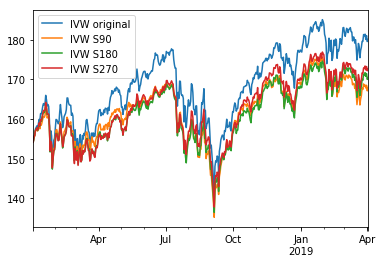

In [44]:
for non_communal in [70, 160, 250]:  
    # some numerical values
    encoding_dim = 64
    s = 20 + non_communal
    stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + 'lambda_0.01'+'.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))
    
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW original', legend=True) 

for s in [90, 180, 270]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

Again, we would like to see how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

S90 2-norm difference:  171.62325
S180 2-norm difference:  109.6713
S270 2-norm difference:  99.15756


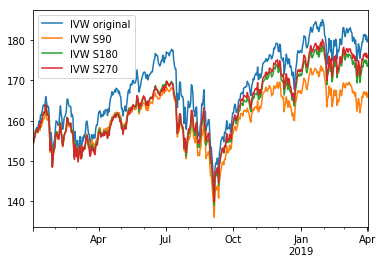

In [43]:
for non_communal in [70, 160, 250]:  
    # some numerical values
    encoding_dim = 64
    s = 20 + non_communal
    stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + 'lambda_0.05'+'.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))
    
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW original', legend=True) 

for s in [90, 180, 270]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

S90 2-norm difference:  147.54419
S180 2-norm difference:  109.68533
S270 2-norm difference:  85.21064


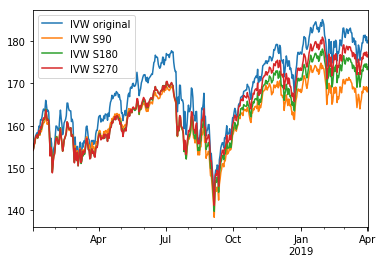

In [45]:
for non_communal in [70, 160, 250]:  
    # some numerical values
    encoding_dim = 64
    s = 20 + non_communal
    stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + 'lambda_0.1'+'.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))
    
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW original', legend=True) 

for s in [90, 180, 270]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

# Phase 4: Verifying

- x-axis: 2-norm error  
- y-axis: # of stocks in the portfolios: 10, 11, 12, ..., 

From my perspective, Efficient Deep Frontier has nothing to do with the one in Modern Portfolio Theory. It just reflects the trade-off between more stocks in the portfolios and higher MSE.

In [12]:
error = []
for non_communal in range(5, 79, 1):  
    
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))    

Epoch 1/500
104/104 [==============================] - 1s 5ms/step - loss: 4.8297
Epoch 2/500
104/104 [==============================] - 0s 100us/step - loss: 3.7927
Epoch 3/500
104/104 [==============================] - 0s 94us/step - loss: 3.1699
Epoch 4/500
104/104 [==============================] - 0s 97us/step - loss: 2.7247
Epoch 5/500
104/104 [==============================] - 0s 96us/step - loss: 2.4304
Epoch 6/500
104/104 [==============================] - 0s 94us/step - loss: 2.2416
Epoch 7/500
104/104 [==============================] - 0s 95us/step - loss: 2.1033
Epoch 8/500
104/104 [==============================] - 0s 93us/step - loss: 1.9926
Epoch 9/500
104/104 [==============================] - 0s 95us/step - loss: 1.8973
Epoch 10/500
104/104 [==============================] - 0s 102us/step - loss: 1.8157
Epoch 11/500
104/104 [==============================] - 0s 95us/step - loss: 1.7418
Epoch 12/500
104/104 [==============================] - 0s 99us/step - loss: 1.6743


104/104 [==============================] - 0s 101us/step - loss: 0.6659
Epoch 195/500
104/104 [==============================] - 0s 97us/step - loss: 0.6653
Epoch 196/500
104/104 [==============================] - 0s 98us/step - loss: 0.6628
Epoch 197/500
104/104 [==============================] - 0s 98us/step - loss: 0.6642
Epoch 198/500
104/104 [==============================] - 0s 97us/step - loss: 0.6636
Epoch 199/500
104/104 [==============================] - 0s 101us/step - loss: 0.6609
Epoch 200/500
104/104 [==============================] - 0s 99us/step - loss: 0.6627
Epoch 201/500
104/104 [==============================] - 0s 97us/step - loss: 0.6612
Epoch 202/500
104/104 [==============================] - 0s 99us/step - loss: 0.6596
Epoch 203/500
104/104 [==============================] - 0s 99us/step - loss: 0.6609
Epoch 204/500
104/104 [==============================] - 0s 97us/step - loss: 0.6598
Epoch 205/500
104/104 [==============================] - 0s 99us/step - loss:

104/104 [==============================] - 0s 100us/step - loss: 0.6128
Epoch 387/500
104/104 [==============================] - 0s 96us/step - loss: 0.6147
Epoch 388/500
104/104 [==============================] - 0s 100us/step - loss: 0.6140
Epoch 389/500
104/104 [==============================] - 0s 97us/step - loss: 0.6155
Epoch 390/500
104/104 [==============================] - 0s 94us/step - loss: 0.6130
Epoch 391/500
104/104 [==============================] - 0s 97us/step - loss: 0.6135
Epoch 392/500
104/104 [==============================] - 0s 96us/step - loss: 0.6142
Epoch 393/500
104/104 [==============================] - 0s 94us/step - loss: 0.6150
Epoch 394/500
104/104 [==============================] - 0s 97us/step - loss: 0.6131
Epoch 395/500
104/104 [==============================] - 0s 95us/step - loss: 0.6127
Epoch 396/500
104/104 [==============================] - 0s 98us/step - loss: 0.6132
Epoch 397/500
104/104 [==============================] - 0s 97us/step - loss:

104/104 [==============================] - 0s 100us/step - loss: 0.6103
Epoch 483/500
104/104 [==============================] - 0s 103us/step - loss: 0.6100
Epoch 484/500
104/104 [==============================] - 0s 97us/step - loss: 0.6110
Epoch 485/500
104/104 [==============================] - 0s 99us/step - loss: 0.6085
Epoch 486/500
104/104 [==============================] - 0s 103us/step - loss: 0.6100
Epoch 487/500
104/104 [==============================] - 0s 97us/step - loss: 0.6116
Epoch 488/500
104/104 [==============================] - 0s 101us/step - loss: 0.6096
Epoch 489/500
104/104 [==============================] - 0s 107us/step - loss: 0.6103
Epoch 490/500
104/104 [==============================] - 0s 100us/step - loss: 0.6095
Epoch 491/500
104/104 [==============================] - 0s 101us/step - loss: 0.6100
Epoch 492/500
104/104 [==============================] - 0s 96us/step - loss: 0.6103
Epoch 493/500
104/104 [==============================] - 0s 96us/step - 

104/104 [==============================] - 0s 102us/step - loss: 0.7158
Epoch 176/500
104/104 [==============================] - 0s 104us/step - loss: 0.7133
Epoch 177/500
104/104 [==============================] - 0s 95us/step - loss: 0.7125
Epoch 178/500
104/104 [==============================] - 0s 92us/step - loss: 0.7107
Epoch 179/500
104/104 [==============================] - 0s 96us/step - loss: 0.7109
Epoch 180/500
104/104 [==============================] - 0s 94us/step - loss: 0.7092
Epoch 181/500
104/104 [==============================] - 0s 92us/step - loss: 0.7067
Epoch 182/500
104/104 [==============================] - 0s 95us/step - loss: 0.7080
Epoch 183/500
104/104 [==============================] - 0s 93us/step - loss: 0.7060
Epoch 184/500
104/104 [==============================] - 0s 95us/step - loss: 0.7041
Epoch 185/500
104/104 [==============================] - 0s 101us/step - loss: 0.7050
Epoch 186/500
104/104 [==============================] - 0s 95us/step - loss

104/104 [==============================] - 0s 112us/step - loss: 0.6229
Epoch 366/500
104/104 [==============================] - 0s 108us/step - loss: 0.6252
Epoch 367/500
104/104 [==============================] - 0s 105us/step - loss: 0.6235
Epoch 368/500
104/104 [==============================] - 0s 102us/step - loss: 0.6261
Epoch 369/500
104/104 [==============================] - 0s 109us/step - loss: 0.6234
Epoch 370/500
104/104 [==============================] - 0s 117us/step - loss: 0.6232
Epoch 371/500
104/104 [==============================] - 0s 109us/step - loss: 0.6228
Epoch 372/500
104/104 [==============================] - 0s 102us/step - loss: 0.6232
Epoch 373/500
104/104 [==============================] - 0s 110us/step - loss: 0.6235
Epoch 374/500
104/104 [==============================] - 0s 108us/step - loss: 0.6220
Epoch 375/500
104/104 [==============================] - 0s 103us/step - loss: 0.6227
Epoch 376/500
104/104 [==============================] - 0s 103us/st

104/104 [==============================] - 0s 107us/step - loss: 0.8877
Epoch 57/500
104/104 [==============================] - 0s 103us/step - loss: 0.8792
Epoch 58/500
104/104 [==============================] - 0s 102us/step - loss: 0.8739
Epoch 59/500
104/104 [==============================] - 0s 99us/step - loss: 0.8689
Epoch 60/500
104/104 [==============================] - 0s 105us/step - loss: 0.8650
Epoch 61/500
104/104 [==============================] - 0s 108us/step - loss: 0.8581
Epoch 62/500
104/104 [==============================] - 0s 100us/step - loss: 0.8541
Epoch 63/500
104/104 [==============================] - 0s 103us/step - loss: 0.8490
Epoch 64/500
104/104 [==============================] - 0s 100us/step - loss: 0.8453
Epoch 65/500
104/104 [==============================] - 0s 101us/step - loss: 0.8413
Epoch 66/500
104/104 [==============================] - 0s 101us/step - loss: 0.8365
Epoch 67/500
104/104 [==============================] - 0s 106us/step - loss: 0

104/104 [==============================] - 0s 105us/step - loss: 0.6529
Epoch 153/500
104/104 [==============================] - 0s 108us/step - loss: 0.6500
Epoch 154/500
104/104 [==============================] - 0s 99us/step - loss: 0.6515
Epoch 155/500
104/104 [==============================] - 0s 97us/step - loss: 0.6499
Epoch 156/500
104/104 [==============================] - 0s 97us/step - loss: 0.6486
Epoch 157/500
104/104 [==============================] - 0s 108us/step - loss: 0.6480
Epoch 158/500
104/104 [==============================] - 0s 107us/step - loss: 0.6472
Epoch 159/500
104/104 [==============================] - 0s 97us/step - loss: 0.6473
Epoch 160/500
104/104 [==============================] - 0s 102us/step - loss: 0.6454
Epoch 161/500
104/104 [==============================] - 0s 100us/step - loss: 0.6460
Epoch 162/500
104/104 [==============================] - 0s 100us/step - loss: 0.6438
Epoch 163/500
104/104 [==============================] - 0s 100us/step -

104/104 [==============================] - 0s 116us/step - loss: 0.5806
Epoch 343/500
104/104 [==============================] - 0s 105us/step - loss: 0.5788
Epoch 344/500
104/104 [==============================] - 0s 104us/step - loss: 0.5769
Epoch 345/500
104/104 [==============================] - 0s 105us/step - loss: 0.5780
Epoch 346/500
104/104 [==============================] - 0s 100us/step - loss: 0.5771
Epoch 347/500
104/104 [==============================] - 0s 102us/step - loss: 0.5779
Epoch 348/500
104/104 [==============================] - 0s 104us/step - loss: 0.5771
Epoch 349/500
104/104 [==============================] - 0s 100us/step - loss: 0.5768
Epoch 350/500
104/104 [==============================] - 0s 111us/step - loss: 0.5757
Epoch 351/500
104/104 [==============================] - 0s 114us/step - loss: 0.5773
Epoch 352/500
104/104 [==============================] - 0s 107us/step - loss: 0.5768
Epoch 353/500
104/104 [==============================] - 0s 103us/st

Epoch 33/500
104/104 [==============================] - 0s 104us/step - loss: 0.8783
Epoch 34/500
104/104 [==============================] - 0s 102us/step - loss: 0.8729
Epoch 35/500
104/104 [==============================] - 0s 105us/step - loss: 0.8650
Epoch 36/500
104/104 [==============================] - 0s 105us/step - loss: 0.8606
Epoch 37/500
104/104 [==============================] - 0s 110us/step - loss: 0.8549
Epoch 38/500
104/104 [==============================] - 0s 111us/step - loss: 0.8481
Epoch 39/500
104/104 [==============================] - 0s 104us/step - loss: 0.8439
Epoch 40/500
104/104 [==============================] - 0s 108us/step - loss: 0.8369
Epoch 41/500
104/104 [==============================] - 0s 112us/step - loss: 0.8342
Epoch 42/500
104/104 [==============================] - 0s 111us/step - loss: 0.8291
Epoch 43/500
104/104 [==============================] - 0s 104us/step - loss: 0.8239
Epoch 44/500
104/104 [==============================] - 0s 109us/

104/104 [==============================] - 0s 103us/step - loss: 0.6220
Epoch 130/500
104/104 [==============================] - 0s 104us/step - loss: 0.6214
Epoch 131/500
104/104 [==============================] - 0s 104us/step - loss: 0.6213
Epoch 132/500
104/104 [==============================] - 0s 106us/step - loss: 0.6184
Epoch 133/500
104/104 [==============================] - 0s 109us/step - loss: 0.6169
Epoch 134/500
104/104 [==============================] - 0s 108us/step - loss: 0.6145
Epoch 135/500
104/104 [==============================] - 0s 106us/step - loss: 0.6137
Epoch 136/500
104/104 [==============================] - 0s 99us/step - loss: 0.6137
Epoch 137/500
104/104 [==============================] - 0s 101us/step - loss: 0.6112
Epoch 138/500
104/104 [==============================] - 0s 103us/step - loss: 0.6105
Epoch 139/500
104/104 [==============================] - 0s 102us/step - loss: 0.6098
Epoch 140/500
104/104 [==============================] - 0s 107us/ste

104/104 [==============================] - 0s 110us/step - loss: 0.4313
Epoch 320/500
104/104 [==============================] - 0s 110us/step - loss: 0.4302
Epoch 321/500
104/104 [==============================] - 0s 106us/step - loss: 0.4282
Epoch 322/500
104/104 [==============================] - 0s 109us/step - loss: 0.4321
Epoch 323/500
104/104 [==============================] - 0s 116us/step - loss: 0.4286
Epoch 324/500
104/104 [==============================] - 0s 114us/step - loss: 0.4296
Epoch 325/500
104/104 [==============================] - 0s 113us/step - loss: 0.4295
Epoch 326/500
104/104 [==============================] - 0s 113us/step - loss: 0.4304
Epoch 327/500
104/104 [==============================] - 0s 112us/step - loss: 0.4282
Epoch 328/500
104/104 [==============================] - 0s 112us/step - loss: 0.4301
Epoch 329/500
104/104 [==============================] - 0s 99us/step - loss: 0.4299
Epoch 330/500
104/104 [==============================] - 0s 103us/ste

104/104 [==============================] - 0s 118us/step - loss: 1.8196
Epoch 10/500
104/104 [==============================] - 0s 116us/step - loss: 1.6836
Epoch 11/500
104/104 [==============================] - 0s 109us/step - loss: 1.5695
Epoch 12/500
104/104 [==============================] - 0s 109us/step - loss: 1.4778
Epoch 13/500
104/104 [==============================] - 0s 120us/step - loss: 1.4011
Epoch 14/500
104/104 [==============================] - 0s 116us/step - loss: 1.3263
Epoch 15/500
104/104 [==============================] - 0s 107us/step - loss: 1.2635
Epoch 16/500
104/104 [==============================] - 0s 120us/step - loss: 1.2100
Epoch 17/500
104/104 [==============================] - 0s 119us/step - loss: 1.1683
Epoch 18/500
104/104 [==============================] - 0s 119us/step - loss: 1.1292
Epoch 19/500
104/104 [==============================] - 0s 116us/step - loss: 1.0942
Epoch 20/500
104/104 [==============================] - 0s 118us/step - loss: 

104/104 [==============================] - 0s 109us/step - loss: 0.3815
Epoch 201/500
104/104 [==============================] - 0s 123us/step - loss: 0.3803
Epoch 202/500
104/104 [==============================] - 0s 114us/step - loss: 0.3792
Epoch 203/500
104/104 [==============================] - 0s 108us/step - loss: 0.3781
Epoch 204/500
104/104 [==============================] - 0s 102us/step - loss: 0.3773
Epoch 205/500
104/104 [==============================] - 0s 103us/step - loss: 0.3768
Epoch 206/500
104/104 [==============================] - 0s 109us/step - loss: 0.3765
Epoch 207/500
104/104 [==============================] - 0s 111us/step - loss: 0.3744
Epoch 208/500
104/104 [==============================] - 0s 112us/step - loss: 0.3745
Epoch 209/500
104/104 [==============================] - 0s 105us/step - loss: 0.3732
Epoch 210/500
104/104 [==============================] - 0s 114us/step - loss: 0.3720
Epoch 211/500
104/104 [==============================] - 0s 111us/st

104/104 [==============================] - 0s 126us/step - loss: 0.2984
Epoch 391/500
104/104 [==============================] - 0s 126us/step - loss: 0.2979
Epoch 392/500
104/104 [==============================] - 0s 128us/step - loss: 0.2981
Epoch 393/500
104/104 [==============================] - 0s 128us/step - loss: 0.2979
Epoch 394/500
104/104 [==============================] - 0s 129us/step - loss: 0.2975
Epoch 395/500
104/104 [==============================] - 0s 139us/step - loss: 0.2974
Epoch 396/500
104/104 [==============================] - 0s 135us/step - loss: 0.2978
Epoch 397/500
104/104 [==============================] - 0s 121us/step - loss: 0.2968
Epoch 398/500
104/104 [==============================] - 0s 130us/step - loss: 0.2983
Epoch 399/500
104/104 [==============================] - 0s 125us/step - loss: 0.2977
Epoch 400/500
104/104 [==============================] - 0s 117us/step - loss: 0.2977
Epoch 401/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 117us/step - loss: 0.4229
Epoch 82/500
104/104 [==============================] - 0s 116us/step - loss: 0.4217
Epoch 83/500
104/104 [==============================] - 0s 113us/step - loss: 0.4197
Epoch 84/500
104/104 [==============================] - 0s 109us/step - loss: 0.4165
Epoch 85/500
104/104 [==============================] - 0s 112us/step - loss: 0.4164
Epoch 86/500
104/104 [==============================] - 0s 110us/step - loss: 0.4142
Epoch 87/500
104/104 [==============================] - 0s 114us/step - loss: 0.4119
Epoch 88/500
104/104 [==============================] - 0s 114us/step - loss: 0.4107
Epoch 89/500
104/104 [==============================] - 0s 121us/step - loss: 0.4100
Epoch 90/500
104/104 [==============================] - 0s 115us/step - loss: 0.4068
Epoch 91/500
104/104 [==============================] - 0s 118us/step - loss: 0.4068
Epoch 92/500
104/104 [==============================] - 0s 115us/step - loss: 

104/104 [==============================] - 0s 113us/step - loss: 0.2842
Epoch 272/500
104/104 [==============================] - 0s 116us/step - loss: 0.2854
Epoch 273/500
104/104 [==============================] - 0s 115us/step - loss: 0.2839
Epoch 274/500
104/104 [==============================] - 0s 121us/step - loss: 0.2845
Epoch 275/500
104/104 [==============================] - 0s 113us/step - loss: 0.2837
Epoch 276/500
104/104 [==============================] - 0s 116us/step - loss: 0.2833
Epoch 277/500
104/104 [==============================] - 0s 117us/step - loss: 0.2844
Epoch 278/500
104/104 [==============================] - 0s 114us/step - loss: 0.2834
Epoch 279/500
104/104 [==============================] - 0s 112us/step - loss: 0.2834
Epoch 280/500
104/104 [==============================] - 0s 113us/step - loss: 0.2838
Epoch 281/500
104/104 [==============================] - 0s 121us/step - loss: 0.2818
Epoch 282/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 118us/step - loss: 0.2692
Epoch 462/500
104/104 [==============================] - 0s 120us/step - loss: 0.2693
Epoch 463/500
104/104 [==============================] - 0s 119us/step - loss: 0.2690
Epoch 464/500
104/104 [==============================] - 0s 118us/step - loss: 0.2684
Epoch 465/500
104/104 [==============================] - 0s 113us/step - loss: 0.2691
Epoch 466/500
104/104 [==============================] - 0s 118us/step - loss: 0.2682
Epoch 467/500
104/104 [==============================] - 0s 116us/step - loss: 0.2688
Epoch 468/500
104/104 [==============================] - 0s 117us/step - loss: 0.2686
Epoch 469/500
104/104 [==============================] - 0s 115us/step - loss: 0.2679
Epoch 470/500
104/104 [==============================] - 0s 123us/step - loss: 0.2681
Epoch 471/500
104/104 [==============================] - 0s 118us/step - loss: 0.2683
Epoch 472/500
104/104 [==============================] - 0s 114us/st

104/104 [==============================] - 0s 119us/step - loss: 0.3392
Epoch 153/500
104/104 [==============================] - 0s 119us/step - loss: 0.3382
Epoch 154/500
104/104 [==============================] - 0s 120us/step - loss: 0.3365
Epoch 155/500
104/104 [==============================] - 0s 114us/step - loss: 0.3362
Epoch 156/500
104/104 [==============================] - 0s 115us/step - loss: 0.3348
Epoch 157/500
104/104 [==============================] - 0s 117us/step - loss: 0.3342
Epoch 158/500
104/104 [==============================] - 0s 116us/step - loss: 0.3335
Epoch 159/500
104/104 [==============================] - 0s 116us/step - loss: 0.3320
Epoch 160/500
104/104 [==============================] - 0s 121us/step - loss: 0.3318
Epoch 161/500
104/104 [==============================] - 0s 119us/step - loss: 0.3305
Epoch 162/500
104/104 [==============================] - 0s 118us/step - loss: 0.3298
Epoch 163/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 117us/step - loss: 0.2740
Epoch 343/500
104/104 [==============================] - 0s 112us/step - loss: 0.2737
Epoch 344/500
104/104 [==============================] - 0s 121us/step - loss: 0.2733
Epoch 345/500
104/104 [==============================] - 0s 124us/step - loss: 0.2741
Epoch 346/500
104/104 [==============================] - 0s 126us/step - loss: 0.2731
Epoch 347/500
104/104 [==============================] - 0s 127us/step - loss: 0.2730
Epoch 348/500
104/104 [==============================] - 0s 126us/step - loss: 0.2728
Epoch 349/500
104/104 [==============================] - 0s 128us/step - loss: 0.2725
Epoch 350/500
104/104 [==============================] - 0s 120us/step - loss: 0.2726
Epoch 351/500
104/104 [==============================] - 0s 124us/step - loss: 0.2724
Epoch 352/500
104/104 [==============================] - 0s 123us/step - loss: 0.2722
Epoch 353/500
104/104 [==============================] - 0s 129us/st

Epoch 33/500
104/104 [==============================] - 0s 110us/step - loss: 0.6363
Epoch 34/500
104/104 [==============================] - 0s 109us/step - loss: 0.6260
Epoch 35/500
104/104 [==============================] - 0s 112us/step - loss: 0.6179
Epoch 36/500
104/104 [==============================] - 0s 115us/step - loss: 0.6091
Epoch 37/500
104/104 [==============================] - 0s 114us/step - loss: 0.6013
Epoch 38/500
104/104 [==============================] - 0s 105us/step - loss: 0.5933
Epoch 39/500
104/104 [==============================] - 0s 109us/step - loss: 0.5854
Epoch 40/500
104/104 [==============================] - 0s 114us/step - loss: 0.5802
Epoch 41/500
104/104 [==============================] - 0s 110us/step - loss: 0.5744
Epoch 42/500
104/104 [==============================] - 0s 109us/step - loss: 0.5691
Epoch 43/500
104/104 [==============================] - 0s 106us/step - loss: 0.5636
Epoch 44/500
104/104 [==============================] - 0s 113us/

104/104 [==============================] - 0s 115us/step - loss: 0.3743
Epoch 130/500
104/104 [==============================] - 0s 115us/step - loss: 0.3693
Epoch 131/500
104/104 [==============================] - 0s 113us/step - loss: 0.3653
Epoch 132/500
104/104 [==============================] - 0s 115us/step - loss: 0.3609
Epoch 133/500
104/104 [==============================] - 0s 115us/step - loss: 0.3597
Epoch 134/500
104/104 [==============================] - 0s 112us/step - loss: 0.3562
Epoch 135/500
104/104 [==============================] - 0s 115us/step - loss: 0.3542
Epoch 136/500
104/104 [==============================] - 0s 119us/step - loss: 0.3523
Epoch 137/500
104/104 [==============================] - 0s 118us/step - loss: 0.3513
Epoch 138/500
104/104 [==============================] - 0s 119us/step - loss: 0.3499
Epoch 139/500
104/104 [==============================] - 0s 111us/step - loss: 0.3480
Epoch 140/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 122us/step - loss: 0.3001
Epoch 320/500
104/104 [==============================] - 0s 116us/step - loss: 0.3006
Epoch 321/500
104/104 [==============================] - 0s 115us/step - loss: 0.3010
Epoch 322/500
104/104 [==============================] - 0s 113us/step - loss: 0.2998
Epoch 323/500
104/104 [==============================] - 0s 117us/step - loss: 0.2999
Epoch 324/500
104/104 [==============================] - 0s 118us/step - loss: 0.3001
Epoch 325/500
104/104 [==============================] - 0s 114us/step - loss: 0.2999
Epoch 326/500
104/104 [==============================] - 0s 112us/step - loss: 0.2992
Epoch 327/500
104/104 [==============================] - 0s 117us/step - loss: 0.3002
Epoch 328/500
104/104 [==============================] - 0s 119us/step - loss: 0.3000
Epoch 329/500
104/104 [==============================] - 0s 115us/step - loss: 0.2992
Epoch 330/500
104/104 [==============================] - 0s 112us/st

104/104 [==============================] - 0s 106us/step - loss: 1.3176
Epoch 10/500
104/104 [==============================] - 0s 108us/step - loss: 1.2435
Epoch 11/500
104/104 [==============================] - 0s 102us/step - loss: 1.1862
Epoch 12/500
104/104 [==============================] - 0s 101us/step - loss: 1.1400
Epoch 13/500
104/104 [==============================] - 0s 104us/step - loss: 1.1027
Epoch 14/500
104/104 [==============================] - 0s 109us/step - loss: 1.0597
Epoch 15/500
104/104 [==============================] - 0s 103us/step - loss: 1.0178
Epoch 16/500
104/104 [==============================] - 0s 104us/step - loss: 0.9797
Epoch 17/500
104/104 [==============================] - 0s 104us/step - loss: 0.9427
Epoch 18/500
104/104 [==============================] - 0s 101us/step - loss: 0.8953
Epoch 19/500
104/104 [==============================] - 0s 111us/step - loss: 0.8513
Epoch 20/500
104/104 [==============================] - 0s 110us/step - loss: 

104/104 [==============================] - 0s 121us/step - loss: 0.3095
Epoch 201/500
104/104 [==============================] - 0s 126us/step - loss: 0.3088
Epoch 202/500
104/104 [==============================] - 0s 119us/step - loss: 0.3091
Epoch 203/500
104/104 [==============================] - 0s 118us/step - loss: 0.3076
Epoch 204/500
104/104 [==============================] - 0s 124us/step - loss: 0.3074
Epoch 205/500
104/104 [==============================] - 0s 129us/step - loss: 0.3065
Epoch 206/500
104/104 [==============================] - 0s 126us/step - loss: 0.3062
Epoch 207/500
104/104 [==============================] - 0s 126us/step - loss: 0.3059
Epoch 208/500
104/104 [==============================] - 0s 124us/step - loss: 0.3046
Epoch 209/500
104/104 [==============================] - 0s 127us/step - loss: 0.3041
Epoch 210/500
104/104 [==============================] - 0s 126us/step - loss: 0.3038
Epoch 211/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 121us/step - loss: 0.2367
Epoch 391/500
104/104 [==============================] - 0s 124us/step - loss: 0.2362
Epoch 392/500
104/104 [==============================] - 0s 117us/step - loss: 0.2359
Epoch 393/500
104/104 [==============================] - 0s 123us/step - loss: 0.2356
Epoch 394/500
104/104 [==============================] - 0s 124us/step - loss: 0.2360
Epoch 395/500
104/104 [==============================] - 0s 125us/step - loss: 0.2351
Epoch 396/500
104/104 [==============================] - 0s 120us/step - loss: 0.2355
Epoch 397/500
104/104 [==============================] - 0s 116us/step - loss: 0.2350
Epoch 398/500
104/104 [==============================] - 0s 123us/step - loss: 0.2347
Epoch 399/500
104/104 [==============================] - 0s 136us/step - loss: 0.2345
Epoch 400/500
104/104 [==============================] - 0s 133us/step - loss: 0.2345
Epoch 401/500
104/104 [==============================] - 0s 122us/st

104/104 [==============================] - 0s 120us/step - loss: 0.4551
Epoch 82/500
104/104 [==============================] - 0s 118us/step - loss: 0.4517
Epoch 83/500
104/104 [==============================] - 0s 113us/step - loss: 0.4500
Epoch 84/500
104/104 [==============================] - 0s 116us/step - loss: 0.4481
Epoch 85/500
104/104 [==============================] - 0s 115us/step - loss: 0.4457
Epoch 86/500
104/104 [==============================] - 0s 115us/step - loss: 0.4427
Epoch 87/500
104/104 [==============================] - 0s 110us/step - loss: 0.4410
Epoch 88/500
104/104 [==============================] - 0s 116us/step - loss: 0.4382
Epoch 89/500
104/104 [==============================] - 0s 116us/step - loss: 0.4358
Epoch 90/500
104/104 [==============================] - 0s 115us/step - loss: 0.4327
Epoch 91/500
104/104 [==============================] - 0s 110us/step - loss: 0.4314
Epoch 92/500
104/104 [==============================] - 0s 116us/step - loss: 

104/104 [==============================] - 0s 115us/step - loss: 0.2451
Epoch 272/500
104/104 [==============================] - 0s 120us/step - loss: 0.2445
Epoch 273/500
104/104 [==============================] - 0s 121us/step - loss: 0.2448
Epoch 274/500
104/104 [==============================] - 0s 119us/step - loss: 0.2436
Epoch 275/500
104/104 [==============================] - 0s 118us/step - loss: 0.2434
Epoch 276/500
104/104 [==============================] - 0s 121us/step - loss: 0.2433
Epoch 277/500
104/104 [==============================] - 0s 123us/step - loss: 0.2428
Epoch 278/500
104/104 [==============================] - 0s 121us/step - loss: 0.2419
Epoch 279/500
104/104 [==============================] - 0s 123us/step - loss: 0.2424
Epoch 280/500
104/104 [==============================] - 0s 117us/step - loss: 0.2418
Epoch 281/500
104/104 [==============================] - 0s 120us/step - loss: 0.2409
Epoch 282/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 115us/step - loss: 0.2103
Epoch 462/500
104/104 [==============================] - 0s 116us/step - loss: 0.2110
Epoch 463/500
104/104 [==============================] - 0s 124us/step - loss: 0.2100
Epoch 464/500
104/104 [==============================] - 0s 119us/step - loss: 0.2103
Epoch 465/500
104/104 [==============================] - 0s 119us/step - loss: 0.2102
Epoch 466/500
104/104 [==============================] - 0s 116us/step - loss: 0.2103
Epoch 467/500
104/104 [==============================] - 0s 120us/step - loss: 0.2091
Epoch 468/500
104/104 [==============================] - 0s 118us/step - loss: 0.2101
Epoch 469/500
104/104 [==============================] - 0s 119us/step - loss: 0.2107
Epoch 470/500
104/104 [==============================] - 0s 116us/step - loss: 0.2101
Epoch 471/500
104/104 [==============================] - 0s 119us/step - loss: 0.2096
Epoch 472/500
104/104 [==============================] - 0s 120us/st

104/104 [==============================] - 0s 115us/step - loss: 0.2742
Epoch 153/500
104/104 [==============================] - 0s 113us/step - loss: 0.2732
Epoch 154/500
104/104 [==============================] - 0s 116us/step - loss: 0.2722
Epoch 155/500
104/104 [==============================] - 0s 118us/step - loss: 0.2717
Epoch 156/500
104/104 [==============================] - 0s 117us/step - loss: 0.2708
Epoch 157/500
104/104 [==============================] - 0s 113us/step - loss: 0.2695
Epoch 158/500
104/104 [==============================] - 0s 114us/step - loss: 0.2679
Epoch 159/500
104/104 [==============================] - 0s 119us/step - loss: 0.2666
Epoch 160/500
104/104 [==============================] - 0s 115us/step - loss: 0.2656
Epoch 161/500
104/104 [==============================] - 0s 114us/step - loss: 0.2647
Epoch 162/500
104/104 [==============================] - 0s 113us/step - loss: 0.2635
Epoch 163/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 120us/step - loss: 0.1885
Epoch 343/500
104/104 [==============================] - 0s 121us/step - loss: 0.1885
Epoch 344/500
104/104 [==============================] - 0s 118us/step - loss: 0.1881
Epoch 345/500
104/104 [==============================] - 0s 119us/step - loss: 0.1880
Epoch 346/500
104/104 [==============================] - 0s 117us/step - loss: 0.1881
Epoch 347/500
104/104 [==============================] - 0s 133us/step - loss: 0.1876
Epoch 348/500
104/104 [==============================] - 0s 135us/step - loss: 0.1876
Epoch 349/500
104/104 [==============================] - 0s 126us/step - loss: 0.1875
Epoch 350/500
104/104 [==============================] - 0s 124us/step - loss: 0.1874
Epoch 351/500
104/104 [==============================] - 0s 125us/step - loss: 0.1870
Epoch 352/500
104/104 [==============================] - 0s 117us/step - loss: 0.1872
Epoch 353/500
104/104 [==============================] - 0s 120us/st

Epoch 33/500
104/104 [==============================] - 0s 121us/step - loss: 0.5507
Epoch 34/500
104/104 [==============================] - 0s 119us/step - loss: 0.5428
Epoch 35/500
104/104 [==============================] - 0s 111us/step - loss: 0.5353
Epoch 36/500
104/104 [==============================] - 0s 113us/step - loss: 0.5279
Epoch 37/500
104/104 [==============================] - 0s 106us/step - loss: 0.5212
Epoch 38/500
104/104 [==============================] - 0s 107us/step - loss: 0.5144
Epoch 39/500
104/104 [==============================] - 0s 118us/step - loss: 0.5081
Epoch 40/500
104/104 [==============================] - 0s 117us/step - loss: 0.5023
Epoch 41/500
104/104 [==============================] - 0s 111us/step - loss: 0.4967
Epoch 42/500
104/104 [==============================] - 0s 108us/step - loss: 0.4913
Epoch 43/500
104/104 [==============================] - 0s 116us/step - loss: 0.4861
Epoch 44/500
104/104 [==============================] - 0s 113us/

104/104 [==============================] - 0s 116us/step - loss: 0.2911
Epoch 130/500
104/104 [==============================] - 0s 116us/step - loss: 0.2879
Epoch 131/500
104/104 [==============================] - 0s 119us/step - loss: 0.2871
Epoch 132/500
104/104 [==============================] - 0s 112us/step - loss: 0.2859
Epoch 133/500
104/104 [==============================] - 0s 116us/step - loss: 0.2840
Epoch 134/500
104/104 [==============================] - 0s 121us/step - loss: 0.2816
Epoch 135/500
104/104 [==============================] - 0s 116us/step - loss: 0.2821
Epoch 136/500
104/104 [==============================] - 0s 111us/step - loss: 0.2794
Epoch 137/500
104/104 [==============================] - 0s 116us/step - loss: 0.2780
Epoch 138/500
104/104 [==============================] - 0s 115us/step - loss: 0.2780
Epoch 139/500
104/104 [==============================] - 0s 116us/step - loss: 0.2758
Epoch 140/500
104/104 [==============================] - 0s 110us/st

104/104 [==============================] - 0s 115us/step - loss: 0.2131
Epoch 320/500
104/104 [==============================] - 0s 114us/step - loss: 0.2138
Epoch 321/500
104/104 [==============================] - 0s 116us/step - loss: 0.2126
Epoch 322/500
104/104 [==============================] - 0s 120us/step - loss: 0.2128
Epoch 323/500
104/104 [==============================] - 0s 118us/step - loss: 0.2125
Epoch 324/500
104/104 [==============================] - 0s 114us/step - loss: 0.2132
Epoch 325/500
104/104 [==============================] - 0s 114us/step - loss: 0.2124
Epoch 326/500
104/104 [==============================] - 0s 119us/step - loss: 0.2123
Epoch 327/500
104/104 [==============================] - 0s 118us/step - loss: 0.2121
Epoch 328/500
104/104 [==============================] - 0s 120us/step - loss: 0.2120
Epoch 329/500
104/104 [==============================] - 0s 115us/step - loss: 0.2128
Epoch 330/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 107us/step - loss: 0.8180
Epoch 10/500
104/104 [==============================] - 0s 104us/step - loss: 0.7697
Epoch 11/500
104/104 [==============================] - 0s 100us/step - loss: 0.7190
Epoch 12/500
104/104 [==============================] - 0s 108us/step - loss: 0.6781
Epoch 13/500
104/104 [==============================] - 0s 104us/step - loss: 0.6440
Epoch 14/500
104/104 [==============================] - 0s 101us/step - loss: 0.6164
Epoch 15/500
104/104 [==============================] - 0s 104us/step - loss: 0.5926
Epoch 16/500
104/104 [==============================] - 0s 106us/step - loss: 0.5731
Epoch 17/500
104/104 [==============================] - 0s 109us/step - loss: 0.5557
Epoch 18/500
104/104 [==============================] - 0s 108us/step - loss: 0.5411
Epoch 19/500
104/104 [==============================] - 0s 107us/step - loss: 0.5266
Epoch 20/500
104/104 [==============================] - 0s 104us/step - loss: 

104/104 [==============================] - 0s 124us/step - loss: 0.2238
Epoch 201/500
104/104 [==============================] - 0s 117us/step - loss: 0.2239
Epoch 202/500
104/104 [==============================] - 0s 113us/step - loss: 0.2232
Epoch 203/500
104/104 [==============================] - 0s 117us/step - loss: 0.2220
Epoch 204/500
104/104 [==============================] - 0s 118us/step - loss: 0.2229
Epoch 205/500
104/104 [==============================] - 0s 116us/step - loss: 0.2222
Epoch 206/500
104/104 [==============================] - 0s 113us/step - loss: 0.2220
Epoch 207/500
104/104 [==============================] - 0s 115us/step - loss: 0.2213
Epoch 208/500
104/104 [==============================] - 0s 120us/step - loss: 0.2204
Epoch 209/500
104/104 [==============================] - 0s 124us/step - loss: 0.2211
Epoch 210/500
104/104 [==============================] - 0s 116us/step - loss: 0.2203
Epoch 211/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 117us/step - loss: 0.1943
Epoch 391/500
104/104 [==============================] - 0s 119us/step - loss: 0.1934
Epoch 392/500
104/104 [==============================] - 0s 120us/step - loss: 0.1940
Epoch 393/500
104/104 [==============================] - 0s 119us/step - loss: 0.1943
Epoch 394/500
104/104 [==============================] - 0s 116us/step - loss: 0.1928
Epoch 395/500
104/104 [==============================] - 0s 117us/step - loss: 0.1947
Epoch 396/500
104/104 [==============================] - 0s 121us/step - loss: 0.1939
Epoch 397/500
104/104 [==============================] - 0s 121us/step - loss: 0.1931
Epoch 398/500
104/104 [==============================] - 0s 117us/step - loss: 0.1940
Epoch 399/500
104/104 [==============================] - 0s 114us/step - loss: 0.1939
Epoch 400/500
104/104 [==============================] - 0s 125us/step - loss: 0.1926
Epoch 401/500
104/104 [==============================] - 0s 120us/st

104/104 [==============================] - 0s 111us/step - loss: 0.3698
Epoch 82/500
104/104 [==============================] - 0s 109us/step - loss: 0.3676
Epoch 83/500
104/104 [==============================] - 0s 109us/step - loss: 0.3669
Epoch 84/500
104/104 [==============================] - 0s 124us/step - loss: 0.3654
Epoch 85/500
104/104 [==============================] - 0s 122us/step - loss: 0.3639
Epoch 86/500
104/104 [==============================] - 0s 113us/step - loss: 0.3619
Epoch 87/500
104/104 [==============================] - 0s 109us/step - loss: 0.3612
Epoch 88/500
104/104 [==============================] - 0s 112us/step - loss: 0.3605
Epoch 89/500
104/104 [==============================] - 0s 115us/step - loss: 0.3590
Epoch 90/500
104/104 [==============================] - 0s 108us/step - loss: 0.3567
Epoch 91/500
104/104 [==============================] - 0s 107us/step - loss: 0.3561
Epoch 92/500
104/104 [==============================] - 0s 116us/step - loss: 

104/104 [==============================] - 0s 418us/step - loss: 0.2374
Epoch 272/500
104/104 [==============================] - 0s 273us/step - loss: 0.2372
Epoch 273/500
104/104 [==============================] - 0s 219us/step - loss: 0.2369
Epoch 274/500
104/104 [==============================] - 0s 259us/step - loss: 0.2371
Epoch 275/500
104/104 [==============================] - 0s 247us/step - loss: 0.2367
Epoch 276/500
104/104 [==============================] - 0s 218us/step - loss: 0.2359
Epoch 277/500
104/104 [==============================] - 0s 214us/step - loss: 0.2360
Epoch 278/500
104/104 [==============================] - 0s 209us/step - loss: 0.2369
Epoch 279/500
104/104 [==============================] - 0s 197us/step - loss: 0.2354
Epoch 280/500
104/104 [==============================] - 0s 216us/step - loss: 0.2354
Epoch 281/500
104/104 [==============================] - 0s 224us/step - loss: 0.2362
Epoch 282/500
104/104 [==============================] - 0s 222us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1979
Epoch 462/500
104/104 [==============================] - 0s 125us/step - loss: 0.1984
Epoch 463/500
104/104 [==============================] - 0s 131us/step - loss: 0.1977
Epoch 464/500
104/104 [==============================] - 0s 120us/step - loss: 0.1973
Epoch 465/500
104/104 [==============================] - 0s 118us/step - loss: 0.1971
Epoch 466/500
104/104 [==============================] - 0s 127us/step - loss: 0.1974
Epoch 467/500
104/104 [==============================] - 0s 126us/step - loss: 0.1966
Epoch 468/500
104/104 [==============================] - 0s 124us/step - loss: 0.1973
Epoch 469/500
104/104 [==============================] - 0s 128us/step - loss: 0.1957
Epoch 470/500
104/104 [==============================] - 0s 124us/step - loss: 0.1970
Epoch 471/500
104/104 [==============================] - 0s 117us/step - loss: 0.1961
Epoch 472/500
104/104 [==============================] - 0s 120us/st

104/104 [==============================] - 0s 131us/step - loss: 0.2087
Epoch 153/500
104/104 [==============================] - 0s 126us/step - loss: 0.2084
Epoch 154/500
104/104 [==============================] - 0s 125us/step - loss: 0.2076
Epoch 155/500
104/104 [==============================] - 0s 121us/step - loss: 0.2073
Epoch 156/500
104/104 [==============================] - 0s 119us/step - loss: 0.2069
Epoch 157/500
104/104 [==============================] - 0s 123us/step - loss: 0.2061
Epoch 158/500
104/104 [==============================] - 0s 122us/step - loss: 0.2058
Epoch 159/500
104/104 [==============================] - 0s 127us/step - loss: 0.2053
Epoch 160/500
104/104 [==============================] - 0s 123us/step - loss: 0.2050
Epoch 161/500
104/104 [==============================] - 0s 121us/step - loss: 0.2043
Epoch 162/500
104/104 [==============================] - 0s 124us/step - loss: 0.2040
Epoch 163/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 118us/step - loss: 0.1663
Epoch 343/500
104/104 [==============================] - 0s 120us/step - loss: 0.1662
Epoch 344/500
104/104 [==============================] - 0s 125us/step - loss: 0.1661
Epoch 345/500
104/104 [==============================] - 0s 129us/step - loss: 0.1660
Epoch 346/500
104/104 [==============================] - 0s 121us/step - loss: 0.1658
Epoch 347/500
104/104 [==============================] - 0s 119us/step - loss: 0.1660
Epoch 348/500
104/104 [==============================] - 0s 126us/step - loss: 0.1657
Epoch 349/500
104/104 [==============================] - 0s 119us/step - loss: 0.1657
Epoch 350/500
104/104 [==============================] - 0s 119us/step - loss: 0.1655
Epoch 351/500
104/104 [==============================] - 0s 120us/step - loss: 0.1656
Epoch 352/500
104/104 [==============================] - 0s 117us/step - loss: 0.1652
Epoch 353/500
104/104 [==============================] - 0s 118us/st

Epoch 33/500
104/104 [==============================] - 0s 110us/step - loss: 0.5363
Epoch 34/500
104/104 [==============================] - 0s 111us/step - loss: 0.5224
Epoch 35/500
104/104 [==============================] - 0s 109us/step - loss: 0.5098
Epoch 36/500
104/104 [==============================] - 0s 104us/step - loss: 0.5006
Epoch 37/500
104/104 [==============================] - 0s 110us/step - loss: 0.4904
Epoch 38/500
104/104 [==============================] - 0s 111us/step - loss: 0.4815
Epoch 39/500
104/104 [==============================] - 0s 103us/step - loss: 0.4734
Epoch 40/500
104/104 [==============================] - 0s 105us/step - loss: 0.4655
Epoch 41/500
104/104 [==============================] - 0s 107us/step - loss: 0.4591
Epoch 42/500
104/104 [==============================] - 0s 106us/step - loss: 0.4518
Epoch 43/500
104/104 [==============================] - 0s 103us/step - loss: 0.4467
Epoch 44/500
104/104 [==============================] - 0s 112us/

104/104 [==============================] - 0s 115us/step - loss: 0.2780
Epoch 130/500
104/104 [==============================] - 0s 112us/step - loss: 0.2769
Epoch 131/500
104/104 [==============================] - 0s 109us/step - loss: 0.2761
Epoch 132/500
104/104 [==============================] - 0s 113us/step - loss: 0.2756
Epoch 133/500
104/104 [==============================] - 0s 110us/step - loss: 0.2745
Epoch 134/500
104/104 [==============================] - 0s 112us/step - loss: 0.2740
Epoch 135/500
104/104 [==============================] - 0s 111us/step - loss: 0.2728
Epoch 136/500
104/104 [==============================] - 0s 112us/step - loss: 0.2732
Epoch 137/500
104/104 [==============================] - 0s 113us/step - loss: 0.2715
Epoch 138/500
104/104 [==============================] - 0s 109us/step - loss: 0.2714
Epoch 139/500
104/104 [==============================] - 0s 113us/step - loss: 0.2700
Epoch 140/500
104/104 [==============================] - 0s 112us/st

104/104 [==============================] - 0s 116us/step - loss: 0.1743
Epoch 320/500
104/104 [==============================] - 0s 116us/step - loss: 0.1746
Epoch 321/500
104/104 [==============================] - 0s 111us/step - loss: 0.1740
Epoch 322/500
104/104 [==============================] - 0s 115us/step - loss: 0.1740
Epoch 323/500
104/104 [==============================] - 0s 114us/step - loss: 0.1733
Epoch 324/500
104/104 [==============================] - 0s 116us/step - loss: 0.1734
Epoch 325/500
104/104 [==============================] - 0s 115us/step - loss: 0.1732
Epoch 326/500
104/104 [==============================] - 0s 115us/step - loss: 0.1727
Epoch 327/500
104/104 [==============================] - 0s 118us/step - loss: 0.1723
Epoch 328/500
104/104 [==============================] - 0s 115us/step - loss: 0.1721
Epoch 329/500
104/104 [==============================] - 0s 114us/step - loss: 0.1722
Epoch 330/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 102us/step - loss: 2.3699
Epoch 10/500
104/104 [==============================] - 0s 108us/step - loss: 2.2703
Epoch 11/500
104/104 [==============================] - 0s 105us/step - loss: 2.1848
Epoch 12/500
104/104 [==============================] - 0s 103us/step - loss: 2.1037
Epoch 13/500
104/104 [==============================] - 0s 106us/step - loss: 2.0248
Epoch 14/500
104/104 [==============================] - 0s 110us/step - loss: 1.9512
Epoch 15/500
104/104 [==============================] - 0s 104us/step - loss: 1.8827
Epoch 16/500
104/104 [==============================] - 0s 110us/step - loss: 1.8172
Epoch 17/500
104/104 [==============================] - 0s 105us/step - loss: 1.7566
Epoch 18/500
104/104 [==============================] - 0s 106us/step - loss: 1.7010
Epoch 19/500
104/104 [==============================] - 0s 105us/step - loss: 1.6461
Epoch 20/500
104/104 [==============================] - 0s 108us/step - loss: 

104/104 [==============================] - 0s 119us/step - loss: 0.3506
Epoch 201/500
104/104 [==============================] - 0s 114us/step - loss: 0.3496
Epoch 202/500
104/104 [==============================] - 0s 117us/step - loss: 0.3493
Epoch 203/500
104/104 [==============================] - 0s 117us/step - loss: 0.3475
Epoch 204/500
104/104 [==============================] - 0s 117us/step - loss: 0.3477
Epoch 205/500
104/104 [==============================] - 0s 119us/step - loss: 0.3478
Epoch 206/500
104/104 [==============================] - 0s 114us/step - loss: 0.3453
Epoch 207/500
104/104 [==============================] - 0s 118us/step - loss: 0.3456
Epoch 208/500
104/104 [==============================] - 0s 118us/step - loss: 0.3462
Epoch 209/500
104/104 [==============================] - 0s 117us/step - loss: 0.3428
Epoch 210/500
104/104 [==============================] - 0s 116us/step - loss: 0.3449
Epoch 211/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 124us/step - loss: 0.2567
Epoch 391/500
104/104 [==============================] - 0s 119us/step - loss: 0.2549
Epoch 392/500
104/104 [==============================] - 0s 120us/step - loss: 0.2552
Epoch 393/500
104/104 [==============================] - 0s 131us/step - loss: 0.2548
Epoch 394/500
104/104 [==============================] - 0s 128us/step - loss: 0.2520
Epoch 395/500
104/104 [==============================] - 0s 128us/step - loss: 0.2521
Epoch 396/500
104/104 [==============================] - 0s 118us/step - loss: 0.2522
Epoch 397/500
104/104 [==============================] - 0s 125us/step - loss: 0.2518
Epoch 398/500
104/104 [==============================] - 0s 126us/step - loss: 0.2496
Epoch 399/500
104/104 [==============================] - 0s 126us/step - loss: 0.2499
Epoch 400/500
104/104 [==============================] - 0s 126us/step - loss: 0.2481
Epoch 401/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 151us/step - loss: 0.2741
Epoch 82/500
104/104 [==============================] - 0s 170us/step - loss: 0.2736
Epoch 83/500
104/104 [==============================] - 0s 148us/step - loss: 0.2721
Epoch 84/500
104/104 [==============================] - 0s 165us/step - loss: 0.2715
Epoch 85/500
104/104 [==============================] - 0s 140us/step - loss: 0.2692
Epoch 86/500
104/104 [==============================] - 0s 126us/step - loss: 0.2668
Epoch 87/500
104/104 [==============================] - 0s 119us/step - loss: 0.2676
Epoch 88/500
104/104 [==============================] - 0s 106us/step - loss: 0.2643
Epoch 89/500
104/104 [==============================] - 0s 108us/step - loss: 0.2637
Epoch 90/500
104/104 [==============================] - 0s 107us/step - loss: 0.2614
Epoch 91/500
104/104 [==============================] - 0s 114us/step - loss: 0.2612
Epoch 92/500
104/104 [==============================] - 0s 106us/step - loss: 

104/104 [==============================] - 0s 113us/step - loss: 0.1762
Epoch 272/500
104/104 [==============================] - 0s 119us/step - loss: 0.1758
Epoch 273/500
104/104 [==============================] - 0s 118us/step - loss: 0.1752
Epoch 274/500
104/104 [==============================] - 0s 118us/step - loss: 0.1753
Epoch 275/500
104/104 [==============================] - 0s 114us/step - loss: 0.1759
Epoch 276/500
104/104 [==============================] - 0s 120us/step - loss: 0.1749
Epoch 277/500
104/104 [==============================] - 0s 120us/step - loss: 0.1756
Epoch 278/500
104/104 [==============================] - 0s 117us/step - loss: 0.1745
Epoch 279/500
104/104 [==============================] - 0s 118us/step - loss: 0.1743
Epoch 280/500
104/104 [==============================] - 0s 115us/step - loss: 0.1751
Epoch 281/500
104/104 [==============================] - 0s 120us/step - loss: 0.1739
Epoch 282/500
104/104 [==============================] - 0s 118us/st

104/104 [==============================] - 0s 116us/step - loss: 0.1475
Epoch 462/500
104/104 [==============================] - 0s 119us/step - loss: 0.1476
Epoch 463/500
104/104 [==============================] - 0s 123us/step - loss: 0.1479
Epoch 464/500
104/104 [==============================] - 0s 122us/step - loss: 0.1477
Epoch 465/500
104/104 [==============================] - 0s 117us/step - loss: 0.1475
Epoch 466/500
104/104 [==============================] - 0s 113us/step - loss: 0.1476
Epoch 467/500
104/104 [==============================] - 0s 118us/step - loss: 0.1475
Epoch 468/500
104/104 [==============================] - 0s 120us/step - loss: 0.1472
Epoch 469/500
104/104 [==============================] - 0s 118us/step - loss: 0.1472
Epoch 470/500
104/104 [==============================] - 0s 115us/step - loss: 0.1471
Epoch 471/500
104/104 [==============================] - 0s 118us/step - loss: 0.1472
Epoch 472/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 114us/step - loss: 0.2116
Epoch 153/500
104/104 [==============================] - 0s 116us/step - loss: 0.2111
Epoch 154/500
104/104 [==============================] - 0s 114us/step - loss: 0.2107
Epoch 155/500
104/104 [==============================] - 0s 109us/step - loss: 0.2102
Epoch 156/500
104/104 [==============================] - 0s 113us/step - loss: 0.2093
Epoch 157/500
104/104 [==============================] - 0s 115us/step - loss: 0.2095
Epoch 158/500
104/104 [==============================] - 0s 114us/step - loss: 0.2090
Epoch 159/500
104/104 [==============================] - 0s 116us/step - loss: 0.2086
Epoch 160/500
104/104 [==============================] - 0s 114us/step - loss: 0.2081
Epoch 161/500
104/104 [==============================] - 0s 115us/step - loss: 0.2077
Epoch 162/500
104/104 [==============================] - 0s 116us/step - loss: 0.2068
Epoch 163/500
104/104 [==============================] - 0s 112us/st

104/104 [==============================] - 0s 113us/step - loss: 0.1638
Epoch 343/500
104/104 [==============================] - 0s 119us/step - loss: 0.1636
Epoch 344/500
104/104 [==============================] - 0s 116us/step - loss: 0.1628
Epoch 345/500
104/104 [==============================] - 0s 119us/step - loss: 0.1634
Epoch 346/500
104/104 [==============================] - 0s 115us/step - loss: 0.1632
Epoch 347/500
104/104 [==============================] - 0s 114us/step - loss: 0.1631
Epoch 348/500
104/104 [==============================] - 0s 116us/step - loss: 0.1628
Epoch 349/500
104/104 [==============================] - 0s 116us/step - loss: 0.1622
Epoch 350/500
104/104 [==============================] - 0s 114us/step - loss: 0.1627
Epoch 351/500
104/104 [==============================] - 0s 112us/step - loss: 0.1625
Epoch 352/500
104/104 [==============================] - 0s 116us/step - loss: 0.1624
Epoch 353/500
104/104 [==============================] - 0s 115us/st

104/104 [==============================] - 0s 120us/step - loss: 0.4431
Epoch 33/500
104/104 [==============================] - 0s 106us/step - loss: 0.4379
Epoch 34/500
104/104 [==============================] - 0s 107us/step - loss: 0.4319
Epoch 35/500
104/104 [==============================] - 0s 108us/step - loss: 0.4279
Epoch 36/500
104/104 [==============================] - 0s 108us/step - loss: 0.4232
Epoch 37/500
104/104 [==============================] - 0s 105us/step - loss: 0.4186
Epoch 38/500
104/104 [==============================] - 0s 107us/step - loss: 0.4144
Epoch 39/500
104/104 [==============================] - 0s 110us/step - loss: 0.4108
Epoch 40/500
104/104 [==============================] - 0s 104us/step - loss: 0.4067
Epoch 41/500
104/104 [==============================] - 0s 106us/step - loss: 0.4031
Epoch 42/500
104/104 [==============================] - 0s 111us/step - loss: 0.3999
Epoch 43/500
104/104 [==============================] - 0s 103us/step - loss: 

104/104 [==============================] - 0s 118us/step - loss: 0.2655
Epoch 224/500
104/104 [==============================] - 0s 121us/step - loss: 0.2653
Epoch 225/500
104/104 [==============================] - 0s 116us/step - loss: 0.2652
Epoch 226/500
104/104 [==============================] - 0s 114us/step - loss: 0.2650
Epoch 227/500
104/104 [==============================] - 0s 116us/step - loss: 0.2648
Epoch 228/500
104/104 [==============================] - 0s 117us/step - loss: 0.2645
Epoch 229/500
104/104 [==============================] - 0s 118us/step - loss: 0.2643
Epoch 230/500
104/104 [==============================] - 0s 115us/step - loss: 0.2641
Epoch 231/500
104/104 [==============================] - 0s 115us/step - loss: 0.2639
Epoch 232/500
104/104 [==============================] - 0s 118us/step - loss: 0.2637
Epoch 233/500
104/104 [==============================] - 0s 118us/step - loss: 0.2636
Epoch 234/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 116us/step - loss: 0.2449
Epoch 414/500
104/104 [==============================] - 0s 114us/step - loss: 0.2447
Epoch 415/500
104/104 [==============================] - 0s 121us/step - loss: 0.2447
Epoch 416/500
104/104 [==============================] - 0s 117us/step - loss: 0.2447
Epoch 417/500
104/104 [==============================] - 0s 117us/step - loss: 0.2447
Epoch 418/500
104/104 [==============================] - 0s 114us/step - loss: 0.2446
Epoch 419/500
104/104 [==============================] - 0s 118us/step - loss: 0.2446
Epoch 420/500
104/104 [==============================] - 0s 119us/step - loss: 0.2445
Epoch 421/500
104/104 [==============================] - 0s 118us/step - loss: 0.2445
Epoch 422/500
104/104 [==============================] - 0s 116us/step - loss: 0.2443
Epoch 423/500
104/104 [==============================] - 0s 118us/step - loss: 0.2444
Epoch 424/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 111us/step - loss: 0.2098
Epoch 105/500
104/104 [==============================] - 0s 115us/step - loss: 0.2091
Epoch 106/500
104/104 [==============================] - 0s 109us/step - loss: 0.2084
Epoch 107/500
104/104 [==============================] - 0s 106us/step - loss: 0.2071
Epoch 108/500
104/104 [==============================] - 0s 113us/step - loss: 0.2067
Epoch 109/500
104/104 [==============================] - 0s 109us/step - loss: 0.2059
Epoch 110/500
104/104 [==============================] - 0s 108us/step - loss: 0.2053
Epoch 111/500
104/104 [==============================] - 0s 111us/step - loss: 0.2046
Epoch 112/500
104/104 [==============================] - 0s 109us/step - loss: 0.2035
Epoch 113/500
104/104 [==============================] - 0s 113us/step - loss: 0.2034
Epoch 114/500
104/104 [==============================] - 0s 111us/step - loss: 0.2022
Epoch 115/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 119us/step - loss: 0.1313
Epoch 295/500
104/104 [==============================] - 0s 118us/step - loss: 0.1310
Epoch 296/500
104/104 [==============================] - 0s 117us/step - loss: 0.1308
Epoch 297/500
104/104 [==============================] - 0s 122us/step - loss: 0.1302
Epoch 298/500
104/104 [==============================] - 0s 121us/step - loss: 0.1304
Epoch 299/500
104/104 [==============================] - 0s 119us/step - loss: 0.1302
Epoch 300/500
104/104 [==============================] - 0s 117us/step - loss: 0.1299
Epoch 301/500
104/104 [==============================] - 0s 117us/step - loss: 0.1294
Epoch 302/500
104/104 [==============================] - 0s 121us/step - loss: 0.1298
Epoch 303/500
104/104 [==============================] - 0s 119us/step - loss: 0.1300
Epoch 304/500
104/104 [==============================] - 0s 123us/step - loss: 0.1296
Epoch 305/500
104/104 [==============================] - 0s 118us/st

104/104 [==============================] - 0s 120us/step - loss: 0.1164
Epoch 485/500
104/104 [==============================] - 0s 125us/step - loss: 0.1163
Epoch 486/500
104/104 [==============================] - 0s 122us/step - loss: 0.1165
Epoch 487/500
104/104 [==============================] - 0s 118us/step - loss: 0.1164
Epoch 488/500
104/104 [==============================] - 0s 116us/step - loss: 0.1163
Epoch 489/500
104/104 [==============================] - 0s 119us/step - loss: 0.1165
Epoch 490/500
104/104 [==============================] - 0s 123us/step - loss: 0.1162
Epoch 491/500
104/104 [==============================] - 0s 119us/step - loss: 0.1164
Epoch 492/500
104/104 [==============================] - 0s 118us/step - loss: 0.1163
Epoch 493/500
104/104 [==============================] - 0s 116us/step - loss: 0.1162
Epoch 494/500
104/104 [==============================] - 0s 118us/step - loss: 0.1159
Epoch 495/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 117us/step - loss: 0.1531
Epoch 176/500
104/104 [==============================] - 0s 115us/step - loss: 0.1530
Epoch 177/500
104/104 [==============================] - 0s 120us/step - loss: 0.1525
Epoch 178/500
104/104 [==============================] - 0s 114us/step - loss: 0.1523
Epoch 179/500
104/104 [==============================] - 0s 118us/step - loss: 0.1521
Epoch 180/500
104/104 [==============================] - 0s 116us/step - loss: 0.1517
Epoch 181/500
104/104 [==============================] - 0s 110us/step - loss: 0.1513
Epoch 182/500
104/104 [==============================] - 0s 114us/step - loss: 0.1512
Epoch 183/500
104/104 [==============================] - 0s 114us/step - loss: 0.1509
Epoch 184/500
104/104 [==============================] - 0s 116us/step - loss: 0.1506
Epoch 185/500
104/104 [==============================] - 0s 115us/step - loss: 0.1502
Epoch 186/500
104/104 [==============================] - 0s 115us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1170
Epoch 366/500
104/104 [==============================] - 0s 118us/step - loss: 0.1169
Epoch 367/500
104/104 [==============================] - 0s 116us/step - loss: 0.1167
Epoch 368/500
104/104 [==============================] - 0s 118us/step - loss: 0.1167
Epoch 369/500
104/104 [==============================] - 0s 118us/step - loss: 0.1166
Epoch 370/500
104/104 [==============================] - 0s 116us/step - loss: 0.1165
Epoch 371/500
104/104 [==============================] - 0s 114us/step - loss: 0.1163
Epoch 372/500
104/104 [==============================] - 0s 120us/step - loss: 0.1163
Epoch 373/500
104/104 [==============================] - 0s 119us/step - loss: 0.1162
Epoch 374/500
104/104 [==============================] - 0s 119us/step - loss: 0.1161
Epoch 375/500
104/104 [==============================] - 0s 120us/step - loss: 0.1160
Epoch 376/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 119us/step - loss: 0.2721
Epoch 57/500
104/104 [==============================] - 0s 116us/step - loss: 0.2711
Epoch 58/500
104/104 [==============================] - 0s 117us/step - loss: 0.2692
Epoch 59/500
104/104 [==============================] - 0s 118us/step - loss: 0.2666
Epoch 60/500
104/104 [==============================] - 0s 111us/step - loss: 0.2656
Epoch 61/500
104/104 [==============================] - 0s 109us/step - loss: 0.2630
Epoch 62/500
104/104 [==============================] - 0s 112us/step - loss: 0.2622
Epoch 63/500
104/104 [==============================] - 0s 113us/step - loss: 0.2606
Epoch 64/500
104/104 [==============================] - 0s 112us/step - loss: 0.2584
Epoch 65/500
104/104 [==============================] - 0s 110us/step - loss: 0.2573
Epoch 66/500
104/104 [==============================] - 0s 116us/step - loss: 0.2551
Epoch 67/500
104/104 [==============================] - 0s 116us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 126us/step - loss: 0.1760
Epoch 153/500
104/104 [==============================] - 0s 115us/step - loss: 0.1747
Epoch 154/500
104/104 [==============================] - 0s 111us/step - loss: 0.1736
Epoch 155/500
104/104 [==============================] - 0s 116us/step - loss: 0.1735
Epoch 156/500
104/104 [==============================] - 0s 116us/step - loss: 0.1723
Epoch 157/500
104/104 [==============================] - 0s 117us/step - loss: 0.1723
Epoch 158/500
104/104 [==============================] - 0s 113us/step - loss: 0.1707
Epoch 159/500
104/104 [==============================] - 0s 116us/step - loss: 0.1712
Epoch 160/500
104/104 [==============================] - 0s 115us/step - loss: 0.1702
Epoch 161/500
104/104 [==============================] - 0s 115us/step - loss: 0.1691
Epoch 162/500
104/104 [==============================] - 0s 112us/step - loss: 0.1692
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 122us/step - loss: 0.1234
Epoch 343/500
104/104 [==============================] - 0s 125us/step - loss: 0.1238
Epoch 344/500
104/104 [==============================] - 0s 122us/step - loss: 0.1239
Epoch 345/500
104/104 [==============================] - 0s 120us/step - loss: 0.1231
Epoch 346/500
104/104 [==============================] - 0s 119us/step - loss: 0.1235
Epoch 347/500
104/104 [==============================] - 0s 120us/step - loss: 0.1237
Epoch 348/500
104/104 [==============================] - 0s 122us/step - loss: 0.1228
Epoch 349/500
104/104 [==============================] - 0s 125us/step - loss: 0.1237
Epoch 350/500
104/104 [==============================] - 0s 121us/step - loss: 0.1231
Epoch 351/500
104/104 [==============================] - 0s 118us/step - loss: 0.1230
Epoch 352/500
104/104 [==============================] - 0s 119us/step - loss: 0.1231
Epoch 353/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 112us/step - loss: 0.3476
Epoch 33/500
104/104 [==============================] - 0s 111us/step - loss: 0.3426
Epoch 34/500
104/104 [==============================] - 0s 114us/step - loss: 0.3377
Epoch 35/500
104/104 [==============================] - 0s 110us/step - loss: 0.3331
Epoch 36/500
104/104 [==============================] - 0s 106us/step - loss: 0.3288
Epoch 37/500
104/104 [==============================] - 0s 110us/step - loss: 0.3245
Epoch 38/500
104/104 [==============================] - 0s 113us/step - loss: 0.3206
Epoch 39/500
104/104 [==============================] - 0s 109us/step - loss: 0.3168
Epoch 40/500
104/104 [==============================] - 0s 111us/step - loss: 0.3130
Epoch 41/500
104/104 [==============================] - 0s 120us/step - loss: 0.3093
Epoch 42/500
104/104 [==============================] - 0s 118us/step - loss: 0.3059
Epoch 43/500
104/104 [==============================] - 0s 112us/step - loss: 

104/104 [==============================] - 0s 117us/step - loss: 0.1264
Epoch 224/500
104/104 [==============================] - 0s 122us/step - loss: 0.1261
Epoch 225/500
104/104 [==============================] - 0s 121us/step - loss: 0.1259
Epoch 226/500
104/104 [==============================] - 0s 120us/step - loss: 0.1257
Epoch 227/500
104/104 [==============================] - 0s 118us/step - loss: 0.1254
Epoch 228/500
104/104 [==============================] - 0s 120us/step - loss: 0.1253
Epoch 229/500
104/104 [==============================] - 0s 124us/step - loss: 0.1251
Epoch 230/500
104/104 [==============================] - 0s 121us/step - loss: 0.1249
Epoch 231/500
104/104 [==============================] - 0s 119us/step - loss: 0.1247
Epoch 232/500
104/104 [==============================] - 0s 118us/step - loss: 0.1245
Epoch 233/500
104/104 [==============================] - 0s 125us/step - loss: 0.1243
Epoch 234/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1044
Epoch 414/500
104/104 [==============================] - 0s 119us/step - loss: 0.1044
Epoch 415/500
104/104 [==============================] - 0s 117us/step - loss: 0.1043
Epoch 416/500
104/104 [==============================] - 0s 120us/step - loss: 0.1043
Epoch 417/500
104/104 [==============================] - 0s 121us/step - loss: 0.1043
Epoch 418/500
104/104 [==============================] - 0s 122us/step - loss: 0.1042
Epoch 419/500
104/104 [==============================] - 0s 119us/step - loss: 0.1042
Epoch 420/500
104/104 [==============================] - 0s 122us/step - loss: 0.1041
Epoch 421/500
104/104 [==============================] - 0s 126us/step - loss: 0.1041
Epoch 422/500
104/104 [==============================] - 0s 131us/step - loss: 0.1040
Epoch 423/500
104/104 [==============================] - 0s 126us/step - loss: 0.1040
Epoch 424/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 109us/step - loss: 0.1758
Epoch 105/500
104/104 [==============================] - 0s 113us/step - loss: 0.1755
Epoch 106/500
104/104 [==============================] - 0s 115us/step - loss: 0.1742
Epoch 107/500
104/104 [==============================] - 0s 125us/step - loss: 0.1740
Epoch 108/500
104/104 [==============================] - 0s 207us/step - loss: 0.1726
Epoch 109/500
104/104 [==============================] - 0s 151us/step - loss: 0.1724
Epoch 110/500
104/104 [==============================] - 0s 152us/step - loss: 0.1710
Epoch 111/500
104/104 [==============================] - 0s 131us/step - loss: 0.1710
Epoch 112/500
104/104 [==============================] - 0s 119us/step - loss: 0.1697
Epoch 113/500
104/104 [==============================] - 0s 118us/step - loss: 0.1693
Epoch 114/500
104/104 [==============================] - 0s 121us/step - loss: 0.1685
Epoch 115/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 214us/step - loss: 0.1143
Epoch 295/500
104/104 [==============================] - 0s 148us/step - loss: 0.1147
Epoch 296/500
104/104 [==============================] - 0s 191us/step - loss: 0.1140
Epoch 297/500
104/104 [==============================] - 0s 185us/step - loss: 0.1146
Epoch 298/500
104/104 [==============================] - 0s 146us/step - loss: 0.1141
Epoch 299/500
104/104 [==============================] - 0s 231us/step - loss: 0.1143
Epoch 300/500
104/104 [==============================] - 0s 154us/step - loss: 0.1138
Epoch 301/500
104/104 [==============================] - 0s 186us/step - loss: 0.1142
Epoch 302/500
104/104 [==============================] - 0s 178us/step - loss: 0.1137
Epoch 303/500
104/104 [==============================] - 0s 146us/step - loss: 0.1140
Epoch 304/500
104/104 [==============================] - 0s 210us/step - loss: 0.1133
Epoch 305/500
104/104 [==============================] - 0s 153us/st

104/104 [==============================] - 0s 127us/step - loss: 0.1049
Epoch 485/500
104/104 [==============================] - 0s 123us/step - loss: 0.1050
Epoch 486/500
104/104 [==============================] - 0s 125us/step - loss: 0.1052
Epoch 487/500
104/104 [==============================] - 0s 126us/step - loss: 0.1049
Epoch 488/500
104/104 [==============================] - 0s 123us/step - loss: 0.1052
Epoch 489/500
104/104 [==============================] - 0s 124us/step - loss: 0.1047
Epoch 490/500
104/104 [==============================] - 0s 125us/step - loss: 0.1051
Epoch 491/500
104/104 [==============================] - 0s 121us/step - loss: 0.1047
Epoch 492/500
104/104 [==============================] - 0s 147us/step - loss: 0.1047
Epoch 493/500
104/104 [==============================] - 0s 136us/step - loss: 0.1051
Epoch 494/500
104/104 [==============================] - 0s 152us/step - loss: 0.1045
Epoch 495/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1266
Epoch 176/500
104/104 [==============================] - 0s 128us/step - loss: 0.1263
Epoch 177/500
104/104 [==============================] - 0s 128us/step - loss: 0.1261
Epoch 178/500
104/104 [==============================] - 0s 123us/step - loss: 0.1257
Epoch 179/500
104/104 [==============================] - 0s 127us/step - loss: 0.1256
Epoch 180/500
104/104 [==============================] - 0s 130us/step - loss: 0.1253
Epoch 181/500
104/104 [==============================] - 0s 130us/step - loss: 0.1252
Epoch 182/500
104/104 [==============================] - 0s 127us/step - loss: 0.1249
Epoch 183/500
104/104 [==============================] - 0s 128us/step - loss: 0.1245
Epoch 184/500
104/104 [==============================] - 0s 162us/step - loss: 0.1244
Epoch 185/500
104/104 [==============================] - 0s 128us/step - loss: 0.1240
Epoch 186/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 128us/step - loss: 0.1036
Epoch 366/500
104/104 [==============================] - 0s 132us/step - loss: 0.1036
Epoch 367/500
104/104 [==============================] - 0s 127us/step - loss: 0.1036
Epoch 368/500
104/104 [==============================] - 0s 131us/step - loss: 0.1035
Epoch 369/500
104/104 [==============================] - 0s 135us/step - loss: 0.1035
Epoch 370/500
104/104 [==============================] - 0s 125us/step - loss: 0.1034
Epoch 371/500
104/104 [==============================] - 0s 128us/step - loss: 0.1034
Epoch 372/500
104/104 [==============================] - 0s 122us/step - loss: 0.1034
Epoch 373/500
104/104 [==============================] - 0s 122us/step - loss: 0.1032
Epoch 374/500
104/104 [==============================] - 0s 124us/step - loss: 0.1033
Epoch 375/500
104/104 [==============================] - 0s 122us/step - loss: 0.1031
Epoch 376/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 110us/step - loss: 0.2123
Epoch 57/500
104/104 [==============================] - 0s 115us/step - loss: 0.2102
Epoch 58/500
104/104 [==============================] - 0s 117us/step - loss: 0.2066
Epoch 59/500
104/104 [==============================] - 0s 113us/step - loss: 0.2076
Epoch 60/500
104/104 [==============================] - 0s 112us/step - loss: 0.2056
Epoch 61/500
104/104 [==============================] - 0s 125us/step - loss: 0.2039
Epoch 62/500
104/104 [==============================] - 0s 125us/step - loss: 0.2010
Epoch 63/500
104/104 [==============================] - 0s 110us/step - loss: 0.2012
Epoch 64/500
104/104 [==============================] - 0s 108us/step - loss: 0.1998
Epoch 65/500
104/104 [==============================] - 0s 118us/step - loss: 0.1968
Epoch 66/500
104/104 [==============================] - 0s 121us/step - loss: 0.1973
Epoch 67/500
104/104 [==============================] - 0s 119us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 133us/step - loss: 0.1423
Epoch 153/500
104/104 [==============================] - 0s 148us/step - loss: 0.1419
Epoch 154/500
104/104 [==============================] - 0s 133us/step - loss: 0.1417
Epoch 155/500
104/104 [==============================] - 0s 131us/step - loss: 0.1412
Epoch 156/500
104/104 [==============================] - 0s 130us/step - loss: 0.1410
Epoch 157/500
104/104 [==============================] - 0s 136us/step - loss: 0.1398
Epoch 158/500
104/104 [==============================] - 0s 139us/step - loss: 0.1405
Epoch 159/500
104/104 [==============================] - 0s 145us/step - loss: 0.1400
Epoch 160/500
104/104 [==============================] - 0s 151us/step - loss: 0.1398
Epoch 161/500
104/104 [==============================] - 0s 135us/step - loss: 0.1396
Epoch 162/500
104/104 [==============================] - 0s 143us/step - loss: 0.1383
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 162us/step - loss: 0.1131
Epoch 343/500
104/104 [==============================] - 0s 139us/step - loss: 0.1130
Epoch 344/500
104/104 [==============================] - 0s 133us/step - loss: 0.1123
Epoch 345/500
104/104 [==============================] - 0s 126us/step - loss: 0.1130
Epoch 346/500
104/104 [==============================] - 0s 137us/step - loss: 0.1129
Epoch 347/500
104/104 [==============================] - 0s 127us/step - loss: 0.1128
Epoch 348/500
104/104 [==============================] - 0s 128us/step - loss: 0.1126
Epoch 349/500
104/104 [==============================] - 0s 139us/step - loss: 0.1120
Epoch 350/500
104/104 [==============================] - 0s 137us/step - loss: 0.1126
Epoch 351/500
104/104 [==============================] - 0s 126us/step - loss: 0.1126
Epoch 352/500
104/104 [==============================] - 0s 133us/step - loss: 0.1124
Epoch 353/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 130us/step - loss: 0.2931
Epoch 33/500
104/104 [==============================] - 0s 138us/step - loss: 0.2898
Epoch 34/500
104/104 [==============================] - 0s 128us/step - loss: 0.2873
Epoch 35/500
104/104 [==============================] - 0s 121us/step - loss: 0.2847
Epoch 36/500
104/104 [==============================] - 0s 124us/step - loss: 0.2819
Epoch 37/500
104/104 [==============================] - 0s 121us/step - loss: 0.2789
Epoch 38/500
104/104 [==============================] - 0s 118us/step - loss: 0.2768
Epoch 39/500
104/104 [==============================] - 0s 126us/step - loss: 0.2743
Epoch 40/500
104/104 [==============================] - 0s 126us/step - loss: 0.2718
Epoch 41/500
104/104 [==============================] - 0s 118us/step - loss: 0.2699
Epoch 42/500
104/104 [==============================] - 0s 118us/step - loss: 0.2677
Epoch 43/500
104/104 [==============================] - 0s 122us/step - loss: 

104/104 [==============================] - 0s 137us/step - loss: 0.1470
Epoch 224/500
104/104 [==============================] - 0s 135us/step - loss: 0.1466
Epoch 225/500
104/104 [==============================] - 0s 136us/step - loss: 0.1460
Epoch 226/500
104/104 [==============================] - 0s 131us/step - loss: 0.1458
Epoch 227/500
104/104 [==============================] - 0s 132us/step - loss: 0.1453
Epoch 228/500
104/104 [==============================] - 0s 124us/step - loss: 0.1439
Epoch 229/500
104/104 [==============================] - 0s 124us/step - loss: 0.1448
Epoch 230/500
104/104 [==============================] - 0s 147us/step - loss: 0.1443
Epoch 231/500
104/104 [==============================] - 0s 129us/step - loss: 0.1438
Epoch 232/500
104/104 [==============================] - 0s 125us/step - loss: 0.1435
Epoch 233/500
104/104 [==============================] - 0s 125us/step - loss: 0.1430
Epoch 234/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1089
Epoch 414/500
104/104 [==============================] - 0s 126us/step - loss: 0.1087
Epoch 415/500
104/104 [==============================] - 0s 121us/step - loss: 0.1088
Epoch 416/500
104/104 [==============================] - 0s 121us/step - loss: 0.1086
Epoch 417/500
104/104 [==============================] - 0s 127us/step - loss: 0.1086
Epoch 418/500
104/104 [==============================] - 0s 126us/step - loss: 0.1084
Epoch 419/500
104/104 [==============================] - 0s 124us/step - loss: 0.1085
Epoch 420/500
104/104 [==============================] - 0s 125us/step - loss: 0.1082
Epoch 421/500
104/104 [==============================] - 0s 122us/step - loss: 0.1083
Epoch 422/500
104/104 [==============================] - 0s 125us/step - loss: 0.1081
Epoch 423/500
104/104 [==============================] - 0s 122us/step - loss: 0.1082
Epoch 424/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 122us/step - loss: 0.2219
Epoch 105/500
104/104 [==============================] - 0s 119us/step - loss: 0.2214
Epoch 106/500
104/104 [==============================] - 0s 114us/step - loss: 0.2205
Epoch 107/500
104/104 [==============================] - 0s 123us/step - loss: 0.2195
Epoch 108/500
104/104 [==============================] - 0s 129us/step - loss: 0.2190
Epoch 109/500
104/104 [==============================] - 0s 124us/step - loss: 0.2182
Epoch 110/500
104/104 [==============================] - 0s 122us/step - loss: 0.2173
Epoch 111/500
104/104 [==============================] - 0s 121us/step - loss: 0.2166
Epoch 112/500
104/104 [==============================] - 0s 123us/step - loss: 0.2159
Epoch 113/500
104/104 [==============================] - 0s 128us/step - loss: 0.2151
Epoch 114/500
104/104 [==============================] - 0s 132us/step - loss: 0.2142
Epoch 115/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 126us/step - loss: 0.1216
Epoch 295/500
104/104 [==============================] - 0s 126us/step - loss: 0.1214
Epoch 296/500
104/104 [==============================] - 0s 120us/step - loss: 0.1210
Epoch 297/500
104/104 [==============================] - 0s 119us/step - loss: 0.1209
Epoch 298/500
104/104 [==============================] - 0s 123us/step - loss: 0.1205
Epoch 299/500
104/104 [==============================] - 0s 128us/step - loss: 0.1204
Epoch 300/500
104/104 [==============================] - 0s 125us/step - loss: 0.1200
Epoch 301/500
104/104 [==============================] - 0s 126us/step - loss: 0.1199
Epoch 302/500
104/104 [==============================] - 0s 123us/step - loss: 0.1195
Epoch 303/500
104/104 [==============================] - 0s 126us/step - loss: 0.1193
Epoch 304/500
104/104 [==============================] - 0s 124us/step - loss: 0.1192
Epoch 305/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 135us/step - loss: 0.0968
Epoch 485/500
104/104 [==============================] - 0s 124us/step - loss: 0.0967
Epoch 486/500
104/104 [==============================] - 0s 127us/step - loss: 0.0967
Epoch 487/500
104/104 [==============================] - 0s 125us/step - loss: 0.0966
Epoch 488/500
104/104 [==============================] - 0s 125us/step - loss: 0.0966
Epoch 489/500
104/104 [==============================] - 0s 121us/step - loss: 0.0965
Epoch 490/500
104/104 [==============================] - 0s 121us/step - loss: 0.0965
Epoch 491/500
104/104 [==============================] - 0s 137us/step - loss: 0.0964
Epoch 492/500
104/104 [==============================] - 0s 135us/step - loss: 0.0963
Epoch 493/500
104/104 [==============================] - 0s 137us/step - loss: 0.0963
Epoch 494/500
104/104 [==============================] - 0s 129us/step - loss: 0.0962
Epoch 495/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 131us/step - loss: 0.1419
Epoch 176/500
104/104 [==============================] - 0s 135us/step - loss: 0.1413
Epoch 177/500
104/104 [==============================] - 0s 130us/step - loss: 0.1407
Epoch 178/500
104/104 [==============================] - 0s 138us/step - loss: 0.1403
Epoch 179/500
104/104 [==============================] - 0s 129us/step - loss: 0.1396
Epoch 180/500
104/104 [==============================] - 0s 129us/step - loss: 0.1402
Epoch 181/500
104/104 [==============================] - 0s 127us/step - loss: 0.1392
Epoch 182/500
104/104 [==============================] - 0s 133us/step - loss: 0.1389
Epoch 183/500
104/104 [==============================] - 0s 131us/step - loss: 0.1385
Epoch 184/500
104/104 [==============================] - 0s 130us/step - loss: 0.1378
Epoch 185/500
104/104 [==============================] - 0s 128us/step - loss: 0.1384
Epoch 186/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1043
Epoch 366/500
104/104 [==============================] - 0s 127us/step - loss: 0.1044
Epoch 367/500
104/104 [==============================] - 0s 128us/step - loss: 0.1043
Epoch 368/500
104/104 [==============================] - 0s 126us/step - loss: 0.1041
Epoch 369/500
104/104 [==============================] - 0s 127us/step - loss: 0.1039
Epoch 370/500
104/104 [==============================] - 0s 124us/step - loss: 0.1040
Epoch 371/500
104/104 [==============================] - 0s 123us/step - loss: 0.1039
Epoch 372/500
104/104 [==============================] - 0s 135us/step - loss: 0.1036
Epoch 373/500
104/104 [==============================] - 0s 123us/step - loss: 0.1042
Epoch 374/500
104/104 [==============================] - 0s 132us/step - loss: 0.1041
Epoch 375/500
104/104 [==============================] - 0s 125us/step - loss: 0.1039
Epoch 376/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 117us/step - loss: 0.2258
Epoch 57/500
104/104 [==============================] - 0s 117us/step - loss: 0.2242
Epoch 58/500
104/104 [==============================] - 0s 116us/step - loss: 0.2225
Epoch 59/500
104/104 [==============================] - 0s 117us/step - loss: 0.2220
Epoch 60/500
104/104 [==============================] - 0s 119us/step - loss: 0.2204
Epoch 61/500
104/104 [==============================] - 0s 119us/step - loss: 0.2190
Epoch 62/500
104/104 [==============================] - 0s 117us/step - loss: 0.2177
Epoch 63/500
104/104 [==============================] - 0s 115us/step - loss: 0.2164
Epoch 64/500
104/104 [==============================] - 0s 119us/step - loss: 0.2150
Epoch 65/500
104/104 [==============================] - 0s 115us/step - loss: 0.2147
Epoch 66/500
104/104 [==============================] - 0s 116us/step - loss: 0.2134
Epoch 67/500
104/104 [==============================] - 0s 115us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 127us/step - loss: 0.1664
Epoch 153/500
104/104 [==============================] - 0s 122us/step - loss: 0.1660
Epoch 154/500
104/104 [==============================] - 0s 121us/step - loss: 0.1658
Epoch 155/500
104/104 [==============================] - 0s 120us/step - loss: 0.1653
Epoch 156/500
104/104 [==============================] - 0s 123us/step - loss: 0.1653
Epoch 157/500
104/104 [==============================] - 0s 125us/step - loss: 0.1653
Epoch 158/500
104/104 [==============================] - 0s 132us/step - loss: 0.1651
Epoch 159/500
104/104 [==============================] - 0s 124us/step - loss: 0.1647
Epoch 160/500
104/104 [==============================] - 0s 123us/step - loss: 0.1642
Epoch 161/500
104/104 [==============================] - 0s 134us/step - loss: 0.1639
Epoch 162/500
104/104 [==============================] - 0s 124us/step - loss: 0.1638
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 127us/step - loss: 0.1385
Epoch 343/500
104/104 [==============================] - 0s 126us/step - loss: 0.1383
Epoch 344/500
104/104 [==============================] - 0s 123us/step - loss: 0.1382
Epoch 345/500
104/104 [==============================] - 0s 128us/step - loss: 0.1381
Epoch 346/500
104/104 [==============================] - 0s 123us/step - loss: 0.1380
Epoch 347/500
104/104 [==============================] - 0s 125us/step - loss: 0.1380
Epoch 348/500
104/104 [==============================] - 0s 128us/step - loss: 0.1380
Epoch 349/500
104/104 [==============================] - 0s 130us/step - loss: 0.1378
Epoch 350/500
104/104 [==============================] - 0s 132us/step - loss: 0.1377
Epoch 351/500
104/104 [==============================] - 0s 132us/step - loss: 0.1376
Epoch 352/500
104/104 [==============================] - 0s 128us/step - loss: 0.1375
Epoch 353/500
104/104 [==============================] - 0s 128us/st

104/104 [==============================] - 0s 123us/step - loss: 0.2282
Epoch 33/500
104/104 [==============================] - 0s 129us/step - loss: 0.2242
Epoch 34/500
104/104 [==============================] - 0s 121us/step - loss: 0.2204
Epoch 35/500
104/104 [==============================] - 0s 121us/step - loss: 0.2170
Epoch 36/500
104/104 [==============================] - 0s 120us/step - loss: 0.2137
Epoch 37/500
104/104 [==============================] - 0s 123us/step - loss: 0.2103
Epoch 38/500
104/104 [==============================] - 0s 119us/step - loss: 0.2074
Epoch 39/500
104/104 [==============================] - 0s 122us/step - loss: 0.2044
Epoch 40/500
104/104 [==============================] - 0s 124us/step - loss: 0.2018
Epoch 41/500
104/104 [==============================] - 0s 130us/step - loss: 0.1990
Epoch 42/500
104/104 [==============================] - 0s 128us/step - loss: 0.1960
Epoch 43/500
104/104 [==============================] - 0s 130us/step - loss: 

104/104 [==============================] - 0s 120us/step - loss: 0.1080
Epoch 224/500
104/104 [==============================] - 0s 123us/step - loss: 0.1079
Epoch 225/500
104/104 [==============================] - 0s 123us/step - loss: 0.1079
Epoch 226/500
104/104 [==============================] - 0s 127us/step - loss: 0.1078
Epoch 227/500
104/104 [==============================] - 0s 125us/step - loss: 0.1077
Epoch 228/500
104/104 [==============================] - 0s 122us/step - loss: 0.1076
Epoch 229/500
104/104 [==============================] - 0s 130us/step - loss: 0.1073
Epoch 230/500
104/104 [==============================] - 0s 128us/step - loss: 0.1075
Epoch 231/500
104/104 [==============================] - 0s 122us/step - loss: 0.1072
Epoch 232/500
104/104 [==============================] - 0s 123us/step - loss: 0.1072
Epoch 233/500
104/104 [==============================] - 0s 121us/step - loss: 0.1070
Epoch 234/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 123us/step - loss: 0.0966
Epoch 414/500
104/104 [==============================] - 0s 126us/step - loss: 0.0966
Epoch 415/500
104/104 [==============================] - 0s 129us/step - loss: 0.0965
Epoch 416/500
104/104 [==============================] - 0s 129us/step - loss: 0.0965
Epoch 417/500
104/104 [==============================] - 0s 130us/step - loss: 0.0963
Epoch 418/500
104/104 [==============================] - 0s 127us/step - loss: 0.0964
Epoch 419/500
104/104 [==============================] - 0s 124us/step - loss: 0.0963
Epoch 420/500
104/104 [==============================] - 0s 124us/step - loss: 0.0963
Epoch 421/500
104/104 [==============================] - 0s 125us/step - loss: 0.0962
Epoch 422/500
104/104 [==============================] - 0s 124us/step - loss: 0.0961
Epoch 423/500
104/104 [==============================] - 0s 125us/step - loss: 0.0962
Epoch 424/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 121us/step - loss: 0.1317
Epoch 105/500
104/104 [==============================] - 0s 114us/step - loss: 0.1312
Epoch 106/500
104/104 [==============================] - 0s 113us/step - loss: 0.1307
Epoch 107/500
104/104 [==============================] - 0s 112us/step - loss: 0.1303
Epoch 108/500
104/104 [==============================] - 0s 122us/step - loss: 0.1298
Epoch 109/500
104/104 [==============================] - 0s 114us/step - loss: 0.1294
Epoch 110/500
104/104 [==============================] - 0s 119us/step - loss: 0.1290
Epoch 111/500
104/104 [==============================] - 0s 114us/step - loss: 0.1286
Epoch 112/500
104/104 [==============================] - 0s 117us/step - loss: 0.1281
Epoch 113/500
104/104 [==============================] - 0s 114us/step - loss: 0.1278
Epoch 114/500
104/104 [==============================] - 0s 116us/step - loss: 0.1273
Epoch 115/500
104/104 [==============================] - 0s 113us/st

104/104 [==============================] - 0s 125us/step - loss: 0.0942
Epoch 295/500
104/104 [==============================] - 0s 123us/step - loss: 0.0940
Epoch 296/500
104/104 [==============================] - 0s 125us/step - loss: 0.0940
Epoch 297/500
104/104 [==============================] - 0s 120us/step - loss: 0.0939
Epoch 298/500
104/104 [==============================] - 0s 121us/step - loss: 0.0939
Epoch 299/500
104/104 [==============================] - 0s 124us/step - loss: 0.0938
Epoch 300/500
104/104 [==============================] - 0s 122us/step - loss: 0.0937
Epoch 301/500
104/104 [==============================] - 0s 124us/step - loss: 0.0936
Epoch 302/500
104/104 [==============================] - 0s 124us/step - loss: 0.0935
Epoch 303/500
104/104 [==============================] - 0s 121us/step - loss: 0.0935
Epoch 304/500
104/104 [==============================] - 0s 124us/step - loss: 0.0934
Epoch 305/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 120us/step - loss: 0.0854
Epoch 485/500
104/104 [==============================] - 0s 123us/step - loss: 0.0854
Epoch 486/500
104/104 [==============================] - 0s 123us/step - loss: 0.0854
Epoch 487/500
104/104 [==============================] - 0s 120us/step - loss: 0.0853
Epoch 488/500
104/104 [==============================] - 0s 122us/step - loss: 0.0854
Epoch 489/500
104/104 [==============================] - 0s 125us/step - loss: 0.0853
Epoch 490/500
104/104 [==============================] - 0s 126us/step - loss: 0.0853
Epoch 491/500
104/104 [==============================] - 0s 123us/step - loss: 0.0852
Epoch 492/500
104/104 [==============================] - 0s 128us/step - loss: 0.0852
Epoch 493/500
104/104 [==============================] - 0s 124us/step - loss: 0.0852
Epoch 494/500
104/104 [==============================] - 0s 122us/step - loss: 0.0851
Epoch 495/500
104/104 [==============================] - 0s 137us/st

104/104 [==============================] - 0s 118us/step - loss: 0.1194
Epoch 176/500
104/104 [==============================] - 0s 124us/step - loss: 0.1192
Epoch 177/500
104/104 [==============================] - 0s 128us/step - loss: 0.1191
Epoch 178/500
104/104 [==============================] - 0s 116us/step - loss: 0.1190
Epoch 179/500
104/104 [==============================] - 0s 116us/step - loss: 0.1187
Epoch 180/500
104/104 [==============================] - 0s 115us/step - loss: 0.1185
Epoch 181/500
104/104 [==============================] - 0s 119us/step - loss: 0.1186
Epoch 182/500
104/104 [==============================] - 0s 116us/step - loss: 0.1183
Epoch 183/500
104/104 [==============================] - 0s 117us/step - loss: 0.1181
Epoch 184/500
104/104 [==============================] - 0s 119us/step - loss: 0.1181
Epoch 185/500
104/104 [==============================] - 0s 117us/step - loss: 0.1179
Epoch 186/500
104/104 [==============================] - 0s 118us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1039
Epoch 366/500
104/104 [==============================] - 0s 132us/step - loss: 0.1038
Epoch 367/500
104/104 [==============================] - 0s 128us/step - loss: 0.1037
Epoch 368/500
104/104 [==============================] - 0s 124us/step - loss: 0.1036
Epoch 369/500
104/104 [==============================] - 0s 129us/step - loss: 0.1038
Epoch 370/500
104/104 [==============================] - 0s 138us/step - loss: 0.1037
Epoch 371/500
104/104 [==============================] - 0s 132us/step - loss: 0.1036
Epoch 372/500
104/104 [==============================] - 0s 134us/step - loss: 0.1036
Epoch 373/500
104/104 [==============================] - 0s 130us/step - loss: 0.1035
Epoch 374/500
104/104 [==============================] - 0s 135us/step - loss: 0.1036
Epoch 375/500
104/104 [==============================] - 0s 130us/step - loss: 0.1036
Epoch 376/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 121us/step - loss: 0.1601
Epoch 57/500
104/104 [==============================] - 0s 121us/step - loss: 0.1585
Epoch 58/500
104/104 [==============================] - 0s 117us/step - loss: 0.1567
Epoch 59/500
104/104 [==============================] - 0s 120us/step - loss: 0.1548
Epoch 60/500
104/104 [==============================] - 0s 116us/step - loss: 0.1530
Epoch 61/500
104/104 [==============================] - 0s 116us/step - loss: 0.1512
Epoch 62/500
104/104 [==============================] - 0s 115us/step - loss: 0.1495
Epoch 63/500
104/104 [==============================] - 0s 115us/step - loss: 0.1479
Epoch 64/500
104/104 [==============================] - 0s 118us/step - loss: 0.1464
Epoch 65/500
104/104 [==============================] - 0s 115us/step - loss: 0.1449
Epoch 66/500
104/104 [==============================] - 0s 115us/step - loss: 0.1434
Epoch 67/500
104/104 [==============================] - 0s 116us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 128us/step - loss: 0.0995
Epoch 153/500
104/104 [==============================] - 0s 137us/step - loss: 0.0994
Epoch 154/500
104/104 [==============================] - 0s 136us/step - loss: 0.0992
Epoch 155/500
104/104 [==============================] - 0s 131us/step - loss: 0.0990
Epoch 156/500
104/104 [==============================] - 0s 135us/step - loss: 0.0988
Epoch 157/500
104/104 [==============================] - 0s 132us/step - loss: 0.0986
Epoch 158/500
104/104 [==============================] - 0s 128us/step - loss: 0.0984
Epoch 159/500
104/104 [==============================] - 0s 127us/step - loss: 0.0982
Epoch 160/500
104/104 [==============================] - 0s 125us/step - loss: 0.0980
Epoch 161/500
104/104 [==============================] - 0s 128us/step - loss: 0.0978
Epoch 162/500
104/104 [==============================] - 0s 128us/step - loss: 0.0976
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 131us/step - loss: 0.0812
Epoch 343/500
104/104 [==============================] - 0s 140us/step - loss: 0.0811
Epoch 344/500
104/104 [==============================] - 0s 130us/step - loss: 0.0811
Epoch 345/500
104/104 [==============================] - 0s 127us/step - loss: 0.0810
Epoch 346/500
104/104 [==============================] - 0s 135us/step - loss: 0.0810
Epoch 347/500
104/104 [==============================] - 0s 129us/step - loss: 0.0810
Epoch 348/500
104/104 [==============================] - 0s 133us/step - loss: 0.0809
Epoch 349/500
104/104 [==============================] - 0s 131us/step - loss: 0.0809
Epoch 350/500
104/104 [==============================] - 0s 130us/step - loss: 0.0808
Epoch 351/500
104/104 [==============================] - 0s 127us/step - loss: 0.0808
Epoch 352/500
104/104 [==============================] - 0s 130us/step - loss: 0.0807
Epoch 353/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 116us/step - loss: 0.2280
Epoch 33/500
104/104 [==============================] - 0s 115us/step - loss: 0.2251
Epoch 34/500
104/104 [==============================] - 0s 112us/step - loss: 0.2217
Epoch 35/500
104/104 [==============================] - 0s 114us/step - loss: 0.2191
Epoch 36/500
104/104 [==============================] - 0s 115us/step - loss: 0.2160
Epoch 37/500
104/104 [==============================] - 0s 114us/step - loss: 0.2138
Epoch 38/500
104/104 [==============================] - 0s 115us/step - loss: 0.2111
Epoch 39/500
104/104 [==============================] - 0s 114us/step - loss: 0.2090
Epoch 40/500
104/104 [==============================] - 0s 119us/step - loss: 0.2066
Epoch 41/500
104/104 [==============================] - 0s 121us/step - loss: 0.2045
Epoch 42/500
104/104 [==============================] - 0s 121us/step - loss: 0.2028
Epoch 43/500
104/104 [==============================] - 0s 114us/step - loss: 

104/104 [==============================] - 0s 130us/step - loss: 0.1212
Epoch 224/500
104/104 [==============================] - 0s 139us/step - loss: 0.1216
Epoch 225/500
104/104 [==============================] - 0s 138us/step - loss: 0.1211
Epoch 226/500
104/104 [==============================] - 0s 137us/step - loss: 0.1209
Epoch 227/500
104/104 [==============================] - 0s 127us/step - loss: 0.1211
Epoch 228/500
104/104 [==============================] - 0s 130us/step - loss: 0.1208
Epoch 229/500
104/104 [==============================] - 0s 151us/step - loss: 0.1205
Epoch 230/500
104/104 [==============================] - 0s 134us/step - loss: 0.1203
Epoch 231/500
104/104 [==============================] - 0s 140us/step - loss: 0.1207
Epoch 232/500
104/104 [==============================] - 0s 134us/step - loss: 0.1202
Epoch 233/500
104/104 [==============================] - 0s 133us/step - loss: 0.1200
Epoch 234/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1067
Epoch 414/500
104/104 [==============================] - 0s 129us/step - loss: 0.1065
Epoch 415/500
104/104 [==============================] - 0s 125us/step - loss: 0.1064
Epoch 416/500
104/104 [==============================] - 0s 124us/step - loss: 0.1069
Epoch 417/500
104/104 [==============================] - 0s 128us/step - loss: 0.1065
Epoch 418/500
104/104 [==============================] - 0s 125us/step - loss: 0.1064
Epoch 419/500
104/104 [==============================] - 0s 128us/step - loss: 0.1062
Epoch 420/500
104/104 [==============================] - 0s 130us/step - loss: 0.1067
Epoch 421/500
104/104 [==============================] - 0s 128us/step - loss: 0.1064
Epoch 422/500
104/104 [==============================] - 0s 140us/step - loss: 0.1062
Epoch 423/500
104/104 [==============================] - 0s 127us/step - loss: 0.1061
Epoch 424/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 123us/step - loss: 0.1161
Epoch 105/500
104/104 [==============================] - 0s 128us/step - loss: 0.1157
Epoch 106/500
104/104 [==============================] - 0s 117us/step - loss: 0.1153
Epoch 107/500
104/104 [==============================] - 0s 120us/step - loss: 0.1149
Epoch 108/500
104/104 [==============================] - 0s 122us/step - loss: 0.1145
Epoch 109/500
104/104 [==============================] - 0s 118us/step - loss: 0.1141
Epoch 110/500
104/104 [==============================] - 0s 117us/step - loss: 0.1137
Epoch 111/500
104/104 [==============================] - 0s 126us/step - loss: 0.1134
Epoch 112/500
104/104 [==============================] - 0s 119us/step - loss: 0.1130
Epoch 113/500
104/104 [==============================] - 0s 117us/step - loss: 0.1126
Epoch 114/500
104/104 [==============================] - 0s 116us/step - loss: 0.1123
Epoch 115/500
104/104 [==============================] - 0s 114us/st

104/104 [==============================] - 0s 128us/step - loss: 0.0824
Epoch 295/500
104/104 [==============================] - 0s 123us/step - loss: 0.0823
Epoch 296/500
104/104 [==============================] - 0s 123us/step - loss: 0.0822
Epoch 297/500
104/104 [==============================] - 0s 126us/step - loss: 0.0822
Epoch 298/500
104/104 [==============================] - 0s 128us/step - loss: 0.0821
Epoch 299/500
104/104 [==============================] - 0s 128us/step - loss: 0.0820
Epoch 300/500
104/104 [==============================] - 0s 123us/step - loss: 0.0819
Epoch 301/500
104/104 [==============================] - 0s 126us/step - loss: 0.0818
Epoch 302/500
104/104 [==============================] - 0s 125us/step - loss: 0.0817
Epoch 303/500
104/104 [==============================] - 0s 122us/step - loss: 0.0816
Epoch 304/500
104/104 [==============================] - 0s 124us/step - loss: 0.0816
Epoch 305/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 124us/step - loss: 0.0719
Epoch 485/500
104/104 [==============================] - 0s 132us/step - loss: 0.0719
Epoch 486/500
104/104 [==============================] - 0s 125us/step - loss: 0.0718
Epoch 487/500
104/104 [==============================] - 0s 126us/step - loss: 0.0718
Epoch 488/500
104/104 [==============================] - 0s 127us/step - loss: 0.0718
Epoch 489/500
104/104 [==============================] - 0s 127us/step - loss: 0.0717
Epoch 490/500
104/104 [==============================] - 0s 126us/step - loss: 0.0717
Epoch 491/500
104/104 [==============================] - 0s 123us/step - loss: 0.0716
Epoch 492/500
104/104 [==============================] - 0s 121us/step - loss: 0.0716
Epoch 493/500
104/104 [==============================] - 0s 125us/step - loss: 0.0716
Epoch 494/500
104/104 [==============================] - 0s 125us/step - loss: 0.0715
Epoch 495/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 122us/step - loss: 0.2237
Epoch 176/500
104/104 [==============================] - 0s 125us/step - loss: 0.2228
Epoch 177/500
104/104 [==============================] - 0s 130us/step - loss: 0.2233
Epoch 178/500
104/104 [==============================] - 0s 124us/step - loss: 0.2220
Epoch 179/500
104/104 [==============================] - 0s 129us/step - loss: 0.2215
Epoch 180/500
104/104 [==============================] - 0s 129us/step - loss: 0.2206
Epoch 181/500
104/104 [==============================] - 0s 124us/step - loss: 0.2199
Epoch 182/500
104/104 [==============================] - 0s 121us/step - loss: 0.2199
Epoch 183/500
104/104 [==============================] - 0s 121us/step - loss: 0.2195
Epoch 184/500
104/104 [==============================] - 0s 122us/step - loss: 0.2179
Epoch 185/500
104/104 [==============================] - 0s 122us/step - loss: 0.2177
Epoch 186/500
104/104 [==============================] - 0s 122us/st

104/104 [==============================] - 0s 129us/step - loss: 0.1803
Epoch 366/500
104/104 [==============================] - 0s 131us/step - loss: 0.1800
Epoch 367/500
104/104 [==============================] - 0s 135us/step - loss: 0.1801
Epoch 368/500
104/104 [==============================] - 0s 124us/step - loss: 0.1801
Epoch 369/500
104/104 [==============================] - 0s 126us/step - loss: 0.1798
Epoch 370/500
104/104 [==============================] - 0s 127us/step - loss: 0.1798
Epoch 371/500
104/104 [==============================] - 0s 129us/step - loss: 0.1797
Epoch 372/500
104/104 [==============================] - 0s 124us/step - loss: 0.1795
Epoch 373/500
104/104 [==============================] - 0s 132us/step - loss: 0.1775
Epoch 374/500
104/104 [==============================] - 0s 132us/step - loss: 0.1751
Epoch 375/500
104/104 [==============================] - 0s 132us/step - loss: 0.1739
Epoch 376/500
104/104 [==============================] - 0s 128us/st

104/104 [==============================] - 0s 187us/step - loss: 0.1680
Epoch 57/500
104/104 [==============================] - 0s 178us/step - loss: 0.1659
Epoch 58/500
104/104 [==============================] - 0s 170us/step - loss: 0.1648
Epoch 59/500
104/104 [==============================] - 0s 158us/step - loss: 0.1633
Epoch 60/500
104/104 [==============================] - 0s 139us/step - loss: 0.1617
Epoch 61/500
104/104 [==============================] - 0s 129us/step - loss: 0.1595
Epoch 62/500
104/104 [==============================] - 0s 125us/step - loss: 0.1588
Epoch 63/500
104/104 [==============================] - 0s 123us/step - loss: 0.1571
Epoch 64/500
104/104 [==============================] - 0s 117us/step - loss: 0.1557
Epoch 65/500
104/104 [==============================] - 0s 118us/step - loss: 0.1542
Epoch 66/500
104/104 [==============================] - 0s 118us/step - loss: 0.1534
Epoch 67/500
104/104 [==============================] - 0s 117us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 127us/step - loss: 0.1099
Epoch 153/500
104/104 [==============================] - 0s 128us/step - loss: 0.1098
Epoch 154/500
104/104 [==============================] - 0s 128us/step - loss: 0.1095
Epoch 155/500
104/104 [==============================] - 0s 120us/step - loss: 0.1093
Epoch 156/500
104/104 [==============================] - 0s 123us/step - loss: 0.1091
Epoch 157/500
104/104 [==============================] - 0s 119us/step - loss: 0.1089
Epoch 158/500
104/104 [==============================] - 0s 117us/step - loss: 0.1087
Epoch 159/500
104/104 [==============================] - 0s 119us/step - loss: 0.1085
Epoch 160/500
104/104 [==============================] - 0s 126us/step - loss: 0.1082
Epoch 161/500
104/104 [==============================] - 0s 120us/step - loss: 0.1081
Epoch 162/500
104/104 [==============================] - 0s 116us/step - loss: 0.1079
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 130us/step - loss: 0.0876
Epoch 343/500
104/104 [==============================] - 0s 126us/step - loss: 0.0874
Epoch 344/500
104/104 [==============================] - 0s 129us/step - loss: 0.0875
Epoch 345/500
104/104 [==============================] - 0s 127us/step - loss: 0.0874
Epoch 346/500
104/104 [==============================] - 0s 126us/step - loss: 0.0873
Epoch 347/500
104/104 [==============================] - 0s 128us/step - loss: 0.0872
Epoch 348/500
104/104 [==============================] - 0s 127us/step - loss: 0.0872
Epoch 349/500
104/104 [==============================] - 0s 132us/step - loss: 0.0871
Epoch 350/500
104/104 [==============================] - 0s 129us/step - loss: 0.0871
Epoch 351/500
104/104 [==============================] - 0s 129us/step - loss: 0.0870
Epoch 352/500
104/104 [==============================] - 0s 129us/step - loss: 0.0868
Epoch 353/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 121us/step - loss: 0.1689
Epoch 33/500
104/104 [==============================] - 0s 128us/step - loss: 0.1664
Epoch 34/500
104/104 [==============================] - 0s 123us/step - loss: 0.1640
Epoch 35/500
104/104 [==============================] - 0s 119us/step - loss: 0.1617
Epoch 36/500
104/104 [==============================] - 0s 119us/step - loss: 0.1595
Epoch 37/500
104/104 [==============================] - 0s 116us/step - loss: 0.1574
Epoch 38/500
104/104 [==============================] - 0s 121us/step - loss: 0.1555
Epoch 39/500
104/104 [==============================] - 0s 118us/step - loss: 0.1536
Epoch 40/500
104/104 [==============================] - 0s 120us/step - loss: 0.1519
Epoch 41/500
104/104 [==============================] - 0s 117us/step - loss: 0.1502
Epoch 42/500
104/104 [==============================] - 0s 118us/step - loss: 0.1487
Epoch 43/500
104/104 [==============================] - 0s 121us/step - loss: 

104/104 [==============================] - 0s 124us/step - loss: 0.0861
Epoch 224/500
104/104 [==============================] - 0s 131us/step - loss: 0.0860
Epoch 225/500
104/104 [==============================] - 0s 125us/step - loss: 0.0859
Epoch 226/500
104/104 [==============================] - 0s 125us/step - loss: 0.0858
Epoch 227/500
104/104 [==============================] - 0s 125us/step - loss: 0.0857
Epoch 228/500
104/104 [==============================] - 0s 122us/step - loss: 0.0856
Epoch 229/500
104/104 [==============================] - 0s 126us/step - loss: 0.0854
Epoch 230/500
104/104 [==============================] - 0s 128us/step - loss: 0.0854
Epoch 231/500
104/104 [==============================] - 0s 129us/step - loss: 0.0852
Epoch 232/500
104/104 [==============================] - 0s 124us/step - loss: 0.0851
Epoch 233/500
104/104 [==============================] - 0s 121us/step - loss: 0.0850
Epoch 234/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 134us/step - loss: 0.0728
Epoch 414/500
104/104 [==============================] - 0s 133us/step - loss: 0.0728
Epoch 415/500
104/104 [==============================] - 0s 130us/step - loss: 0.0728
Epoch 416/500
104/104 [==============================] - 0s 131us/step - loss: 0.0727
Epoch 417/500
104/104 [==============================] - 0s 140us/step - loss: 0.0727
Epoch 418/500
104/104 [==============================] - 0s 133us/step - loss: 0.0726
Epoch 419/500
104/104 [==============================] - 0s 132us/step - loss: 0.0726
Epoch 420/500
104/104 [==============================] - 0s 142us/step - loss: 0.0725
Epoch 421/500
104/104 [==============================] - 0s 136us/step - loss: 0.0725
Epoch 422/500
104/104 [==============================] - 0s 128us/step - loss: 0.0725
Epoch 423/500
104/104 [==============================] - 0s 133us/step - loss: 0.0724
Epoch 424/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 120us/step - loss: 0.3778
Epoch 105/500
104/104 [==============================] - 0s 120us/step - loss: 0.3759
Epoch 106/500
104/104 [==============================] - 0s 121us/step - loss: 0.3756
Epoch 107/500
104/104 [==============================] - 0s 119us/step - loss: 0.3724
Epoch 108/500
104/104 [==============================] - 0s 127us/step - loss: 0.3678
Epoch 109/500
104/104 [==============================] - 0s 121us/step - loss: 0.3666
Epoch 110/500
104/104 [==============================] - 0s 129us/step - loss: 0.3641
Epoch 111/500
104/104 [==============================] - 0s 134us/step - loss: 0.3625
Epoch 112/500
104/104 [==============================] - 0s 127us/step - loss: 0.3559
Epoch 113/500
104/104 [==============================] - 0s 120us/step - loss: 0.3543
Epoch 114/500
104/104 [==============================] - 0s 121us/step - loss: 0.3533
Epoch 115/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1510
Epoch 295/500
104/104 [==============================] - 0s 130us/step - loss: 0.1514
Epoch 296/500
104/104 [==============================] - 0s 140us/step - loss: 0.1505
Epoch 297/500
104/104 [==============================] - 0s 133us/step - loss: 0.1500
Epoch 298/500
104/104 [==============================] - 0s 132us/step - loss: 0.1498
Epoch 299/500
104/104 [==============================] - 0s 129us/step - loss: 0.1497
Epoch 300/500
104/104 [==============================] - 0s 131us/step - loss: 0.1493
Epoch 301/500
104/104 [==============================] - 0s 130us/step - loss: 0.1493
Epoch 302/500
104/104 [==============================] - 0s 135us/step - loss: 0.1492
Epoch 303/500
104/104 [==============================] - 0s 132us/step - loss: 0.1487
Epoch 304/500
104/104 [==============================] - 0s 128us/step - loss: 0.1485
Epoch 305/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1255
Epoch 485/500
104/104 [==============================] - 0s 136us/step - loss: 0.1254
Epoch 486/500
104/104 [==============================] - 0s 138us/step - loss: 0.1254
Epoch 487/500
104/104 [==============================] - 0s 131us/step - loss: 0.1255
Epoch 488/500
104/104 [==============================] - 0s 132us/step - loss: 0.1261
Epoch 489/500
104/104 [==============================] - 0s 135us/step - loss: 0.1252
Epoch 490/500
104/104 [==============================] - 0s 132us/step - loss: 0.1251
Epoch 491/500
104/104 [==============================] - 0s 136us/step - loss: 0.1250
Epoch 492/500
104/104 [==============================] - 0s 132us/step - loss: 0.1251
Epoch 493/500
104/104 [==============================] - 0s 132us/step - loss: 0.1248
Epoch 494/500
104/104 [==============================] - 0s 132us/step - loss: 0.1247
Epoch 495/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 123us/step - loss: 0.0948
Epoch 176/500
104/104 [==============================] - 0s 121us/step - loss: 0.0948
Epoch 177/500
104/104 [==============================] - 0s 126us/step - loss: 0.0946
Epoch 178/500
104/104 [==============================] - 0s 122us/step - loss: 0.0943
Epoch 179/500
104/104 [==============================] - 0s 131us/step - loss: 0.0942
Epoch 180/500
104/104 [==============================] - 0s 124us/step - loss: 0.0940
Epoch 181/500
104/104 [==============================] - 0s 122us/step - loss: 0.0938
Epoch 182/500
104/104 [==============================] - 0s 120us/step - loss: 0.0936
Epoch 183/500
104/104 [==============================] - 0s 124us/step - loss: 0.0934
Epoch 184/500
104/104 [==============================] - 0s 125us/step - loss: 0.0932
Epoch 185/500
104/104 [==============================] - 0s 128us/step - loss: 0.0930
Epoch 186/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 131us/step - loss: 0.0753
Epoch 366/500
104/104 [==============================] - 0s 130us/step - loss: 0.0753
Epoch 367/500
104/104 [==============================] - 0s 135us/step - loss: 0.0752
Epoch 368/500
104/104 [==============================] - 0s 130us/step - loss: 0.0752
Epoch 369/500
104/104 [==============================] - 0s 137us/step - loss: 0.0751
Epoch 370/500
104/104 [==============================] - 0s 141us/step - loss: 0.0751
Epoch 371/500
104/104 [==============================] - 0s 131us/step - loss: 0.0750
Epoch 372/500
104/104 [==============================] - 0s 136us/step - loss: 0.0750
Epoch 373/500
104/104 [==============================] - 0s 132us/step - loss: 0.0749
Epoch 374/500
104/104 [==============================] - 0s 128us/step - loss: 0.0749
Epoch 375/500
104/104 [==============================] - 0s 129us/step - loss: 0.0748
Epoch 376/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 123us/step - loss: 0.6542
Epoch 57/500
104/104 [==============================] - 0s 121us/step - loss: 0.6457
Epoch 58/500
104/104 [==============================] - 0s 131us/step - loss: 0.6390
Epoch 59/500
104/104 [==============================] - 0s 122us/step - loss: 0.6314
Epoch 60/500
104/104 [==============================] - 0s 120us/step - loss: 0.6244
Epoch 61/500
104/104 [==============================] - 0s 121us/step - loss: 0.6170
Epoch 62/500
104/104 [==============================] - 0s 127us/step - loss: 0.6102
Epoch 63/500
104/104 [==============================] - 0s 123us/step - loss: 0.6035
Epoch 64/500
104/104 [==============================] - 0s 118us/step - loss: 0.6008
Epoch 65/500
104/104 [==============================] - 0s 122us/step - loss: 0.5960
Epoch 66/500
104/104 [==============================] - 0s 123us/step - loss: 0.5886
Epoch 67/500
104/104 [==============================] - 0s 120us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 124us/step - loss: 0.2527
Epoch 153/500
104/104 [==============================] - 0s 129us/step - loss: 0.2509
Epoch 154/500
104/104 [==============================] - 0s 124us/step - loss: 0.2495
Epoch 155/500
104/104 [==============================] - 0s 127us/step - loss: 0.2481
Epoch 156/500
104/104 [==============================] - 0s 126us/step - loss: 0.2468
Epoch 157/500
104/104 [==============================] - 0s 125us/step - loss: 0.2484
Epoch 158/500
104/104 [==============================] - 0s 129us/step - loss: 0.2453
Epoch 159/500
104/104 [==============================] - 0s 127us/step - loss: 0.2437
Epoch 160/500
104/104 [==============================] - 0s 125us/step - loss: 0.2424
Epoch 161/500
104/104 [==============================] - 0s 125us/step - loss: 0.2412
Epoch 162/500
104/104 [==============================] - 0s 127us/step - loss: 0.2401
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 129us/step - loss: 0.1450
Epoch 343/500
104/104 [==============================] - 0s 129us/step - loss: 0.1449
Epoch 344/500
104/104 [==============================] - 0s 132us/step - loss: 0.1445
Epoch 345/500
104/104 [==============================] - 0s 135us/step - loss: 0.1447
Epoch 346/500
104/104 [==============================] - 0s 135us/step - loss: 0.1445
Epoch 347/500
104/104 [==============================] - 0s 138us/step - loss: 0.1442
Epoch 348/500
104/104 [==============================] - 0s 134us/step - loss: 0.1438
Epoch 349/500
104/104 [==============================] - 0s 136us/step - loss: 0.1435
Epoch 350/500
104/104 [==============================] - 0s 134us/step - loss: 0.1434
Epoch 351/500
104/104 [==============================] - 0s 134us/step - loss: 0.1433
Epoch 352/500
104/104 [==============================] - 0s 132us/step - loss: 0.1431
Epoch 353/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 121us/step - loss: 0.2147
Epoch 33/500
104/104 [==============================] - 0s 120us/step - loss: 0.2106
Epoch 34/500
104/104 [==============================] - 0s 121us/step - loss: 0.2069
Epoch 35/500
104/104 [==============================] - 0s 123us/step - loss: 0.2034
Epoch 36/500
104/104 [==============================] - 0s 123us/step - loss: 0.2000
Epoch 37/500
104/104 [==============================] - 0s 120us/step - loss: 0.1968
Epoch 38/500
104/104 [==============================] - 0s 128us/step - loss: 0.1934
Epoch 39/500
104/104 [==============================] - 0s 120us/step - loss: 0.1903
Epoch 40/500
104/104 [==============================] - 0s 119us/step - loss: 0.1873
Epoch 41/500
104/104 [==============================] - 0s 126us/step - loss: 0.1845
Epoch 42/500
104/104 [==============================] - 0s 123us/step - loss: 0.1814
Epoch 43/500
104/104 [==============================] - 0s 128us/step - loss: 

104/104 [==============================] - 0s 130us/step - loss: 0.0855
Epoch 224/500
104/104 [==============================] - 0s 130us/step - loss: 0.0853
Epoch 225/500
104/104 [==============================] - 0s 128us/step - loss: 0.0852
Epoch 226/500
104/104 [==============================] - 0s 133us/step - loss: 0.0850
Epoch 227/500
104/104 [==============================] - 0s 131us/step - loss: 0.0850
Epoch 228/500
104/104 [==============================] - 0s 125us/step - loss: 0.0847
Epoch 229/500
104/104 [==============================] - 0s 126us/step - loss: 0.0847
Epoch 230/500
104/104 [==============================] - 0s 127us/step - loss: 0.0845
Epoch 231/500
104/104 [==============================] - 0s 130us/step - loss: 0.0843
Epoch 232/500
104/104 [==============================] - 0s 134us/step - loss: 0.0842
Epoch 233/500
104/104 [==============================] - 0s 127us/step - loss: 0.0840
Epoch 234/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 139us/step - loss: 0.0686
Epoch 414/500
104/104 [==============================] - 0s 137us/step - loss: 0.0685
Epoch 415/500
104/104 [==============================] - 0s 137us/step - loss: 0.0685
Epoch 416/500
104/104 [==============================] - 0s 132us/step - loss: 0.0685
Epoch 417/500
104/104 [==============================] - 0s 131us/step - loss: 0.0684
Epoch 418/500
104/104 [==============================] - 0s 133us/step - loss: 0.0683
Epoch 419/500
104/104 [==============================] - 0s 136us/step - loss: 0.0683
Epoch 420/500
104/104 [==============================] - 0s 132us/step - loss: 0.0683
Epoch 421/500
104/104 [==============================] - 0s 133us/step - loss: 0.0682
Epoch 422/500
104/104 [==============================] - 0s 133us/step - loss: 0.0681
Epoch 423/500
104/104 [==============================] - 0s 132us/step - loss: 0.0681
Epoch 424/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 138us/step - loss: 0.2860
Epoch 105/500
104/104 [==============================] - 0s 134us/step - loss: 0.2843
Epoch 106/500
104/104 [==============================] - 0s 135us/step - loss: 0.2820
Epoch 107/500
104/104 [==============================] - 0s 128us/step - loss: 0.2826
Epoch 108/500
104/104 [==============================] - 0s 132us/step - loss: 0.2782
Epoch 109/500
104/104 [==============================] - 0s 129us/step - loss: 0.2788
Epoch 110/500
104/104 [==============================] - 0s 125us/step - loss: 0.2760
Epoch 111/500
104/104 [==============================] - 0s 126us/step - loss: 0.2728
Epoch 112/500
104/104 [==============================] - 0s 124us/step - loss: 0.2706
Epoch 113/500
104/104 [==============================] - 0s 130us/step - loss: 0.2687
Epoch 114/500
104/104 [==============================] - 0s 138us/step - loss: 0.2684
Epoch 115/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 128us/step - loss: 0.1761
Epoch 295/500
104/104 [==============================] - 0s 129us/step - loss: 0.1760
Epoch 296/500
104/104 [==============================] - 0s 127us/step - loss: 0.1770
Epoch 297/500
104/104 [==============================] - 0s 137us/step - loss: 0.1754
Epoch 298/500
104/104 [==============================] - 0s 139us/step - loss: 0.1747
Epoch 299/500
104/104 [==============================] - 0s 124us/step - loss: 0.1750
Epoch 300/500
104/104 [==============================] - 0s 124us/step - loss: 0.1745
Epoch 301/500
104/104 [==============================] - 0s 127us/step - loss: 0.1741
Epoch 302/500
104/104 [==============================] - 0s 127us/step - loss: 0.1738
Epoch 303/500
104/104 [==============================] - 0s 128us/step - loss: 0.1735
Epoch 304/500
104/104 [==============================] - 0s 125us/step - loss: 0.1733
Epoch 305/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 138us/step - loss: 0.1514
Epoch 485/500
104/104 [==============================] - 0s 139us/step - loss: 0.1524
Epoch 486/500
104/104 [==============================] - 0s 134us/step - loss: 0.1509
Epoch 487/500
104/104 [==============================] - 0s 133us/step - loss: 0.1506
Epoch 488/500
104/104 [==============================] - 0s 133us/step - loss: 0.1503
Epoch 489/500
104/104 [==============================] - 0s 134us/step - loss: 0.1503
Epoch 490/500
104/104 [==============================] - 0s 132us/step - loss: 0.1508
Epoch 491/500
104/104 [==============================] - 0s 135us/step - loss: 0.1511
Epoch 492/500
104/104 [==============================] - 0s 134us/step - loss: 0.1503
Epoch 493/500
104/104 [==============================] - 0s 133us/step - loss: 0.1500
Epoch 494/500
104/104 [==============================] - 0s 140us/step - loss: 0.1498
Epoch 495/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 137us/step - loss: 0.0903
Epoch 176/500
104/104 [==============================] - 0s 134us/step - loss: 0.0901
Epoch 177/500
104/104 [==============================] - 0s 132us/step - loss: 0.0899
Epoch 178/500
104/104 [==============================] - 0s 134us/step - loss: 0.0897
Epoch 179/500
104/104 [==============================] - 0s 139us/step - loss: 0.0895
Epoch 180/500
104/104 [==============================] - 0s 129us/step - loss: 0.0893
Epoch 181/500
104/104 [==============================] - 0s 130us/step - loss: 0.0891
Epoch 182/500
104/104 [==============================] - 0s 131us/step - loss: 0.0889
Epoch 183/500
104/104 [==============================] - 0s 126us/step - loss: 0.0888
Epoch 184/500
104/104 [==============================] - 0s 133us/step - loss: 0.0886
Epoch 185/500
104/104 [==============================] - 0s 139us/step - loss: 0.0884
Epoch 186/500
104/104 [==============================] - 0s 141us/st

104/104 [==============================] - 0s 129us/step - loss: 0.0700
Epoch 366/500
104/104 [==============================] - 0s 128us/step - loss: 0.0700
Epoch 367/500
104/104 [==============================] - 0s 133us/step - loss: 0.0699
Epoch 368/500
104/104 [==============================] - 0s 134us/step - loss: 0.0699
Epoch 369/500
104/104 [==============================] - 0s 131us/step - loss: 0.0698
Epoch 370/500
104/104 [==============================] - 0s 130us/step - loss: 0.0698
Epoch 371/500
104/104 [==============================] - 0s 138us/step - loss: 0.0697
Epoch 372/500
104/104 [==============================] - 0s 137us/step - loss: 0.0696
Epoch 373/500
104/104 [==============================] - 0s 131us/step - loss: 0.0696
Epoch 374/500
104/104 [==============================] - 0s 131us/step - loss: 0.0695
Epoch 375/500
104/104 [==============================] - 0s 137us/step - loss: 0.0695
Epoch 376/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 123us/step - loss: 0.1277
Epoch 57/500
104/104 [==============================] - 0s 127us/step - loss: 0.1268
Epoch 58/500
104/104 [==============================] - 0s 122us/step - loss: 0.1258
Epoch 59/500
104/104 [==============================] - 0s 124us/step - loss: 0.1250
Epoch 60/500
104/104 [==============================] - 0s 124us/step - loss: 0.1241
Epoch 61/500
104/104 [==============================] - 0s 126us/step - loss: 0.1233
Epoch 62/500
104/104 [==============================] - 0s 126us/step - loss: 0.1224
Epoch 63/500
104/104 [==============================] - 0s 126us/step - loss: 0.1217
Epoch 64/500
104/104 [==============================] - 0s 125us/step - loss: 0.1209
Epoch 65/500
104/104 [==============================] - 0s 125us/step - loss: 0.1202
Epoch 66/500
104/104 [==============================] - 0s 129us/step - loss: 0.1195
Epoch 67/500
104/104 [==============================] - 0s 123us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 123us/step - loss: 0.0916
Epoch 153/500
104/104 [==============================] - 0s 123us/step - loss: 0.0915
Epoch 154/500
104/104 [==============================] - 0s 124us/step - loss: 0.0913
Epoch 155/500
104/104 [==============================] - 0s 124us/step - loss: 0.0912
Epoch 156/500
104/104 [==============================] - 0s 122us/step - loss: 0.0910
Epoch 157/500
104/104 [==============================] - 0s 124us/step - loss: 0.0908
Epoch 158/500
104/104 [==============================] - 0s 127us/step - loss: 0.0906
Epoch 159/500
104/104 [==============================] - 0s 126us/step - loss: 0.0905
Epoch 160/500
104/104 [==============================] - 0s 124us/step - loss: 0.0903
Epoch 161/500
104/104 [==============================] - 0s 123us/step - loss: 0.0901
Epoch 162/500
104/104 [==============================] - 0s 124us/step - loss: 0.0900
Epoch 163/500
104/104 [==============================]

Epoch 247/500
104/104 [==============================] - 0s 135us/step - loss: 0.0793
Epoch 248/500
104/104 [==============================] - 0s 135us/step - loss: 0.0792
Epoch 249/500
104/104 [==============================] - 0s 128us/step - loss: 0.0791
Epoch 250/500
104/104 [==============================] - 0s 125us/step - loss: 0.0790
Epoch 251/500
104/104 [==============================] - 0s 123us/step - loss: 0.0789
Epoch 252/500
104/104 [==============================] - 0s 123us/step - loss: 0.0788
Epoch 253/500
104/104 [==============================] - 0s 134us/step - loss: 0.0787
Epoch 254/500
104/104 [==============================] - 0s 124us/step - loss: 0.0786
Epoch 255/500
104/104 [==============================] - 0s 124us/step - loss: 0.0785
Epoch 256/500
104/104 [==============================] - 0s 126us/step - loss: 0.0784
Epoch 257/500
104/104 [==============================] - 0s 127us/step - loss: 0.0783
Epoch 258/500
104/104 [==============================]

104/104 [==============================] - 0s 132us/step - loss: 0.0670
Epoch 438/500
104/104 [==============================] - 0s 131us/step - loss: 0.0670
Epoch 439/500
104/104 [==============================] - 0s 131us/step - loss: 0.0669
Epoch 440/500
104/104 [==============================] - 0s 143us/step - loss: 0.0669
Epoch 441/500
104/104 [==============================] - 0s 132us/step - loss: 0.0669
Epoch 442/500
104/104 [==============================] - 0s 135us/step - loss: 0.0668
Epoch 443/500
104/104 [==============================] - 0s 130us/step - loss: 0.0668
Epoch 444/500
104/104 [==============================] - 0s 133us/step - loss: 0.0667
Epoch 445/500
104/104 [==============================] - 0s 133us/step - loss: 0.0667
Epoch 446/500
104/104 [==============================] - 0s 132us/step - loss: 0.0667
Epoch 447/500
104/104 [==============================] - 0s 133us/step - loss: 0.0666
Epoch 448/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1108
Epoch 129/500
104/104 [==============================] - 0s 136us/step - loss: 0.1103
Epoch 130/500
104/104 [==============================] - 0s 128us/step - loss: 0.1103
Epoch 131/500
104/104 [==============================] - 0s 124us/step - loss: 0.1100
Epoch 132/500
104/104 [==============================] - 0s 126us/step - loss: 0.1097
Epoch 133/500
104/104 [==============================] - 0s 124us/step - loss: 0.1093
Epoch 134/500
104/104 [==============================] - 0s 126us/step - loss: 0.1091
Epoch 135/500
104/104 [==============================] - 0s 126us/step - loss: 0.1090
Epoch 136/500
104/104 [==============================] - 0s 124us/step - loss: 0.1086
Epoch 137/500
104/104 [==============================] - 0s 127us/step - loss: 0.1085
Epoch 138/500
104/104 [==============================] - 0s 125us/step - loss: 0.1081
Epoch 139/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 127us/step - loss: 0.0805
Epoch 319/500
104/104 [==============================] - 0s 122us/step - loss: 0.0806
Epoch 320/500
104/104 [==============================] - 0s 127us/step - loss: 0.0804
Epoch 321/500
104/104 [==============================] - 0s 123us/step - loss: 0.0803
Epoch 322/500
104/104 [==============================] - 0s 126us/step - loss: 0.0803
Epoch 323/500
104/104 [==============================] - 0s 126us/step - loss: 0.0802
Epoch 324/500
104/104 [==============================] - 0s 124us/step - loss: 0.0800
Epoch 325/500
104/104 [==============================] - 0s 128us/step - loss: 0.0801
Epoch 326/500
104/104 [==============================] - 0s 126us/step - loss: 0.0799
Epoch 327/500
104/104 [==============================] - 0s 126us/step - loss: 0.0798
Epoch 328/500
104/104 [==============================] - 0s 127us/step - loss: 0.0798
Epoch 329/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 282us/step - loss: 0.0747
Epoch 414/500
104/104 [==============================] - 0s 310us/step - loss: 0.0748
Epoch 415/500
104/104 [==============================] - 0s 288us/step - loss: 0.0746
Epoch 416/500
104/104 [==============================] - 0s 283us/step - loss: 0.0746
Epoch 417/500
104/104 [==============================] - 0s 163us/step - loss: 0.0747
Epoch 418/500
104/104 [==============================] - 0s 232us/step - loss: 0.0745
Epoch 419/500
104/104 [==============================] - 0s 162us/step - loss: 0.0745
Epoch 420/500
104/104 [==============================] - 0s 145us/step - loss: 0.0745
Epoch 421/500
104/104 [==============================] - 0s 245us/step - loss: 0.0743
Epoch 422/500
104/104 [==============================] - 0s 152us/step - loss: 0.0744
Epoch 423/500
104/104 [==============================] - 0s 225us/step - loss: 0.0743
Epoch 424/500
104/104 [==============================] - 0s 180us/st

104/104 [==============================] - 0s 131us/step - loss: 0.1079
Epoch 105/500
104/104 [==============================] - 0s 135us/step - loss: 0.1075
Epoch 106/500
104/104 [==============================] - 0s 132us/step - loss: 0.1072
Epoch 107/500
104/104 [==============================] - 0s 135us/step - loss: 0.1069
Epoch 108/500
104/104 [==============================] - 0s 143us/step - loss: 0.1066
Epoch 109/500
104/104 [==============================] - 0s 130us/step - loss: 0.1062
Epoch 110/500
104/104 [==============================] - 0s 129us/step - loss: 0.1059
Epoch 111/500
104/104 [==============================] - 0s 133us/step - loss: 0.1056
Epoch 112/500
104/104 [==============================] - 0s 123us/step - loss: 0.1053
Epoch 113/500
104/104 [==============================] - 0s 124us/step - loss: 0.1051
Epoch 114/500
104/104 [==============================] - 0s 122us/step - loss: 0.1047
Epoch 115/500
104/104 [==============================] - 0s 145us/st

104/104 [==============================] - 0s 137us/step - loss: 0.0774
Epoch 295/500
104/104 [==============================] - 0s 139us/step - loss: 0.0773
Epoch 296/500
104/104 [==============================] - 0s 135us/step - loss: 0.0772
Epoch 297/500
104/104 [==============================] - 0s 135us/step - loss: 0.0771
Epoch 298/500
104/104 [==============================] - 0s 136us/step - loss: 0.0770
Epoch 299/500
104/104 [==============================] - 0s 133us/step - loss: 0.0769
Epoch 300/500
104/104 [==============================] - 0s 133us/step - loss: 0.0769
Epoch 301/500
104/104 [==============================] - 0s 134us/step - loss: 0.0768
Epoch 302/500
104/104 [==============================] - 0s 133us/step - loss: 0.0767
Epoch 303/500
104/104 [==============================] - 0s 129us/step - loss: 0.0766
Epoch 304/500
104/104 [==============================] - 0s 130us/step - loss: 0.0766
Epoch 305/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 134us/step - loss: 0.0644
Epoch 485/500
104/104 [==============================] - 0s 140us/step - loss: 0.0643
Epoch 486/500
104/104 [==============================] - 0s 142us/step - loss: 0.0643
Epoch 487/500
104/104 [==============================] - 0s 132us/step - loss: 0.0642
Epoch 488/500
104/104 [==============================] - 0s 132us/step - loss: 0.0642
Epoch 489/500
104/104 [==============================] - 0s 131us/step - loss: 0.0642
Epoch 490/500
104/104 [==============================] - 0s 133us/step - loss: 0.0641
Epoch 491/500
104/104 [==============================] - 0s 135us/step - loss: 0.0641
Epoch 492/500
104/104 [==============================] - 0s 135us/step - loss: 0.0640
Epoch 493/500
104/104 [==============================] - 0s 132us/step - loss: 0.0640
Epoch 494/500
104/104 [==============================] - 0s 130us/step - loss: 0.0640
Epoch 495/500
104/104 [==============================] - 0s 136us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1107
Epoch 176/500
104/104 [==============================] - 0s 130us/step - loss: 0.1106
Epoch 177/500
104/104 [==============================] - 0s 127us/step - loss: 0.1104
Epoch 178/500
104/104 [==============================] - 0s 132us/step - loss: 0.1102
Epoch 179/500
104/104 [==============================] - 0s 126us/step - loss: 0.1100
Epoch 180/500
104/104 [==============================] - 0s 132us/step - loss: 0.1099
Epoch 181/500
104/104 [==============================] - 0s 133us/step - loss: 0.1097
Epoch 182/500
104/104 [==============================] - 0s 126us/step - loss: 0.1095
Epoch 183/500
104/104 [==============================] - 0s 129us/step - loss: 0.1094
Epoch 184/500
104/104 [==============================] - 0s 126us/step - loss: 0.1092
Epoch 185/500
104/104 [==============================] - 0s 127us/step - loss: 0.1090
Epoch 186/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 129us/step - loss: 0.0845
Epoch 366/500
104/104 [==============================] - 0s 137us/step - loss: 0.0844
Epoch 367/500
104/104 [==============================] - 0s 131us/step - loss: 0.0843
Epoch 368/500
104/104 [==============================] - 0s 135us/step - loss: 0.0842
Epoch 369/500
104/104 [==============================] - 0s 131us/step - loss: 0.0842
Epoch 370/500
104/104 [==============================] - 0s 133us/step - loss: 0.0841
Epoch 371/500
104/104 [==============================] - 0s 132us/step - loss: 0.0840
Epoch 372/500
104/104 [==============================] - 0s 132us/step - loss: 0.0840
Epoch 373/500
104/104 [==============================] - 0s 132us/step - loss: 0.0839
Epoch 374/500
104/104 [==============================] - 0s 134us/step - loss: 0.0838
Epoch 375/500
104/104 [==============================] - 0s 142us/step - loss: 0.0837
Epoch 376/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 127us/step - loss: 0.1707
Epoch 57/500
104/104 [==============================] - 0s 127us/step - loss: 0.1694
Epoch 58/500
104/104 [==============================] - 0s 124us/step - loss: 0.1671
Epoch 59/500
104/104 [==============================] - 0s 126us/step - loss: 0.1663
Epoch 60/500
104/104 [==============================] - 0s 126us/step - loss: 0.1652
Epoch 61/500
104/104 [==============================] - 0s 124us/step - loss: 0.1635
Epoch 62/500
104/104 [==============================] - 0s 132us/step - loss: 0.1618
Epoch 63/500
104/104 [==============================] - 0s 127us/step - loss: 0.1612
Epoch 64/500
104/104 [==============================] - 0s 126us/step - loss: 0.1598
Epoch 65/500
104/104 [==============================] - 0s 126us/step - loss: 0.1588
Epoch 66/500
104/104 [==============================] - 0s 128us/step - loss: 0.1570
Epoch 67/500
104/104 [==============================] - 0s 124us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 135us/step - loss: 0.0936
Epoch 153/500
104/104 [==============================] - 0s 126us/step - loss: 0.0930
Epoch 154/500
104/104 [==============================] - 0s 126us/step - loss: 0.0929
Epoch 155/500
104/104 [==============================] - 0s 126us/step - loss: 0.0923
Epoch 156/500
104/104 [==============================] - 0s 125us/step - loss: 0.0922
Epoch 157/500
104/104 [==============================] - 0s 126us/step - loss: 0.0917
Epoch 158/500
104/104 [==============================] - 0s 127us/step - loss: 0.0916
Epoch 159/500
104/104 [==============================] - 0s 134us/step - loss: 0.0912
Epoch 160/500
104/104 [==============================] - 0s 126us/step - loss: 0.0908
Epoch 161/500
104/104 [==============================] - 0s 124us/step - loss: 0.0907
Epoch 162/500
104/104 [==============================] - 0s 125us/step - loss: 0.0902
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 136us/step - loss: 0.0678
Epoch 343/500
104/104 [==============================] - 0s 132us/step - loss: 0.0677
Epoch 344/500
104/104 [==============================] - 0s 139us/step - loss: 0.0677
Epoch 345/500
104/104 [==============================] - 0s 140us/step - loss: 0.0677
Epoch 346/500
104/104 [==============================] - 0s 137us/step - loss: 0.0676
Epoch 347/500
104/104 [==============================] - 0s 129us/step - loss: 0.0675
Epoch 348/500
104/104 [==============================] - 0s 131us/step - loss: 0.0674
Epoch 349/500
104/104 [==============================] - 0s 139us/step - loss: 0.0674
Epoch 350/500
104/104 [==============================] - 0s 132us/step - loss: 0.0673
Epoch 351/500
104/104 [==============================] - 0s 130us/step - loss: 0.0672
Epoch 352/500
104/104 [==============================] - 0s 136us/step - loss: 0.0672
Epoch 353/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 127us/step - loss: 0.3033
Epoch 33/500
104/104 [==============================] - 0s 131us/step - loss: 0.2989
Epoch 34/500
104/104 [==============================] - 0s 130us/step - loss: 0.2948
Epoch 35/500
104/104 [==============================] - 0s 129us/step - loss: 0.2908
Epoch 36/500
104/104 [==============================] - 0s 128us/step - loss: 0.2872
Epoch 37/500
104/104 [==============================] - 0s 130us/step - loss: 0.2835
Epoch 38/500
104/104 [==============================] - 0s 138us/step - loss: 0.2801
Epoch 39/500
104/104 [==============================] - 0s 128us/step - loss: 0.2766
Epoch 40/500
104/104 [==============================] - 0s 129us/step - loss: 0.2732
Epoch 41/500
104/104 [==============================] - 0s 133us/step - loss: 0.2702
Epoch 42/500
104/104 [==============================] - 0s 131us/step - loss: 0.2671
Epoch 43/500
104/104 [==============================] - 0s 130us/step - loss: 

104/104 [==============================] - 0s 129us/step - loss: 0.0882
Epoch 224/500
104/104 [==============================] - 0s 125us/step - loss: 0.0880
Epoch 225/500
104/104 [==============================] - 0s 126us/step - loss: 0.0878
Epoch 226/500
104/104 [==============================] - 0s 126us/step - loss: 0.0878
Epoch 227/500
104/104 [==============================] - 0s 147us/step - loss: 0.0876
Epoch 228/500
104/104 [==============================] - 0s 163us/step - loss: 0.0874
Epoch 229/500
104/104 [==============================] - 0s 145us/step - loss: 0.0873
Epoch 230/500
104/104 [==============================] - 0s 138us/step - loss: 0.0871
Epoch 231/500
104/104 [==============================] - 0s 139us/step - loss: 0.0870
Epoch 232/500
104/104 [==============================] - 0s 143us/step - loss: 0.0869
Epoch 233/500
104/104 [==============================] - 0s 139us/step - loss: 0.0867
Epoch 234/500
104/104 [==============================] - 0s 137us/st

104/104 [==============================] - 0s 132us/step - loss: 0.0713
Epoch 414/500
104/104 [==============================] - 0s 133us/step - loss: 0.0711
Epoch 415/500
104/104 [==============================] - 0s 132us/step - loss: 0.0711
Epoch 416/500
104/104 [==============================] - 0s 130us/step - loss: 0.0711
Epoch 417/500
104/104 [==============================] - 0s 138us/step - loss: 0.0709
Epoch 418/500
104/104 [==============================] - 0s 139us/step - loss: 0.0710
Epoch 419/500
104/104 [==============================] - 0s 135us/step - loss: 0.0708
Epoch 420/500
104/104 [==============================] - 0s 134us/step - loss: 0.0708
Epoch 421/500
104/104 [==============================] - 0s 135us/step - loss: 0.0707
Epoch 422/500
104/104 [==============================] - 0s 141us/step - loss: 0.0706
Epoch 423/500
104/104 [==============================] - 0s 141us/step - loss: 0.0707
Epoch 424/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 126us/step - loss: 0.1154
Epoch 105/500
104/104 [==============================] - 0s 126us/step - loss: 0.1150
Epoch 106/500
104/104 [==============================] - 0s 128us/step - loss: 0.1147
Epoch 107/500
104/104 [==============================] - 0s 125us/step - loss: 0.1143
Epoch 108/500
104/104 [==============================] - 0s 126us/step - loss: 0.1140
Epoch 109/500
104/104 [==============================] - 0s 125us/step - loss: 0.1136
Epoch 110/500
104/104 [==============================] - 0s 125us/step - loss: 0.1133
Epoch 111/500
104/104 [==============================] - 0s 127us/step - loss: 0.1129
Epoch 112/500
104/104 [==============================] - 0s 125us/step - loss: 0.1127
Epoch 113/500
104/104 [==============================] - 0s 127us/step - loss: 0.1103
Epoch 114/500
104/104 [==============================] - 0s 125us/step - loss: 0.1086
Epoch 115/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 129us/step - loss: 0.0749
Epoch 295/500
104/104 [==============================] - 0s 136us/step - loss: 0.0748
Epoch 296/500
104/104 [==============================] - 0s 130us/step - loss: 0.0747
Epoch 297/500
104/104 [==============================] - 0s 132us/step - loss: 0.0746
Epoch 298/500
104/104 [==============================] - 0s 129us/step - loss: 0.0745
Epoch 299/500
104/104 [==============================] - 0s 128us/step - loss: 0.0744
Epoch 300/500
104/104 [==============================] - 0s 127us/step - loss: 0.0743
Epoch 301/500
104/104 [==============================] - 0s 128us/step - loss: 0.0742
Epoch 302/500
104/104 [==============================] - 0s 134us/step - loss: 0.0742
Epoch 303/500
104/104 [==============================] - 0s 139us/step - loss: 0.0741
Epoch 304/500
104/104 [==============================] - 0s 134us/step - loss: 0.0740
Epoch 305/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0639
Epoch 485/500
104/104 [==============================] - 0s 138us/step - loss: 0.0639
Epoch 486/500
104/104 [==============================] - 0s 137us/step - loss: 0.0638
Epoch 487/500
104/104 [==============================] - 0s 137us/step - loss: 0.0638
Epoch 488/500
104/104 [==============================] - 0s 135us/step - loss: 0.0638
Epoch 489/500
104/104 [==============================] - 0s 135us/step - loss: 0.0637
Epoch 490/500
104/104 [==============================] - 0s 135us/step - loss: 0.0637
Epoch 491/500
104/104 [==============================] - 0s 137us/step - loss: 0.0637
Epoch 492/500
104/104 [==============================] - 0s 139us/step - loss: 0.0636
Epoch 493/500
104/104 [==============================] - 0s 136us/step - loss: 0.0636
Epoch 494/500
104/104 [==============================] - 0s 137us/step - loss: 0.0635
Epoch 495/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 134us/step - loss: 0.1194
Epoch 176/500
104/104 [==============================] - 0s 139us/step - loss: 0.1190
Epoch 177/500
104/104 [==============================] - 0s 135us/step - loss: 0.1187
Epoch 178/500
104/104 [==============================] - 0s 130us/step - loss: 0.1185
Epoch 179/500
104/104 [==============================] - 0s 128us/step - loss: 0.1187
Epoch 180/500
104/104 [==============================] - 0s 127us/step - loss: 0.1182
Epoch 181/500
104/104 [==============================] - 0s 130us/step - loss: 0.1180
Epoch 182/500
104/104 [==============================] - 0s 130us/step - loss: 0.1178
Epoch 183/500
104/104 [==============================] - 0s 131us/step - loss: 0.1179
Epoch 184/500
104/104 [==============================] - 0s 136us/step - loss: 0.1175
Epoch 185/500
104/104 [==============================] - 0s 133us/step - loss: 0.1173
Epoch 186/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 133us/step - loss: 0.0976
Epoch 366/500
104/104 [==============================] - 0s 135us/step - loss: 0.0975
Epoch 367/500
104/104 [==============================] - 0s 131us/step - loss: 0.0974
Epoch 368/500
104/104 [==============================] - 0s 135us/step - loss: 0.0976
Epoch 369/500
104/104 [==============================] - 0s 133us/step - loss: 0.0974
Epoch 370/500
104/104 [==============================] - 0s 132us/step - loss: 0.0973
Epoch 371/500
104/104 [==============================] - 0s 134us/step - loss: 0.0972
Epoch 372/500
104/104 [==============================] - 0s 144us/step - loss: 0.0972
Epoch 373/500
104/104 [==============================] - 0s 134us/step - loss: 0.0973
Epoch 374/500
104/104 [==============================] - 0s 146us/step - loss: 0.0971
Epoch 375/500
104/104 [==============================] - 0s 131us/step - loss: 0.0971
Epoch 376/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1489
Epoch 57/500
104/104 [==============================] - 0s 129us/step - loss: 0.1481
Epoch 58/500
104/104 [==============================] - 0s 132us/step - loss: 0.1473
Epoch 59/500
104/104 [==============================] - 0s 130us/step - loss: 0.1465
Epoch 60/500
104/104 [==============================] - 0s 127us/step - loss: 0.1463
Epoch 61/500
104/104 [==============================] - 0s 128us/step - loss: 0.1453
Epoch 62/500
104/104 [==============================] - 0s 129us/step - loss: 0.1446
Epoch 63/500
104/104 [==============================] - 0s 127us/step - loss: 0.1439
Epoch 64/500
104/104 [==============================] - 0s 127us/step - loss: 0.1433
Epoch 65/500
104/104 [==============================] - 0s 130us/step - loss: 0.1433
Epoch 66/500
104/104 [==============================] - 0s 131us/step - loss: 0.1423
Epoch 67/500
104/104 [==============================] - 0s 133us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 134us/step - loss: 0.1179
Epoch 153/500
104/104 [==============================] - 0s 128us/step - loss: 0.1176
Epoch 154/500
104/104 [==============================] - 0s 128us/step - loss: 0.1174
Epoch 155/500
104/104 [==============================] - 0s 127us/step - loss: 0.1172
Epoch 156/500
104/104 [==============================] - 0s 134us/step - loss: 0.1171
Epoch 157/500
104/104 [==============================] - 0s 127us/step - loss: 0.1169
Epoch 158/500
104/104 [==============================] - 0s 128us/step - loss: 0.1167
Epoch 159/500
104/104 [==============================] - 0s 128us/step - loss: 0.1165
Epoch 160/500
104/104 [==============================] - 0s 129us/step - loss: 0.1163
Epoch 161/500
104/104 [==============================] - 0s 127us/step - loss: 0.1161
Epoch 162/500
104/104 [==============================] - 0s 130us/step - loss: 0.1160
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 140us/step - loss: 0.0963
Epoch 343/500
104/104 [==============================] - 0s 141us/step - loss: 0.0962
Epoch 344/500
104/104 [==============================] - 0s 139us/step - loss: 0.0961
Epoch 345/500
104/104 [==============================] - 0s 135us/step - loss: 0.0960
Epoch 346/500
104/104 [==============================] - 0s 133us/step - loss: 0.0959
Epoch 347/500
104/104 [==============================] - 0s 138us/step - loss: 0.0958
Epoch 348/500
104/104 [==============================] - 0s 173us/step - loss: 0.0957
Epoch 349/500
104/104 [==============================] - 0s 140us/step - loss: 0.0957
Epoch 350/500
104/104 [==============================] - 0s 143us/step - loss: 0.0959
Epoch 351/500
104/104 [==============================] - 0s 143us/step - loss: 0.0958
Epoch 352/500
104/104 [==============================] - 0s 147us/step - loss: 0.0956
Epoch 353/500
104/104 [==============================] - 0s 143us/st

104/104 [==============================] - 0s 133us/step - loss: 0.2571
Epoch 33/500
104/104 [==============================] - 0s 134us/step - loss: 0.2538
Epoch 34/500
104/104 [==============================] - 0s 145us/step - loss: 0.2507
Epoch 35/500
104/104 [==============================] - 0s 136us/step - loss: 0.2479
Epoch 36/500
104/104 [==============================] - 0s 135us/step - loss: 0.2454
Epoch 37/500
104/104 [==============================] - 0s 132us/step - loss: 0.2427
Epoch 38/500
104/104 [==============================] - 0s 131us/step - loss: 0.2401
Epoch 39/500
104/104 [==============================] - 0s 130us/step - loss: 0.2378
Epoch 40/500
104/104 [==============================] - 0s 132us/step - loss: 0.2353
Epoch 41/500
104/104 [==============================] - 0s 129us/step - loss: 0.2332
Epoch 42/500
104/104 [==============================] - 0s 134us/step - loss: 0.2309
Epoch 43/500
104/104 [==============================] - 0s 133us/step - loss: 

Epoch 128/500
104/104 [==============================] - 0s 132us/step - loss: 0.1634
Epoch 129/500
104/104 [==============================] - 0s 131us/step - loss: 0.1631
Epoch 130/500
104/104 [==============================] - 0s 130us/step - loss: 0.1627
Epoch 131/500
104/104 [==============================] - 0s 136us/step - loss: 0.1624
Epoch 132/500
104/104 [==============================] - 0s 131us/step - loss: 0.1621
Epoch 133/500
104/104 [==============================] - 0s 129us/step - loss: 0.1618
Epoch 134/500
104/104 [==============================] - 0s 128us/step - loss: 0.1615
Epoch 135/500
104/104 [==============================] - 0s 130us/step - loss: 0.1611
Epoch 136/500
104/104 [==============================] - 0s 132us/step - loss: 0.1608
Epoch 137/500
104/104 [==============================] - 0s 132us/step - loss: 0.1548
Epoch 138/500
104/104 [==============================] - 0s 133us/step - loss: 0.1500
Epoch 139/500
104/104 [==============================]

104/104 [==============================] - 0s 137us/step - loss: 0.0962
Epoch 319/500
104/104 [==============================] - 0s 138us/step - loss: 0.0961
Epoch 320/500
104/104 [==============================] - 0s 136us/step - loss: 0.0961
Epoch 321/500
104/104 [==============================] - 0s 147us/step - loss: 0.0959
Epoch 322/500
104/104 [==============================] - 0s 134us/step - loss: 0.0958
Epoch 323/500
104/104 [==============================] - 0s 136us/step - loss: 0.0957
Epoch 324/500
104/104 [==============================] - 0s 137us/step - loss: 0.0956
Epoch 325/500
104/104 [==============================] - 0s 147us/step - loss: 0.0955
Epoch 326/500
104/104 [==============================] - 0s 145us/step - loss: 0.0954
Epoch 327/500
104/104 [==============================] - 0s 138us/step - loss: 0.0954
Epoch 328/500
104/104 [==============================] - 0s 139us/step - loss: 0.0952
Epoch 329/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 131us/step - loss: 0.4719
Epoch 9/500
104/104 [==============================] - 0s 133us/step - loss: 0.4239
Epoch 10/500
104/104 [==============================] - 0s 138us/step - loss: 0.3835
Epoch 11/500
104/104 [==============================] - 0s 131us/step - loss: 0.3533
Epoch 12/500
104/104 [==============================] - 0s 129us/step - loss: 0.3264
Epoch 13/500
104/104 [==============================] - 0s 130us/step - loss: 0.3052
Epoch 14/500
104/104 [==============================] - 0s 135us/step - loss: 0.2872
Epoch 15/500
104/104 [==============================] - 0s 134us/step - loss: 0.2718
Epoch 16/500
104/104 [==============================] - 0s 131us/step - loss: 0.2587
Epoch 17/500
104/104 [==============================] - 0s 133us/step - loss: 0.2473
Epoch 18/500
104/104 [==============================] - 0s 130us/step - loss: 0.2376
Epoch 19/500
104/104 [==============================] - 0s 134us/step - loss: 0

104/104 [==============================] - 0s 135us/step - loss: 0.0821
Epoch 200/500
104/104 [==============================] - 0s 131us/step - loss: 0.0819
Epoch 201/500
104/104 [==============================] - 0s 132us/step - loss: 0.0818
Epoch 202/500
104/104 [==============================] - 0s 129us/step - loss: 0.0817
Epoch 203/500
104/104 [==============================] - 0s 131us/step - loss: 0.0815
Epoch 204/500
104/104 [==============================] - 0s 131us/step - loss: 0.0814
Epoch 205/500
104/104 [==============================] - 0s 136us/step - loss: 0.0813
Epoch 206/500
104/104 [==============================] - 0s 133us/step - loss: 0.0811
Epoch 207/500
104/104 [==============================] - 0s 136us/step - loss: 0.0810
Epoch 208/500
104/104 [==============================] - 0s 135us/step - loss: 0.0809
Epoch 209/500
104/104 [==============================] - 0s 139us/step - loss: 0.0807
Epoch 210/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 136us/step - loss: 0.0660
Epoch 390/500
104/104 [==============================] - 0s 140us/step - loss: 0.0659
Epoch 391/500
104/104 [==============================] - 0s 134us/step - loss: 0.0659
Epoch 392/500
104/104 [==============================] - 0s 133us/step - loss: 0.0659
Epoch 393/500
104/104 [==============================] - 0s 134us/step - loss: 0.0658
Epoch 394/500
104/104 [==============================] - 0s 141us/step - loss: 0.0657
Epoch 395/500
104/104 [==============================] - 0s 134us/step - loss: 0.0657
Epoch 396/500
104/104 [==============================] - 0s 130us/step - loss: 0.0656
Epoch 397/500
104/104 [==============================] - 0s 141us/step - loss: 0.0656
Epoch 398/500
104/104 [==============================] - 0s 134us/step - loss: 0.0655
Epoch 399/500
104/104 [==============================] - 0s 138us/step - loss: 0.0655
Epoch 400/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 134us/step - loss: 0.1754
Epoch 81/500
104/104 [==============================] - 0s 138us/step - loss: 0.1748
Epoch 82/500
104/104 [==============================] - 0s 136us/step - loss: 0.1743
Epoch 83/500
104/104 [==============================] - 0s 134us/step - loss: 0.1738
Epoch 84/500
104/104 [==============================] - 0s 133us/step - loss: 0.1733
Epoch 85/500
104/104 [==============================] - 0s 135us/step - loss: 0.1728
Epoch 86/500
104/104 [==============================] - 0s 145us/step - loss: 0.1723
Epoch 87/500
104/104 [==============================] - 0s 130us/step - loss: 0.1718
Epoch 88/500
104/104 [==============================] - 0s 129us/step - loss: 0.1713
Epoch 89/500
104/104 [==============================] - 0s 129us/step - loss: 0.1708
Epoch 90/500
104/104 [==============================] - 0s 128us/step - loss: 0.1704
Epoch 91/500
104/104 [==============================] - 0s 133us/step - loss: 

104/104 [==============================] - 0s 130us/step - loss: 0.1300
Epoch 271/500
104/104 [==============================] - 0s 133us/step - loss: 0.1299
Epoch 272/500
104/104 [==============================] - 0s 128us/step - loss: 0.1297
Epoch 273/500
104/104 [==============================] - 0s 131us/step - loss: 0.1296
Epoch 274/500
104/104 [==============================] - 0s 129us/step - loss: 0.1295
Epoch 275/500
104/104 [==============================] - 0s 129us/step - loss: 0.1294
Epoch 276/500
104/104 [==============================] - 0s 134us/step - loss: 0.1292
Epoch 277/500
104/104 [==============================] - 0s 139us/step - loss: 0.1291
Epoch 278/500
104/104 [==============================] - 0s 132us/step - loss: 0.1290
Epoch 279/500
104/104 [==============================] - 0s 134us/step - loss: 0.1289
Epoch 280/500
104/104 [==============================] - 0s 143us/step - loss: 0.1288
Epoch 281/500
104/104 [==============================] - 0s 141us/st

104/104 [==============================] - 0s 136us/step - loss: 0.0947
Epoch 461/500
104/104 [==============================] - 0s 136us/step - loss: 0.0943
Epoch 462/500
104/104 [==============================] - 0s 135us/step - loss: 0.0939
Epoch 463/500
104/104 [==============================] - 0s 133us/step - loss: 0.0936
Epoch 464/500
104/104 [==============================] - 0s 144us/step - loss: 0.0933
Epoch 465/500
104/104 [==============================] - 0s 138us/step - loss: 0.0929
Epoch 466/500
104/104 [==============================] - 0s 139us/step - loss: 0.0926
Epoch 467/500
104/104 [==============================] - 0s 139us/step - loss: 0.0923
Epoch 468/500
104/104 [==============================] - 0s 139us/step - loss: 0.0920
Epoch 469/500
104/104 [==============================] - 0s 137us/step - loss: 0.0918
Epoch 470/500
104/104 [==============================] - 0s 137us/step - loss: 0.0915
Epoch 471/500
104/104 [==============================] - 0s 143us/st

Epoch 152/500
104/104 [==============================] - 0s 134us/step - loss: 0.1167
Epoch 153/500
104/104 [==============================] - 0s 136us/step - loss: 0.1165
Epoch 154/500
104/104 [==============================] - 0s 133us/step - loss: 0.1162
Epoch 155/500
104/104 [==============================] - 0s 136us/step - loss: 0.1162
Epoch 156/500
104/104 [==============================] - 0s 133us/step - loss: 0.1160
Epoch 157/500
104/104 [==============================] - 0s 132us/step - loss: 0.1158
Epoch 158/500
104/104 [==============================] - 0s 134us/step - loss: 0.1155
Epoch 159/500
104/104 [==============================] - 0s 132us/step - loss: 0.1153
Epoch 160/500
104/104 [==============================] - 0s 131us/step - loss: 0.1151
Epoch 161/500
104/104 [==============================] - 0s 131us/step - loss: 0.1150
Epoch 162/500
104/104 [==============================] - 0s 135us/step - loss: 0.1147
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 136us/step - loss: 0.0934
Epoch 343/500
104/104 [==============================] - 0s 136us/step - loss: 0.0933
Epoch 344/500
104/104 [==============================] - 0s 137us/step - loss: 0.0932
Epoch 345/500
104/104 [==============================] - 0s 135us/step - loss: 0.0931
Epoch 346/500
104/104 [==============================] - 0s 136us/step - loss: 0.0930
Epoch 347/500
104/104 [==============================] - 0s 136us/step - loss: 0.0929
Epoch 348/500
104/104 [==============================] - 0s 140us/step - loss: 0.0928
Epoch 349/500
104/104 [==============================] - 0s 136us/step - loss: 0.0930
Epoch 350/500
104/104 [==============================] - 0s 134us/step - loss: 0.0928
Epoch 351/500
104/104 [==============================] - 0s 132us/step - loss: 0.0927
Epoch 352/500
104/104 [==============================] - 0s 140us/step - loss: 0.0926
Epoch 353/500
104/104 [==============================] - 0s 137us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1630
Epoch 33/500
104/104 [==============================] - 0s 137us/step - loss: 0.1595
Epoch 34/500
104/104 [==============================] - 0s 144us/step - loss: 0.1571
Epoch 35/500
104/104 [==============================] - 0s 137us/step - loss: 0.1542
Epoch 36/500
104/104 [==============================] - 0s 139us/step - loss: 0.1521
Epoch 37/500
104/104 [==============================] - 0s 141us/step - loss: 0.1496
Epoch 38/500
104/104 [==============================] - 0s 146us/step - loss: 0.1474
Epoch 39/500
104/104 [==============================] - 0s 136us/step - loss: 0.1455
Epoch 40/500
104/104 [==============================] - 0s 135us/step - loss: 0.1435
Epoch 41/500
104/104 [==============================] - 0s 135us/step - loss: 0.1417
Epoch 42/500
104/104 [==============================] - 0s 140us/step - loss: 0.1400
Epoch 43/500
104/104 [==============================] - 0s 137us/step - loss: 

104/104 [==============================] - 0s 138us/step - loss: 0.0816
Epoch 224/500
104/104 [==============================] - 0s 137us/step - loss: 0.0815
Epoch 225/500
104/104 [==============================] - 0s 139us/step - loss: 0.0813
Epoch 226/500
104/104 [==============================] - 0s 138us/step - loss: 0.0813
Epoch 227/500
104/104 [==============================] - 0s 136us/step - loss: 0.0811
Epoch 228/500
104/104 [==============================] - 0s 139us/step - loss: 0.0810
Epoch 229/500
104/104 [==============================] - 0s 138us/step - loss: 0.0809
Epoch 230/500
104/104 [==============================] - 0s 133us/step - loss: 0.0808
Epoch 231/500
104/104 [==============================] - 0s 145us/step - loss: 0.0806
Epoch 232/500
104/104 [==============================] - 0s 147us/step - loss: 0.0805
Epoch 233/500
104/104 [==============================] - 0s 141us/step - loss: 0.0804
Epoch 234/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 137us/step - loss: 0.0654
Epoch 414/500
104/104 [==============================] - 0s 134us/step - loss: 0.0654
Epoch 415/500
104/104 [==============================] - 0s 135us/step - loss: 0.0653
Epoch 416/500
104/104 [==============================] - 0s 134us/step - loss: 0.0652
Epoch 417/500
104/104 [==============================] - 0s 137us/step - loss: 0.0652
Epoch 418/500
104/104 [==============================] - 0s 134us/step - loss: 0.0651
Epoch 419/500
104/104 [==============================] - 0s 142us/step - loss: 0.0650
Epoch 420/500
104/104 [==============================] - 0s 137us/step - loss: 0.0650
Epoch 421/500
104/104 [==============================] - 0s 140us/step - loss: 0.0650
Epoch 422/500
104/104 [==============================] - 0s 134us/step - loss: 0.0649
Epoch 423/500
104/104 [==============================] - 0s 139us/step - loss: 0.0648
Epoch 424/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 134us/step - loss: 0.0980
Epoch 105/500
104/104 [==============================] - 0s 139us/step - loss: 0.0977
Epoch 106/500
104/104 [==============================] - 0s 138us/step - loss: 0.0974
Epoch 107/500
104/104 [==============================] - 0s 135us/step - loss: 0.0971
Epoch 108/500
104/104 [==============================] - 0s 138us/step - loss: 0.0968
Epoch 109/500
104/104 [==============================] - 0s 144us/step - loss: 0.0966
Epoch 110/500
104/104 [==============================] - 0s 147us/step - loss: 0.0963
Epoch 111/500
104/104 [==============================] - 0s 138us/step - loss: 0.0961
Epoch 112/500
104/104 [==============================] - 0s 136us/step - loss: 0.0958
Epoch 113/500
104/104 [==============================] - 0s 135us/step - loss: 0.0956
Epoch 114/500
104/104 [==============================] - 0s 140us/step - loss: 0.0953
Epoch 115/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0715
Epoch 295/500
104/104 [==============================] - 0s 133us/step - loss: 0.0714
Epoch 296/500
104/104 [==============================] - 0s 133us/step - loss: 0.0713
Epoch 297/500
104/104 [==============================] - 0s 136us/step - loss: 0.0712
Epoch 298/500
104/104 [==============================] - 0s 140us/step - loss: 0.0712
Epoch 299/500
104/104 [==============================] - 0s 133us/step - loss: 0.0711
Epoch 300/500
104/104 [==============================] - 0s 138us/step - loss: 0.0710
Epoch 301/500
104/104 [==============================] - 0s 135us/step - loss: 0.0709
Epoch 302/500
104/104 [==============================] - 0s 136us/step - loss: 0.0708
Epoch 303/500
104/104 [==============================] - 0s 137us/step - loss: 0.0708
Epoch 304/500
104/104 [==============================] - 0s 134us/step - loss: 0.0707
Epoch 305/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 149us/step - loss: 0.0611
Epoch 485/500
104/104 [==============================] - 0s 150us/step - loss: 0.0611
Epoch 486/500
104/104 [==============================] - 0s 152us/step - loss: 0.0610
Epoch 487/500
104/104 [==============================] - 0s 151us/step - loss: 0.0610
Epoch 488/500
104/104 [==============================] - 0s 152us/step - loss: 0.0610
Epoch 489/500
104/104 [==============================] - 0s 151us/step - loss: 0.0609
Epoch 490/500
104/104 [==============================] - 0s 146us/step - loss: 0.0609
Epoch 491/500
104/104 [==============================] - 0s 152us/step - loss: 0.0609
Epoch 492/500
104/104 [==============================] - 0s 153us/step - loss: 0.0608
Epoch 493/500
104/104 [==============================] - 0s 154us/step - loss: 0.0608
Epoch 494/500
104/104 [==============================] - 0s 147us/step - loss: 0.0608
Epoch 495/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 133us/step - loss: 0.1160
Epoch 176/500
104/104 [==============================] - 0s 131us/step - loss: 0.1157
Epoch 177/500
104/104 [==============================] - 0s 144us/step - loss: 0.1155
Epoch 178/500
104/104 [==============================] - 0s 145us/step - loss: 0.1152
Epoch 179/500
104/104 [==============================] - 0s 137us/step - loss: 0.1150
Epoch 180/500
104/104 [==============================] - 0s 132us/step - loss: 0.1147
Epoch 181/500
104/104 [==============================] - 0s 137us/step - loss: 0.1146
Epoch 182/500
104/104 [==============================] - 0s 134us/step - loss: 0.1143
Epoch 183/500
104/104 [==============================] - 0s 134us/step - loss: 0.1141
Epoch 184/500
104/104 [==============================] - 0s 132us/step - loss: 0.1138
Epoch 185/500
104/104 [==============================] - 0s 132us/step - loss: 0.1136
Epoch 186/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 138us/step - loss: 0.0887
Epoch 366/500
104/104 [==============================] - 0s 134us/step - loss: 0.0880
Epoch 367/500
104/104 [==============================] - 0s 134us/step - loss: 0.0874
Epoch 368/500
104/104 [==============================] - 0s 134us/step - loss: 0.0869
Epoch 369/500
104/104 [==============================] - 0s 135us/step - loss: 0.0864
Epoch 370/500
104/104 [==============================] - 0s 138us/step - loss: 0.0858
Epoch 371/500
104/104 [==============================] - 0s 136us/step - loss: 0.0852
Epoch 372/500
104/104 [==============================] - 0s 136us/step - loss: 0.0846
Epoch 373/500
104/104 [==============================] - 0s 146us/step - loss: 0.0841
Epoch 374/500
104/104 [==============================] - 0s 134us/step - loss: 0.0836
Epoch 375/500
104/104 [==============================] - 0s 134us/step - loss: 0.0831
Epoch 376/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 143us/step - loss: 0.1968
Epoch 57/500
104/104 [==============================] - 0s 140us/step - loss: 0.1955
Epoch 58/500
104/104 [==============================] - 0s 139us/step - loss: 0.1943
Epoch 59/500
104/104 [==============================] - 0s 137us/step - loss: 0.1929
Epoch 60/500
104/104 [==============================] - 0s 134us/step - loss: 0.1917
Epoch 61/500
104/104 [==============================] - 0s 138us/step - loss: 0.1904
Epoch 62/500
104/104 [==============================] - 0s 135us/step - loss: 0.1893
Epoch 63/500
104/104 [==============================] - 0s 136us/step - loss: 0.1881
Epoch 64/500
104/104 [==============================] - 0s 137us/step - loss: 0.1870
Epoch 65/500
104/104 [==============================] - 0s 140us/step - loss: 0.1859
Epoch 66/500
104/104 [==============================] - 0s 142us/step - loss: 0.1849
Epoch 67/500
104/104 [==============================] - 0s 148us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 143us/step - loss: 0.1385
Epoch 153/500
104/104 [==============================] - 0s 143us/step - loss: 0.1382
Epoch 154/500
104/104 [==============================] - 0s 145us/step - loss: 0.1378
Epoch 155/500
104/104 [==============================] - 0s 141us/step - loss: 0.1375
Epoch 156/500
104/104 [==============================] - 0s 143us/step - loss: 0.1371
Epoch 157/500
104/104 [==============================] - 0s 141us/step - loss: 0.1368
Epoch 158/500
104/104 [==============================] - 0s 139us/step - loss: 0.1365
Epoch 159/500
104/104 [==============================] - 0s 142us/step - loss: 0.1361
Epoch 160/500
104/104 [==============================] - 0s 142us/step - loss: 0.1358
Epoch 161/500
104/104 [==============================] - 0s 140us/step - loss: 0.1355
Epoch 162/500
104/104 [==============================] - 0s 142us/step - loss: 0.1352
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 145us/step - loss: 0.0989
Epoch 343/500
104/104 [==============================] - 0s 151us/step - loss: 0.0988
Epoch 344/500
104/104 [==============================] - 0s 150us/step - loss: 0.0986
Epoch 345/500
104/104 [==============================] - 0s 142us/step - loss: 0.0985
Epoch 346/500
104/104 [==============================] - 0s 140us/step - loss: 0.0984
Epoch 347/500
104/104 [==============================] - 0s 143us/step - loss: 0.0983
Epoch 348/500
104/104 [==============================] - 0s 169us/step - loss: 0.0981
Epoch 349/500
104/104 [==============================] - 0s 194us/step - loss: 0.0980
Epoch 350/500
104/104 [==============================] - 0s 197us/step - loss: 0.0979
Epoch 351/500
104/104 [==============================] - 0s 202us/step - loss: 0.0978
Epoch 352/500
104/104 [==============================] - 0s 188us/step - loss: 0.0977
Epoch 353/500
104/104 [==============================] - 0s 180us/st

104/104 [==============================] - 0s 134us/step - loss: 0.2092
Epoch 33/500
104/104 [==============================] - 0s 142us/step - loss: 0.2051
Epoch 34/500
104/104 [==============================] - 0s 149us/step - loss: 0.2013
Epoch 35/500
104/104 [==============================] - 0s 156us/step - loss: 0.1979
Epoch 36/500
104/104 [==============================] - 0s 160us/step - loss: 0.1946
Epoch 37/500
104/104 [==============================] - 0s 162us/step - loss: 0.1912
Epoch 38/500
104/104 [==============================] - 0s 162us/step - loss: 0.1884
Epoch 39/500
104/104 [==============================] - 0s 154us/step - loss: 0.1854
Epoch 40/500
104/104 [==============================] - 0s 155us/step - loss: 0.1827
Epoch 41/500
104/104 [==============================] - 0s 156us/step - loss: 0.1799
Epoch 42/500
104/104 [==============================] - 0s 156us/step - loss: 0.1775
Epoch 43/500
104/104 [==============================] - 0s 154us/step - loss: 

104/104 [==============================] - 0s 136us/step - loss: 0.0938
Epoch 224/500
104/104 [==============================] - 0s 134us/step - loss: 0.0936
Epoch 225/500
104/104 [==============================] - 0s 137us/step - loss: 0.0935
Epoch 226/500
104/104 [==============================] - 0s 137us/step - loss: 0.0934
Epoch 227/500
104/104 [==============================] - 0s 148us/step - loss: 0.0933
Epoch 228/500
104/104 [==============================] - 0s 137us/step - loss: 0.0932
Epoch 229/500
104/104 [==============================] - 0s 138us/step - loss: 0.0931
Epoch 230/500
104/104 [==============================] - 0s 137us/step - loss: 0.0930
Epoch 231/500
104/104 [==============================] - 0s 141us/step - loss: 0.0929
Epoch 232/500
104/104 [==============================] - 0s 136us/step - loss: 0.0927
Epoch 233/500
104/104 [==============================] - 0s 141us/step - loss: 0.0926
Epoch 234/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 135us/step - loss: 0.0788
Epoch 414/500
104/104 [==============================] - 0s 137us/step - loss: 0.0787
Epoch 415/500
104/104 [==============================] - 0s 134us/step - loss: 0.0787
Epoch 416/500
104/104 [==============================] - 0s 134us/step - loss: 0.0787
Epoch 417/500
104/104 [==============================] - 0s 139us/step - loss: 0.0787
Epoch 418/500
104/104 [==============================] - 0s 141us/step - loss: 0.0786
Epoch 419/500
104/104 [==============================] - 0s 139us/step - loss: 0.0785
Epoch 420/500
104/104 [==============================] - 0s 139us/step - loss: 0.0785
Epoch 421/500
104/104 [==============================] - 0s 138us/step - loss: 0.0784
Epoch 422/500
104/104 [==============================] - 0s 140us/step - loss: 0.0783
Epoch 423/500
104/104 [==============================] - 0s 140us/step - loss: 0.0783
Epoch 424/500
104/104 [==============================] - 0s 136us/st

104/104 [==============================] - 0s 147us/step - loss: 0.1617
Epoch 105/500
104/104 [==============================] - 0s 152us/step - loss: 0.1612
Epoch 106/500
104/104 [==============================] - 0s 154us/step - loss: 0.1608
Epoch 107/500
104/104 [==============================] - 0s 145us/step - loss: 0.1603
Epoch 108/500
104/104 [==============================] - 0s 146us/step - loss: 0.1599
Epoch 109/500
104/104 [==============================] - 0s 149us/step - loss: 0.1595
Epoch 110/500
104/104 [==============================] - 0s 146us/step - loss: 0.1591
Epoch 111/500
104/104 [==============================] - 0s 146us/step - loss: 0.1587
Epoch 112/500
104/104 [==============================] - 0s 141us/step - loss: 0.1583
Epoch 113/500
104/104 [==============================] - 0s 143us/step - loss: 0.1578
Epoch 114/500
104/104 [==============================] - 0s 154us/step - loss: 0.1575
Epoch 115/500
104/104 [==============================] - 0s 147us/st

104/104 [==============================] - 0s 141us/step - loss: 0.1096
Epoch 295/500
104/104 [==============================] - 0s 148us/step - loss: 0.1095
Epoch 296/500
104/104 [==============================] - 0s 175us/step - loss: 0.1094
Epoch 297/500
104/104 [==============================] - 0s 158us/step - loss: 0.1092
Epoch 298/500
104/104 [==============================] - 0s 158us/step - loss: 0.1091
Epoch 299/500
104/104 [==============================] - 0s 156us/step - loss: 0.1090
Epoch 300/500
104/104 [==============================] - 0s 156us/step - loss: 0.1088
Epoch 301/500
104/104 [==============================] - 0s 158us/step - loss: 0.1087
Epoch 302/500
104/104 [==============================] - 0s 150us/step - loss: 0.1086
Epoch 303/500
104/104 [==============================] - 0s 155us/step - loss: 0.1085
Epoch 304/500
104/104 [==============================] - 0s 152us/step - loss: 0.1083
Epoch 305/500
104/104 [==============================] - 0s 156us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0930
Epoch 485/500
104/104 [==============================] - 0s 141us/step - loss: 0.0930
Epoch 486/500
104/104 [==============================] - 0s 156us/step - loss: 0.0929
Epoch 487/500
104/104 [==============================] - 0s 154us/step - loss: 0.0929
Epoch 488/500
104/104 [==============================] - 0s 147us/step - loss: 0.0928
Epoch 489/500
104/104 [==============================] - 0s 139us/step - loss: 0.0928
Epoch 490/500
104/104 [==============================] - 0s 141us/step - loss: 0.0927
Epoch 491/500
104/104 [==============================] - 0s 140us/step - loss: 0.0926
Epoch 492/500
104/104 [==============================] - 0s 144us/step - loss: 0.0926
Epoch 493/500
104/104 [==============================] - 0s 143us/step - loss: 0.0925
Epoch 494/500
104/104 [==============================] - 0s 145us/step - loss: 0.0925
Epoch 495/500
104/104 [==============================] - 0s 145us/st

104/104 [==============================] - 0s 149us/step - loss: 0.0879
Epoch 176/500
104/104 [==============================] - 0s 145us/step - loss: 0.0877
Epoch 177/500
104/104 [==============================] - 0s 154us/step - loss: 0.0876
Epoch 178/500
104/104 [==============================] - 0s 142us/step - loss: 0.0874
Epoch 179/500
104/104 [==============================] - 0s 142us/step - loss: 0.0873
Epoch 180/500
104/104 [==============================] - 0s 162us/step - loss: 0.0871
Epoch 181/500
104/104 [==============================] - 0s 210us/step - loss: 0.0869
Epoch 182/500
104/104 [==============================] - 0s 200us/step - loss: 0.0868
Epoch 183/500
104/104 [==============================] - 0s 203us/step - loss: 0.0866
Epoch 184/500
104/104 [==============================] - 0s 205us/step - loss: 0.0865
Epoch 185/500
104/104 [==============================] - 0s 187us/step - loss: 0.0863
Epoch 186/500
104/104 [==============================] - 0s 164us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0679
Epoch 366/500
104/104 [==============================] - 0s 152us/step - loss: 0.0679
Epoch 367/500
104/104 [==============================] - 0s 147us/step - loss: 0.0678
Epoch 368/500
104/104 [==============================] - 0s 144us/step - loss: 0.0677
Epoch 369/500
104/104 [==============================] - 0s 139us/step - loss: 0.0677
Epoch 370/500
104/104 [==============================] - 0s 145us/step - loss: 0.0676
Epoch 371/500
104/104 [==============================] - 0s 142us/step - loss: 0.0675
Epoch 372/500
104/104 [==============================] - 0s 144us/step - loss: 0.0675
Epoch 373/500
104/104 [==============================] - 0s 145us/step - loss: 0.0674
Epoch 374/500
104/104 [==============================] - 0s 182us/step - loss: 0.0673
Epoch 375/500
104/104 [==============================] - 0s 152us/step - loss: 0.0673
Epoch 376/500
104/104 [==============================] - 0s 150us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1383
Epoch 57/500
104/104 [==============================] - 0s 144us/step - loss: 0.1373
Epoch 58/500
104/104 [==============================] - 0s 142us/step - loss: 0.1364
Epoch 59/500
104/104 [==============================] - 0s 140us/step - loss: 0.1355
Epoch 60/500
104/104 [==============================] - 0s 140us/step - loss: 0.1347
Epoch 61/500
104/104 [==============================] - 0s 141us/step - loss: 0.1338
Epoch 62/500
104/104 [==============================] - 0s 143us/step - loss: 0.1330
Epoch 63/500
104/104 [==============================] - 0s 149us/step - loss: 0.1322
Epoch 64/500
104/104 [==============================] - 0s 137us/step - loss: 0.1315
Epoch 65/500
104/104 [==============================] - 0s 140us/step - loss: 0.1308
Epoch 66/500
104/104 [==============================] - 0s 140us/step - loss: 0.1301
Epoch 67/500
104/104 [==============================] - 0s 143us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 149us/step - loss: 0.1033
Epoch 153/500
104/104 [==============================] - 0s 147us/step - loss: 0.1031
Epoch 154/500
104/104 [==============================] - 0s 138us/step - loss: 0.1029
Epoch 155/500
104/104 [==============================] - 0s 141us/step - loss: 0.1027
Epoch 156/500
104/104 [==============================] - 0s 140us/step - loss: 0.1025
Epoch 157/500
104/104 [==============================] - 0s 142us/step - loss: 0.1024
Epoch 158/500
104/104 [==============================] - 0s 141us/step - loss: 0.1022
Epoch 159/500
104/104 [==============================] - 0s 138us/step - loss: 0.1020
Epoch 160/500
104/104 [==============================] - 0s 136us/step - loss: 0.1018
Epoch 161/500
104/104 [==============================] - 0s 141us/step - loss: 0.1015
Epoch 162/500
104/104 [==============================] - 0s 142us/step - loss: 0.1013
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 148us/step - loss: 0.0792
Epoch 343/500
104/104 [==============================] - 0s 151us/step - loss: 0.0791
Epoch 344/500
104/104 [==============================] - 0s 141us/step - loss: 0.0790
Epoch 345/500
104/104 [==============================] - 0s 143us/step - loss: 0.0789
Epoch 346/500
104/104 [==============================] - 0s 145us/step - loss: 0.0789
Epoch 347/500
104/104 [==============================] - 0s 150us/step - loss: 0.0788
Epoch 348/500
104/104 [==============================] - 0s 144us/step - loss: 0.0787
Epoch 349/500
104/104 [==============================] - 0s 142us/step - loss: 0.0786
Epoch 350/500
104/104 [==============================] - 0s 138us/step - loss: 0.0786
Epoch 351/500
104/104 [==============================] - 0s 141us/step - loss: 0.0785
Epoch 352/500
104/104 [==============================] - 0s 141us/step - loss: 0.0784
Epoch 353/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1891
Epoch 33/500
104/104 [==============================] - 0s 143us/step - loss: 0.1855
Epoch 34/500
104/104 [==============================] - 0s 144us/step - loss: 0.1817
Epoch 35/500
104/104 [==============================] - 0s 144us/step - loss: 0.1780
Epoch 36/500
104/104 [==============================] - 0s 145us/step - loss: 0.1749
Epoch 37/500
104/104 [==============================] - 0s 142us/step - loss: 0.1712
Epoch 38/500
104/104 [==============================] - 0s 144us/step - loss: 0.1678
Epoch 39/500
104/104 [==============================] - 0s 146us/step - loss: 0.1649
Epoch 40/500
104/104 [==============================] - 0s 148us/step - loss: 0.1617
Epoch 41/500
104/104 [==============================] - 0s 147us/step - loss: 0.1588
Epoch 42/500
104/104 [==============================] - 0s 144us/step - loss: 0.1560
Epoch 43/500
104/104 [==============================] - 0s 147us/step - loss: 

104/104 [==============================] - 0s 140us/step - loss: 0.0789
Epoch 224/500
104/104 [==============================] - 0s 148us/step - loss: 0.0787
Epoch 225/500
104/104 [==============================] - 0s 142us/step - loss: 0.0786
Epoch 226/500
104/104 [==============================] - 0s 145us/step - loss: 0.0785
Epoch 227/500
104/104 [==============================] - 0s 143us/step - loss: 0.0784
Epoch 228/500
104/104 [==============================] - 0s 149us/step - loss: 0.0783
Epoch 229/500
104/104 [==============================] - 0s 145us/step - loss: 0.0781
Epoch 230/500
104/104 [==============================] - 0s 145us/step - loss: 0.0780
Epoch 231/500
104/104 [==============================] - 0s 150us/step - loss: 0.0779
Epoch 232/500
104/104 [==============================] - 0s 147us/step - loss: 0.0778
Epoch 233/500
104/104 [==============================] - 0s 146us/step - loss: 0.0777
Epoch 234/500
104/104 [==============================] - 0s 142us/st

104/104 [==============================] - 0s 145us/step - loss: 0.0689
Epoch 319/500
104/104 [==============================] - 0s 142us/step - loss: 0.0689
Epoch 320/500
104/104 [==============================] - 0s 141us/step - loss: 0.0688
Epoch 321/500
104/104 [==============================] - 0s 139us/step - loss: 0.0687
Epoch 322/500
104/104 [==============================] - 0s 147us/step - loss: 0.0687
Epoch 323/500
104/104 [==============================] - 0s 144us/step - loss: 0.0685
Epoch 324/500
104/104 [==============================] - 0s 141us/step - loss: 0.0684
Epoch 325/500
104/104 [==============================] - 0s 147us/step - loss: 0.0683
Epoch 326/500
104/104 [==============================] - 0s 142us/step - loss: 0.0684
Epoch 327/500
104/104 [==============================] - 0s 145us/step - loss: 0.0682
Epoch 328/500
104/104 [==============================] - 0s 157us/step - loss: 0.0681
Epoch 329/500
104/104 [==============================] - 0s 158us/st

104/104 [==============================] - 0s 147us/step - loss: 0.3963
Epoch 9/500
104/104 [==============================] - 0s 149us/step - loss: 0.3562
Epoch 10/500
104/104 [==============================] - 0s 142us/step - loss: 0.3249
Epoch 11/500
104/104 [==============================] - 0s 156us/step - loss: 0.2998
Epoch 12/500
104/104 [==============================] - 0s 143us/step - loss: 0.2789
Epoch 13/500
104/104 [==============================] - 0s 140us/step - loss: 0.2626
Epoch 14/500
104/104 [==============================] - 0s 142us/step - loss: 0.2493
Epoch 15/500
104/104 [==============================] - 0s 139us/step - loss: 0.2377
Epoch 16/500
104/104 [==============================] - 0s 149us/step - loss: 0.2279
Epoch 17/500
104/104 [==============================] - 0s 153us/step - loss: 0.2194
Epoch 18/500
104/104 [==============================] - 0s 153us/step - loss: 0.2118
Epoch 19/500
104/104 [==============================] - 0s 151us/step - loss: 0

104/104 [==============================] - 0s 141us/step - loss: 0.0922
Epoch 200/500
104/104 [==============================] - 0s 144us/step - loss: 0.0920
Epoch 201/500
104/104 [==============================] - 0s 143us/step - loss: 0.0919
Epoch 202/500
104/104 [==============================] - 0s 144us/step - loss: 0.0917
Epoch 203/500
104/104 [==============================] - 0s 144us/step - loss: 0.0916
Epoch 204/500
104/104 [==============================] - 0s 146us/step - loss: 0.0914
Epoch 205/500
104/104 [==============================] - 0s 144us/step - loss: 0.0913
Epoch 206/500
104/104 [==============================] - 0s 157us/step - loss: 0.0911
Epoch 207/500
104/104 [==============================] - 0s 149us/step - loss: 0.0910
Epoch 208/500
104/104 [==============================] - 0s 142us/step - loss: 0.0908
Epoch 209/500
104/104 [==============================] - 0s 140us/step - loss: 0.0907
Epoch 210/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 165us/step - loss: 0.0710
Epoch 390/500
104/104 [==============================] - 0s 183us/step - loss: 0.0710
Epoch 391/500
104/104 [==============================] - 0s 172us/step - loss: 0.0709
Epoch 392/500
104/104 [==============================] - 0s 175us/step - loss: 0.0708
Epoch 393/500
104/104 [==============================] - 0s 168us/step - loss: 0.0708
Epoch 394/500
104/104 [==============================] - 0s 168us/step - loss: 0.0707
Epoch 395/500
104/104 [==============================] - 0s 164us/step - loss: 0.0706
Epoch 396/500
104/104 [==============================] - 0s 153us/step - loss: 0.0705
Epoch 397/500
104/104 [==============================] - 0s 161us/step - loss: 0.0705
Epoch 398/500
104/104 [==============================] - 0s 150us/step - loss: 0.0704
Epoch 399/500
104/104 [==============================] - 0s 147us/step - loss: 0.0703
Epoch 400/500
104/104 [==============================] - 0s 148us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1261
Epoch 81/500
104/104 [==============================] - 0s 144us/step - loss: 0.1256
Epoch 82/500
104/104 [==============================] - 0s 140us/step - loss: 0.1252
Epoch 83/500
104/104 [==============================] - 0s 147us/step - loss: 0.1248
Epoch 84/500
104/104 [==============================] - 0s 142us/step - loss: 0.1244
Epoch 85/500
104/104 [==============================] - 0s 139us/step - loss: 0.1240
Epoch 86/500
104/104 [==============================] - 0s 142us/step - loss: 0.1236
Epoch 87/500
104/104 [==============================] - 0s 142us/step - loss: 0.1232
Epoch 88/500
104/104 [==============================] - 0s 149us/step - loss: 0.1228
Epoch 89/500
104/104 [==============================] - 0s 144us/step - loss: 0.1225
Epoch 90/500
104/104 [==============================] - 0s 155us/step - loss: 0.1221
Epoch 91/500
104/104 [==============================] - 0s 150us/step - loss: 

104/104 [==============================] - 0s 148us/step - loss: 0.0905
Epoch 271/500
104/104 [==============================] - 0s 147us/step - loss: 0.0904
Epoch 272/500
104/104 [==============================] - 0s 144us/step - loss: 0.0903
Epoch 273/500
104/104 [==============================] - 0s 146us/step - loss: 0.0902
Epoch 274/500
104/104 [==============================] - 0s 161us/step - loss: 0.0901
Epoch 275/500
104/104 [==============================] - 0s 150us/step - loss: 0.0901
Epoch 276/500
104/104 [==============================] - 0s 146us/step - loss: 0.0900
Epoch 277/500
104/104 [==============================] - 0s 152us/step - loss: 0.0899
Epoch 278/500
104/104 [==============================] - 0s 153us/step - loss: 0.0898
Epoch 279/500
104/104 [==============================] - 0s 152us/step - loss: 0.0897
Epoch 280/500
104/104 [==============================] - 0s 154us/step - loss: 0.0896
Epoch 281/500
104/104 [==============================] - 0s 150us/st

104/104 [==============================] - 0s 145us/step - loss: 0.0785
Epoch 461/500
104/104 [==============================] - 0s 145us/step - loss: 0.0785
Epoch 462/500
104/104 [==============================] - 0s 145us/step - loss: 0.0784
Epoch 463/500
104/104 [==============================] - 0s 142us/step - loss: 0.0784
Epoch 464/500
104/104 [==============================] - 0s 149us/step - loss: 0.0783
Epoch 465/500
104/104 [==============================] - 0s 161us/step - loss: 0.0783
Epoch 466/500
104/104 [==============================] - 0s 157us/step - loss: 0.0782
Epoch 467/500
104/104 [==============================] - 0s 158us/step - loss: 0.0782
Epoch 468/500
104/104 [==============================] - 0s 150us/step - loss: 0.0782
Epoch 469/500
104/104 [==============================] - 0s 149us/step - loss: 0.0781
Epoch 470/500
104/104 [==============================] - 0s 145us/step - loss: 0.0781
Epoch 471/500
104/104 [==============================] - 0s 142us/st

Epoch 152/500
104/104 [==============================] - 0s 145us/step - loss: 0.0881
Epoch 153/500
104/104 [==============================] - 0s 144us/step - loss: 0.0879
Epoch 154/500
104/104 [==============================] - 0s 144us/step - loss: 0.0877
Epoch 155/500
104/104 [==============================] - 0s 146us/step - loss: 0.0875
Epoch 156/500
104/104 [==============================] - 0s 147us/step - loss: 0.0874
Epoch 157/500
104/104 [==============================] - 0s 153us/step - loss: 0.0872
Epoch 158/500
104/104 [==============================] - 0s 149us/step - loss: 0.0870
Epoch 159/500
104/104 [==============================] - 0s 156us/step - loss: 0.0868
Epoch 160/500
104/104 [==============================] - 0s 155us/step - loss: 0.0867
Epoch 161/500
104/104 [==============================] - 0s 148us/step - loss: 0.0865
Epoch 162/500
104/104 [==============================] - 0s 147us/step - loss: 0.0864
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 152us/step - loss: 0.0659
Epoch 343/500
104/104 [==============================] - 0s 148us/step - loss: 0.0659
Epoch 344/500
104/104 [==============================] - 0s 154us/step - loss: 0.0658
Epoch 345/500
104/104 [==============================] - 0s 154us/step - loss: 0.0657
Epoch 346/500
104/104 [==============================] - 0s 148us/step - loss: 0.0656
Epoch 347/500
104/104 [==============================] - 0s 144us/step - loss: 0.0656
Epoch 348/500
104/104 [==============================] - 0s 144us/step - loss: 0.0655
Epoch 349/500
104/104 [==============================] - 0s 143us/step - loss: 0.0654
Epoch 350/500
104/104 [==============================] - 0s 145us/step - loss: 0.0654
Epoch 351/500
104/104 [==============================] - 0s 144us/step - loss: 0.0653
Epoch 352/500
104/104 [==============================] - 0s 149us/step - loss: 0.0653
Epoch 353/500
104/104 [==============================] - 0s 148us/st

104/104 [==============================] - 0s 146us/step - loss: 0.1860
Epoch 33/500
104/104 [==============================] - 0s 149us/step - loss: 0.1823
Epoch 34/500
104/104 [==============================] - 0s 149us/step - loss: 0.1789
Epoch 35/500
104/104 [==============================] - 0s 158us/step - loss: 0.1756
Epoch 36/500
104/104 [==============================] - 0s 149us/step - loss: 0.1727
Epoch 37/500
104/104 [==============================] - 0s 148us/step - loss: 0.1697
Epoch 38/500
104/104 [==============================] - 0s 149us/step - loss: 0.1671
Epoch 39/500
104/104 [==============================] - 0s 151us/step - loss: 0.1647
Epoch 40/500
104/104 [==============================] - 0s 144us/step - loss: 0.1624
Epoch 41/500
104/104 [==============================] - 0s 147us/step - loss: 0.1602
Epoch 42/500
104/104 [==============================] - 0s 143us/step - loss: 0.1581
Epoch 43/500
104/104 [==============================] - 0s 153us/step - loss: 

104/104 [==============================] - 0s 144us/step - loss: 0.0842
Epoch 224/500
104/104 [==============================] - 0s 145us/step - loss: 0.0841
Epoch 225/500
104/104 [==============================] - 0s 145us/step - loss: 0.0839
Epoch 226/500
104/104 [==============================] - 0s 149us/step - loss: 0.0838
Epoch 227/500
104/104 [==============================] - 0s 146us/step - loss: 0.0837
Epoch 228/500
104/104 [==============================] - 0s 155us/step - loss: 0.0835
Epoch 229/500
104/104 [==============================] - 0s 148us/step - loss: 0.0834
Epoch 230/500
104/104 [==============================] - 0s 158us/step - loss: 0.0833
Epoch 231/500
104/104 [==============================] - 0s 150us/step - loss: 0.0832
Epoch 232/500
104/104 [==============================] - 0s 150us/step - loss: 0.0830
Epoch 233/500
104/104 [==============================] - 0s 148us/step - loss: 0.0829
Epoch 234/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 146us/step - loss: 0.0676
Epoch 414/500
104/104 [==============================] - 0s 146us/step - loss: 0.0676
Epoch 415/500
104/104 [==============================] - 0s 148us/step - loss: 0.0675
Epoch 416/500
104/104 [==============================] - 0s 152us/step - loss: 0.0674
Epoch 417/500
104/104 [==============================] - 0s 150us/step - loss: 0.0674
Epoch 418/500
104/104 [==============================] - 0s 153us/step - loss: 0.0673
Epoch 419/500
104/104 [==============================] - 0s 161us/step - loss: 0.0673
Epoch 420/500
104/104 [==============================] - 0s 154us/step - loss: 0.0672
Epoch 421/500
104/104 [==============================] - 0s 152us/step - loss: 0.0672
Epoch 422/500
104/104 [==============================] - 0s 150us/step - loss: 0.0671
Epoch 423/500
104/104 [==============================] - 0s 144us/step - loss: 0.0671
Epoch 424/500
104/104 [==============================] - 0s 144us/st

104/104 [==============================] - 0s 147us/step - loss: 0.1224
Epoch 105/500
104/104 [==============================] - 0s 149us/step - loss: 0.1220
Epoch 106/500
104/104 [==============================] - 0s 144us/step - loss: 0.1215
Epoch 107/500
104/104 [==============================] - 0s 144us/step - loss: 0.1212
Epoch 108/500
104/104 [==============================] - 0s 145us/step - loss: 0.1207
Epoch 109/500
104/104 [==============================] - 0s 151us/step - loss: 0.1203
Epoch 110/500
104/104 [==============================] - 0s 155us/step - loss: 0.1200
Epoch 111/500
104/104 [==============================] - 0s 150us/step - loss: 0.1196
Epoch 112/500
104/104 [==============================] - 0s 152us/step - loss: 0.1192
Epoch 113/500
104/104 [==============================] - 0s 155us/step - loss: 0.1189
Epoch 114/500
104/104 [==============================] - 0s 144us/step - loss: 0.1185
Epoch 115/500
104/104 [==============================] - 0s 143us/st

104/104 [==============================] - 0s 147us/step - loss: 0.0905
Epoch 295/500
104/104 [==============================] - 0s 157us/step - loss: 0.0904
Epoch 296/500
104/104 [==============================] - 0s 162us/step - loss: 0.0903
Epoch 297/500
104/104 [==============================] - 0s 160us/step - loss: 0.0903
Epoch 298/500
104/104 [==============================] - 0s 155us/step - loss: 0.0902
Epoch 299/500
104/104 [==============================] - 0s 155us/step - loss: 0.0901
Epoch 300/500
104/104 [==============================] - 0s 153us/step - loss: 0.0900
Epoch 301/500
104/104 [==============================] - 0s 148us/step - loss: 0.0899
Epoch 302/500
104/104 [==============================] - 0s 144us/step - loss: 0.0898
Epoch 303/500
104/104 [==============================] - 0s 145us/step - loss: 0.0898
Epoch 304/500
104/104 [==============================] - 0s 145us/step - loss: 0.0897
Epoch 305/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 151us/step - loss: 0.0798
Epoch 485/500
104/104 [==============================] - 0s 146us/step - loss: 0.0798
Epoch 486/500
104/104 [==============================] - 0s 146us/step - loss: 0.0797
Epoch 487/500
104/104 [==============================] - 0s 149us/step - loss: 0.0797
Epoch 488/500
104/104 [==============================] - 0s 146us/step - loss: 0.0797
Epoch 489/500
104/104 [==============================] - 0s 146us/step - loss: 0.0796
Epoch 490/500
104/104 [==============================] - 0s 143us/step - loss: 0.0796
Epoch 491/500
104/104 [==============================] - 0s 145us/step - loss: 0.0796
Epoch 492/500
104/104 [==============================] - 0s 151us/step - loss: 0.0796
Epoch 493/500
104/104 [==============================] - 0s 146us/step - loss: 0.0795
Epoch 494/500
104/104 [==============================] - 0s 145us/step - loss: 0.0795
Epoch 495/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 143us/step - loss: 0.0873
Epoch 176/500
104/104 [==============================] - 0s 147us/step - loss: 0.0871
Epoch 177/500
104/104 [==============================] - 0s 156us/step - loss: 0.0869
Epoch 178/500
104/104 [==============================] - 0s 152us/step - loss: 0.0868
Epoch 179/500
104/104 [==============================] - 0s 162us/step - loss: 0.0866
Epoch 180/500
104/104 [==============================] - 0s 156us/step - loss: 0.0864
Epoch 181/500
104/104 [==============================] - 0s 149us/step - loss: 0.0863
Epoch 182/500
104/104 [==============================] - 0s 155us/step - loss: 0.0861
Epoch 183/500
104/104 [==============================] - 0s 166us/step - loss: 0.0859
Epoch 184/500
104/104 [==============================] - 0s 153us/step - loss: 0.0858
Epoch 185/500
104/104 [==============================] - 0s 154us/step - loss: 0.0857
Epoch 186/500
104/104 [==============================] - 0s 152us/st

104/104 [==============================] - 0s 146us/step - loss: 0.0658
Epoch 366/500
104/104 [==============================] - 0s 152us/step - loss: 0.0658
Epoch 367/500
104/104 [==============================] - 0s 151us/step - loss: 0.0657
Epoch 368/500
104/104 [==============================] - 0s 153us/step - loss: 0.0656
Epoch 369/500
104/104 [==============================] - 0s 151us/step - loss: 0.0655
Epoch 370/500
104/104 [==============================] - 0s 166us/step - loss: 0.0655
Epoch 371/500
104/104 [==============================] - 0s 157us/step - loss: 0.0654
Epoch 372/500
104/104 [==============================] - 0s 159us/step - loss: 0.0653
Epoch 373/500
104/104 [==============================] - 0s 155us/step - loss: 0.0652
Epoch 374/500
104/104 [==============================] - 0s 175us/step - loss: 0.0652
Epoch 375/500
104/104 [==============================] - 0s 164us/step - loss: 0.0651
Epoch 376/500
104/104 [==============================] - 0s 155us/st

Text(0, 0.5, 'number of stocks in the portfolio')

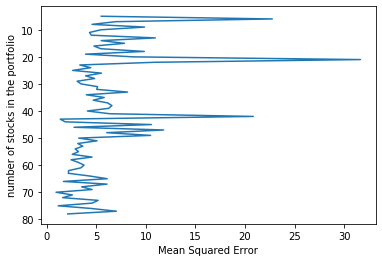

In [13]:
# Plot Efficient Deep Frontier

mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 